In [1]:
pip install pymysql

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 400.3 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import re
import numpy as np

In [3]:
db = pymysql.connect(
    host="10.64.66.27",
    port=9030,
    user='root',
    password='Volvo2022',
    )
cursor = db.cursor()

In [4]:
cursor.execute(f'SELECT DISTINCT vin FROM rms_db.rms_all_120_codev')
vin_list = pd.DataFrame(cursor.fetchall())
cursor.close()

In [41]:
for index,row in vin_list.iterrows():
    print(index,': ',row[0])

0 :  LYVXEEDE5ML536206
1 :  LYVXEEDE4ML530817
2 :  LYVXEEDE7ML489406
3 :  LYVXEEDE7ML536126
4 :  LYVXEEDE2ML530797
5 :  LYVXEEDEXML545628
6 :  LYVXEEDE9ML525905
7 :  LYVXEEDEXML536024
8 :  LYVXEEDE2ML536213
9 :  LYVXEEDE6ML541169
10 :  LYVXEEDE4ML453320
11 :  LYVXEEDE8ML500798
12 :  LYVXEEDE5ML536223
13 :  LYVXEEDE9ML575798
14 :  LYVXEEDE4ML521387
15 :  LYVXEEDE4ML485281
16 :  LYVXEEDE4ML545737
17 :  LYVXEEDE5ML525836
18 :  LYVXEEDEXML545676
19 :  LYVXEEDE7ML530178
20 :  LYVXEEDE1ML489661
21 :  LYVXEEDEXML536010
22 :  LYVXEEDE4ML545687
23 :  LYVXEEDE8ML545983
24 :  LYVXEEDE4ML485264
25 :  LYVXEEDE4ML575868
26 :  LYVXEEDE3ML541114
27 :  LYVXEEDE3ML489385
28 :  LYVXEEDE0ML535240
29 :  LYVXEEDE1ML545808
30 :  LYVXEEDE1ML536039
31 :  LYVXEEDE0ML535786
32 :  LYVXEEDE6ML541091
33 :  LYVXEEDE5NL659134
34 :  LYVXEEDE5ML535850
35 :  LYVXEEDE5ML469395
36 :  LYVXEEDEXNL670825
37 :  LYVXEEDE6ML530902
38 :  LYVXEEDE4ML575787
39 :  LYVXEEDE2ML489507
40 :  LYVXEEDEXML531051
41 :  LYVXEEDE5ML489470
42

In [5]:
vin_example = vin_list.iloc[0][0]
cursor = db.cursor()
cursor.execute(f'SELECT sending_time,accumulated_mileage,battery_pack_temperature,vehicle_state,soc,total_current,total_voltage FROM rms_db.rms_all_120_codev where vin="{vin_example}"')
df_vin = pd.DataFrame(cursor.fetchall())
cursor.close()

In [6]:
df_vin

0        1  \
0      2021-03-12 08:51:21      8.0   
1      2021-03-12 08:51:51      8.0   
2      2021-03-12 08:52:21      8.0   
3      2021-03-12 08:52:51      8.0   
4      2021-03-12 08:53:21      8.0   
...                    ...      ...   
217285 2023-01-16 21:55:22  24364.0   
217286 2023-01-16 21:55:52  24364.0   
217287 2023-01-16 21:56:22  24364.0   
217288 2023-01-16 21:56:52  24364.0   
217289 2023-01-16 21:57:22  24364.0   

                                                        2  \
0       "[{""tem_package"":""1"",""totalPBProbes"":""5...   
1       "[{""tem_package"":""1"",""totalPBProbes"":""5...   
2       "[{""tem_package"":""1"",""totalPBProbes"":""5...   
3       "[{""tem_package"":""1"",""totalPBProbes"":""5...   
4       "[{""tem_package"":""1"",""totalPBProbes"":""5...   
...                                                   ...   
217285  "[{""tem_package"":""1"",""totalPBProbes"":""5...   
217286  "[{""tem_package"":""1"",""totalPBProbes"":""5...   
217287  "[{""tem_package"":""1"",""totalPBProbes"":""5...   
217288  "[{""tem_package"":""1"",""totalPBProbes"":""5...   
217289  "[{""tem_package"":""1"",""totalPBProbes"":""5...   

                          3   4     5      6  
0       Vehicle start state  32   4.0  391.2  
1       Vehicle start state  32   4.1  391.2  
2       Vehicle start state  32   4.1  391.1  
3       Vehicle start state  32   4.0  391.0  
4       Vehicle start state  32   3.9  391.0  
...                     ...  ..   ...    ...  
217285  Vehicle start state  74   7.1  422.6  
217286  Vehicle start state  74  35.5  422.5  
217287  Vehicle start state  74   3.8  424.1  
217288  Vehicle start state  74   4.1  423.8  
217289             Flameout  74   6.6  423.9  

[217290 rows x 7 columns]

In [7]:
df_vin = df_vin.rename(columns={0: 'Sending Time',
                                1: 'Total Mileage',
                                2: 'Average Temp',
                                3: 'Vehicle State',
                                4: 'SOC(%)',
                                5: 'Total Current',
                                6: 'Total Voltage'})
df_vin_sorted = df_vin.sort_values(by='Sending Time')
df_vin_sorted['Sending Time'].min(), df_vin_sorted['Sending Time'].max()

(Timestamp('2021-02-05 12:12:50'), Timestamp('2023-02-14 21:00:42'))

In [6]:
def processTemp(temp_list):
    x = []
    for row in temp_list:
        datalst1 = row.split(',')
        datalst2 = []
        for obj in datalst1:
            datalst2.append(obj.split(':'))
        datalst3 = datalst2[2:-1]
        res = []
        ans = []
        ave = 0
        res.append(datalst3[0][2])
        for obj in datalst3:
            if len(obj) <= 2:
                res.append(obj[1])
        for obj in res:
            match = re.search(r'\d+\.?\d*', obj)
            if match:
                number = float(match.group())
                ans.append(number)
        for num in ans:
            ave += num
        ave = ave/len(res)
        x.append(ave)
    return x

In [10]:
df_vin_sorted['Average Temp'] = processTemp(df_vin_sorted['Average Temp'].to_list())

In [12]:
# convert temperature into integer type
df_vin_sorted['Average Temp'] = df_vin_sorted['Average Temp'].astype(int)

df_vin_sorted['time_diff'] = df_vin_sorted['Sending Time'].diff().dt.total_seconds()

df_vin_sorted['driving_time'] = 0
df_vin_sorted['parking_time'] = 0

# if not sending signal more than 180s, consider as parking
df_vin_sorted.loc[df_vin_sorted['time_diff'] > 180, 'parking_time'] = df_vin_sorted['time_diff'] 
df_vin_sorted.loc[df_vin_sorted['time_diff'] <= 180, 'driving_time'] = df_vin_sorted['time_diff']

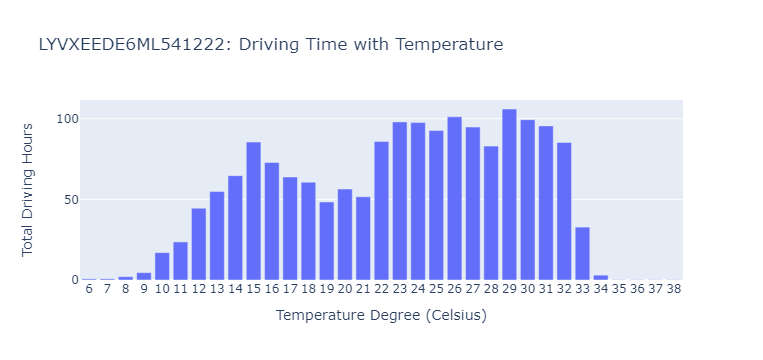

In [33]:
temp_groupby = df_vin_sorted.groupby('Average Temp')['driving_time'].sum()
sum_time_hour = temp_groupby/3600
fig = go.Figure(data=[go.Bar(x=sum_time_hour.index, y=sum_time_hour.values)])
fig.update_layout(title=f'{vin_example}: Driving Time with Temperature',
                  xaxis=dict(tickmode='linear',
                             tick0=1,
                             dtick=1,
                             title='Temperature Degree (Celsius)'),
                  yaxis=dict(title='Total Driving Hours')
                 )
fig.show()

In [7]:
def readTempDataframe(vin):
    cursor = db.cursor()
    cursor.execute(f'SELECT sending_time,battery_pack_temperature FROM rms_db.rms_all_120_codev where vin="{vin}"')
    df_vin = pd.DataFrame(cursor.fetchall())
    cursor.close()
    df_vin = df_vin.rename(columns={0: 'Sending Time',
                                    1: 'Average Temp'})
    df_vin_sorted = df_vin.sort_values(by='Sending Time')
    df_vin_sorted['Average Temp'] = processTemp(df_vin_sorted['Average Temp'].to_list())
    df_vin_sorted['Average Temp'] = df_vin_sorted['Average Temp'].astype(int)
    # separate driving and parking by by threshold 180s
    df_vin_sorted['time_diff'] = df_vin_sorted['Sending Time'].diff().dt.total_seconds()
    df_vin_sorted['driving_time'] = 0
    df_vin_sorted['parking_time'] = 0
    # if not sending signal more than 180s, consider as parking
    df_vin_sorted.loc[df_vin_sorted['time_diff'] > 180, 'parking_time'] = df_vin_sorted['time_diff'] 
    df_vin_sorted.loc[df_vin_sorted['time_diff'] <= 180, 'driving_time'] = df_vin_sorted['time_diff']
    return df_vin_sorted

In [11]:
def plotTimeTemp(df, vin):
    temp_groupby = df.groupby('Average Temp')['driving_time'].sum()
    temp_groupby = temp_groupby/3600
    fig = go.Figure(data=[go.Bar(x=temp_groupby.index, y=temp_groupby.values)])
    fig.update_layout(title=f'Vehicle {vin}: Driving Time with Temperature',
                      xaxis=dict(tickmode='linear',
                                 tick0=1,
                                 dtick=1,
                                 title='Temperature Degree (Celsius)'),
                      yaxis=dict(title='Total Driving Hours'))
    fig.show()
    return temp_groupby

In [17]:
vin_list

0
0    LYVXEEDE6ML489610
1    LYVXEEDE4ML545866
2    LYVXEEDE3ML535927
3    LYVXEEDE3ML453308
4    LYVXEEDEXML536024
..                 ...
122  LYVXEEDE5ML495804
123  LYVXEEDEXML536136
124  LYVXEEDE1ML530726
125  LYVXEEDE9ML521370
126  LYVXEEDE1ML489417

[127 rows x 1 columns]

In [8]:
vin_example = vin_list.iloc[0][0]

In [9]:
df_temp = readTempDataframe(vin_example)

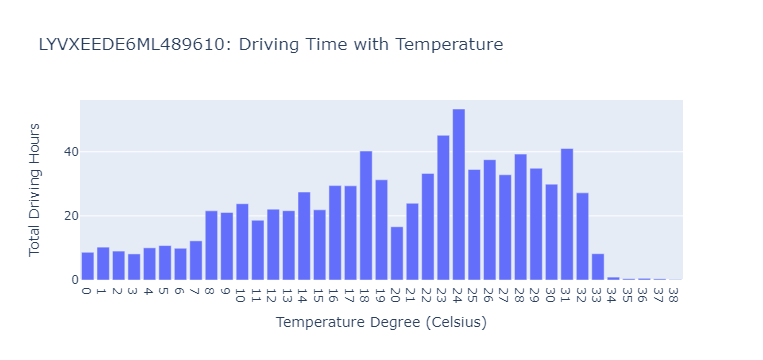

In [18]:
plotTimeTemp(df_temp, vin_example)

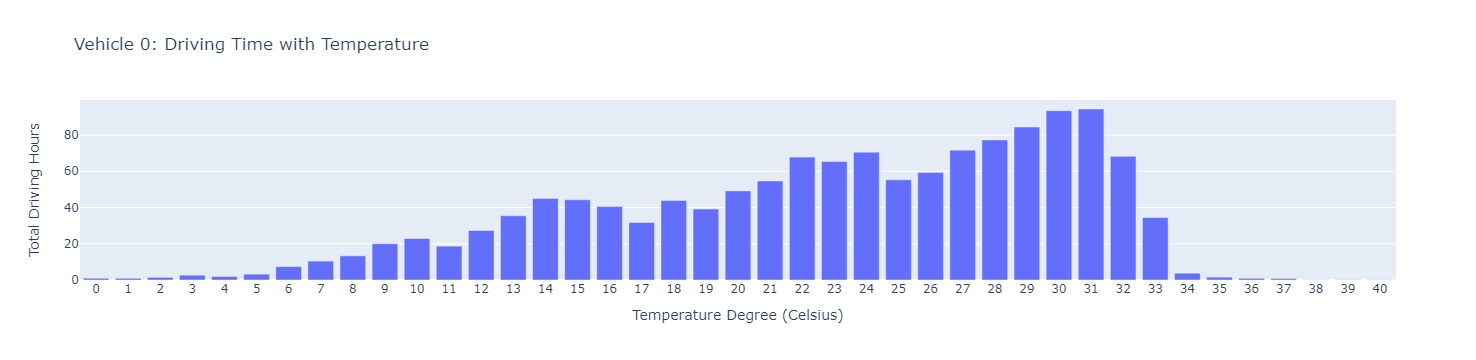

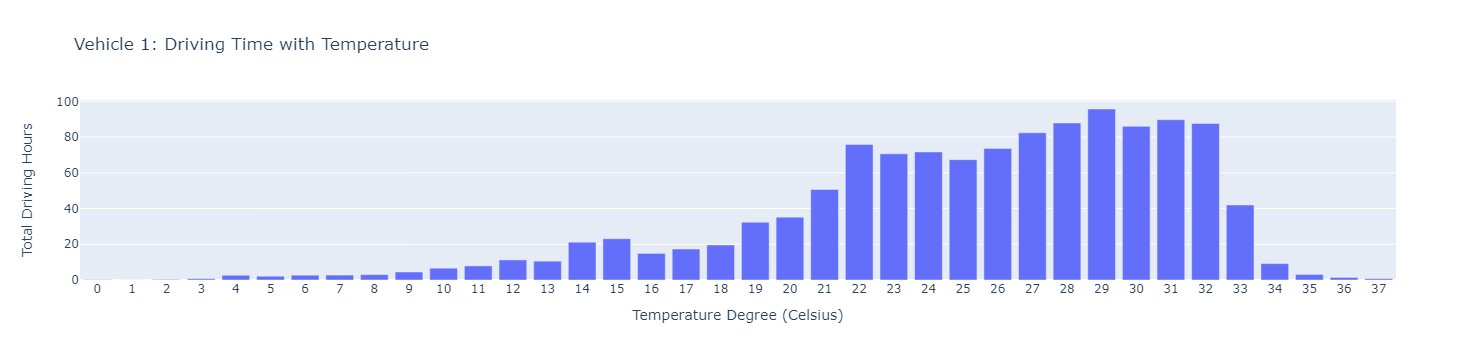

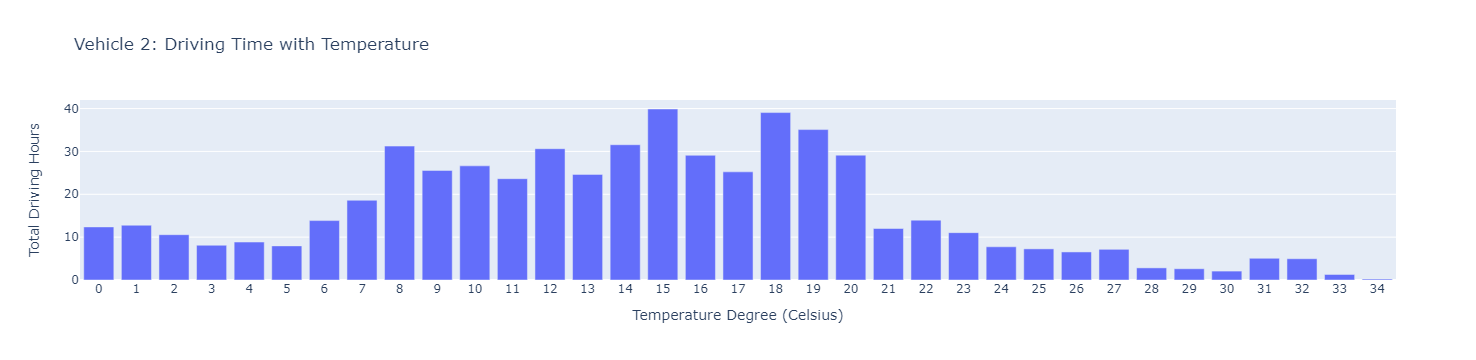

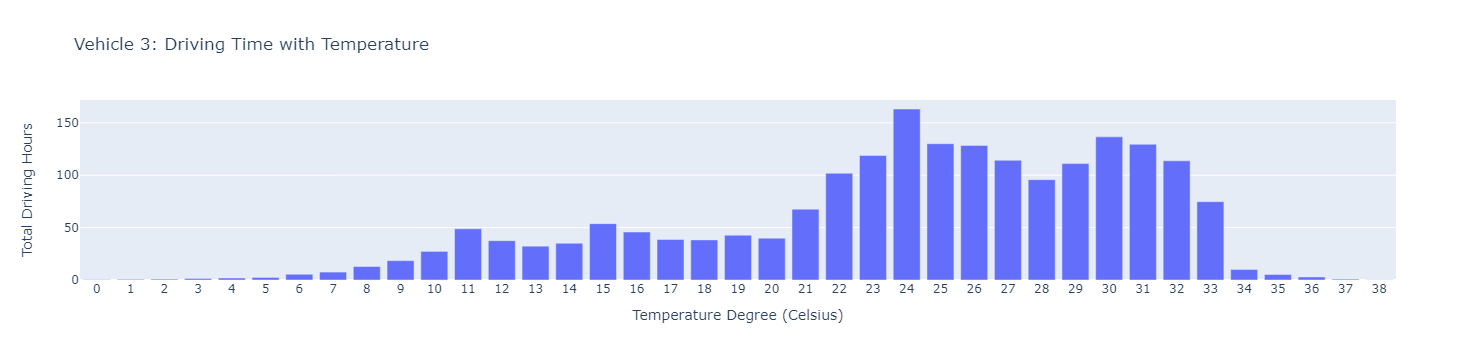

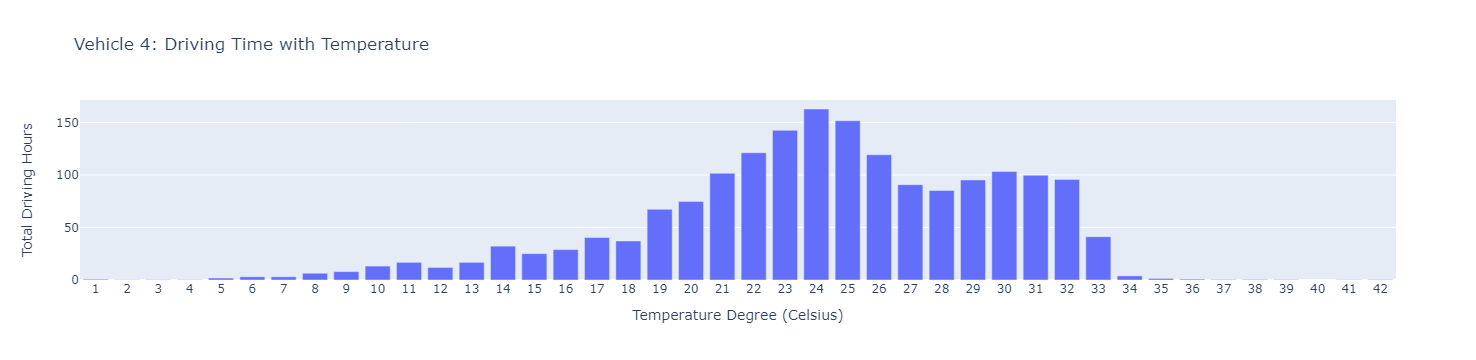

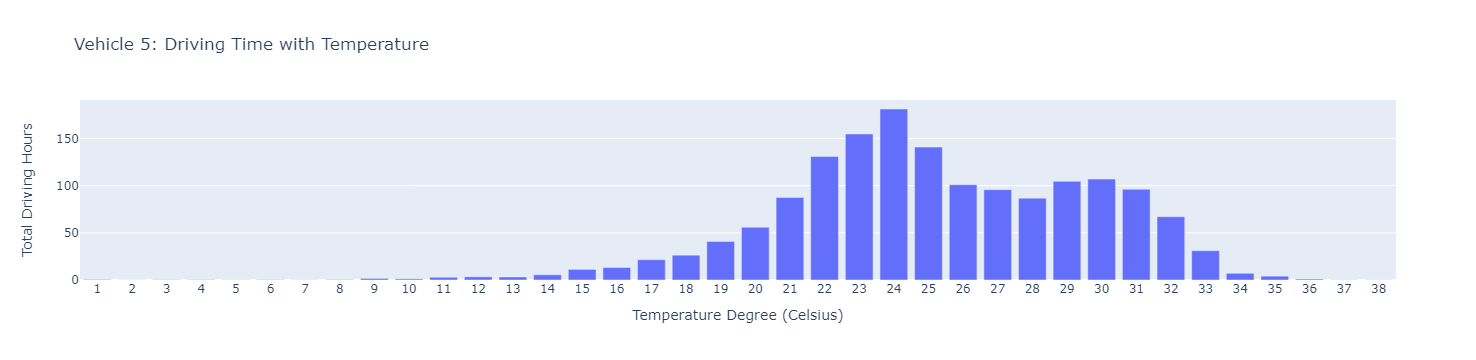

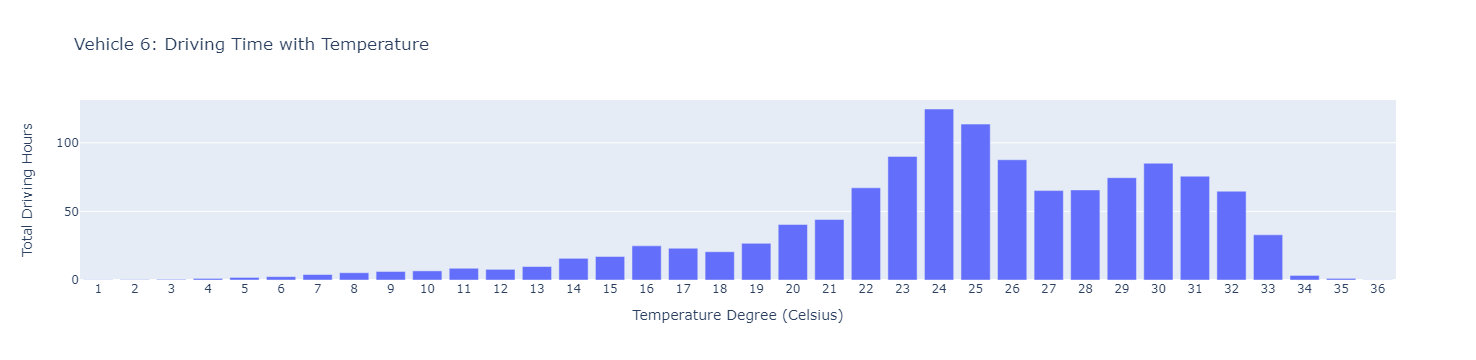

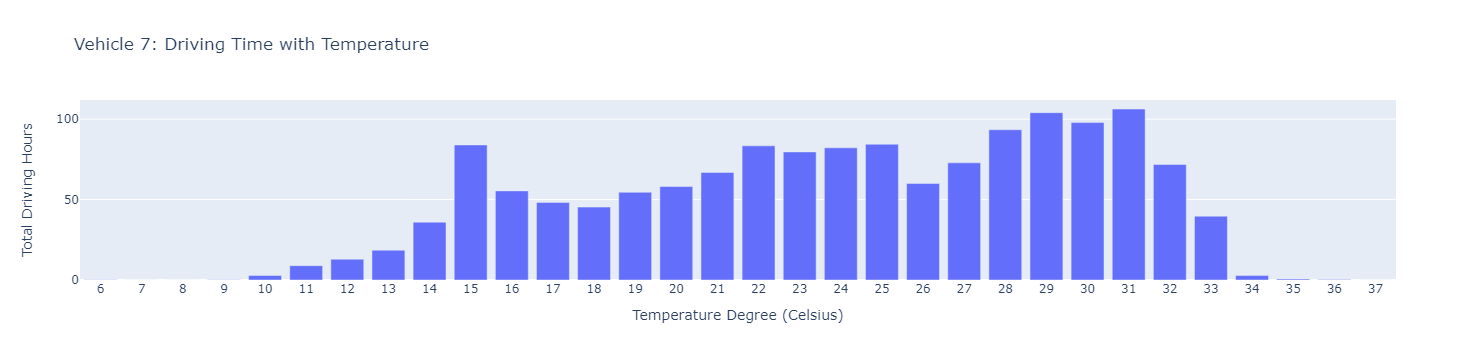

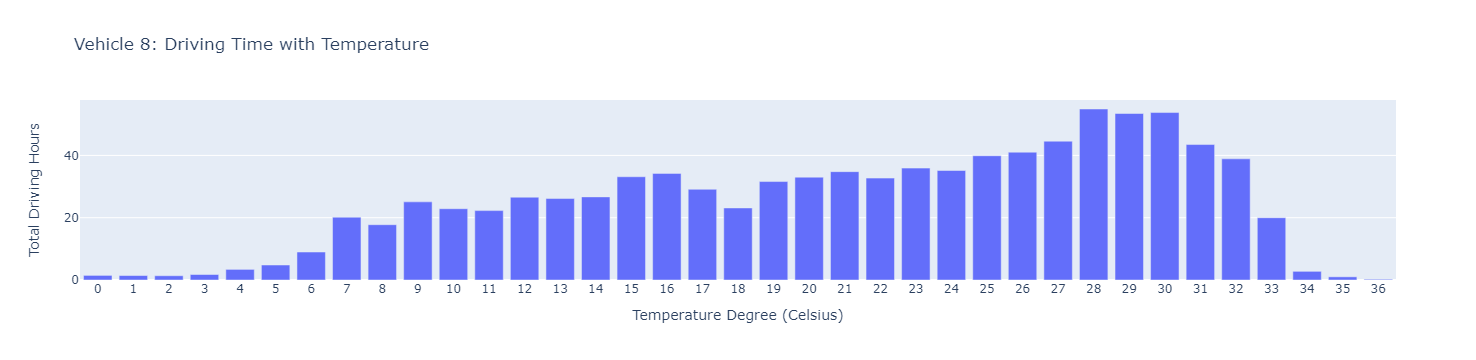

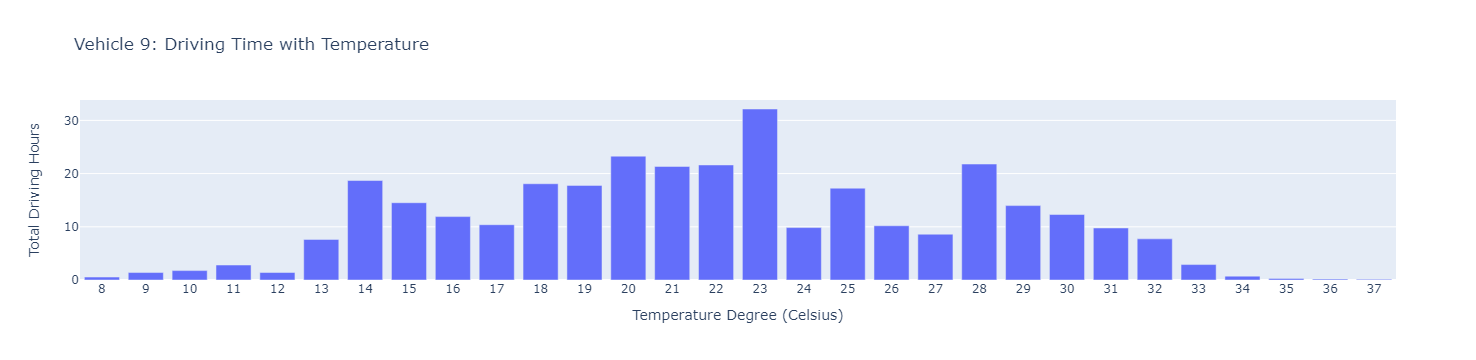

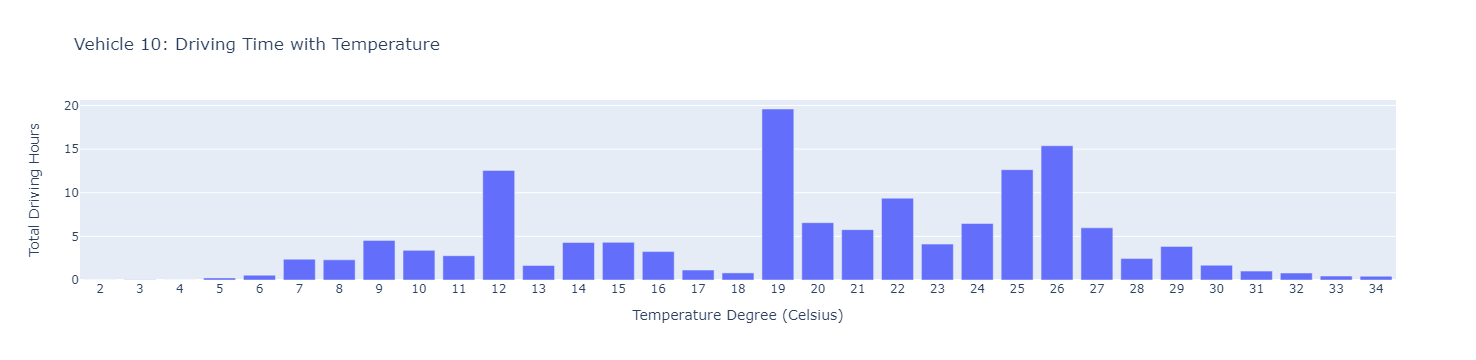

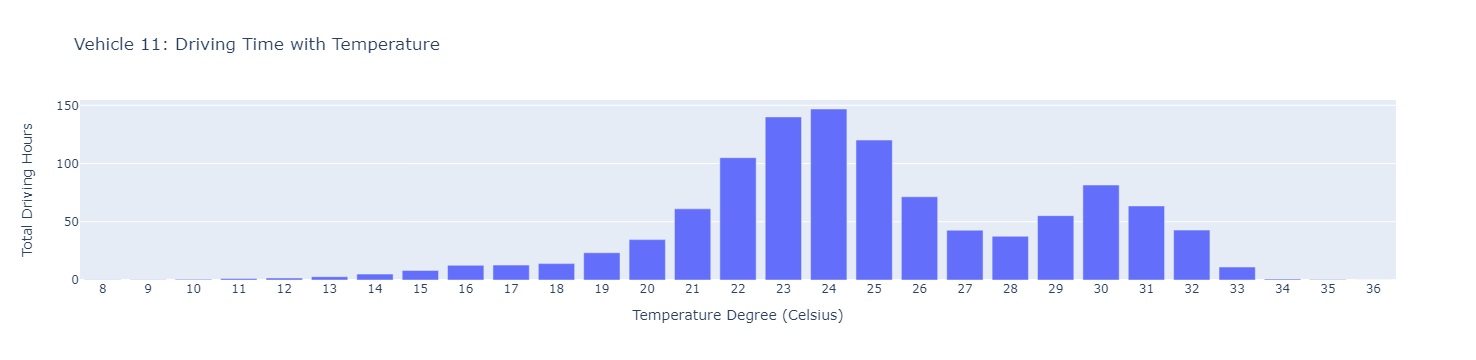

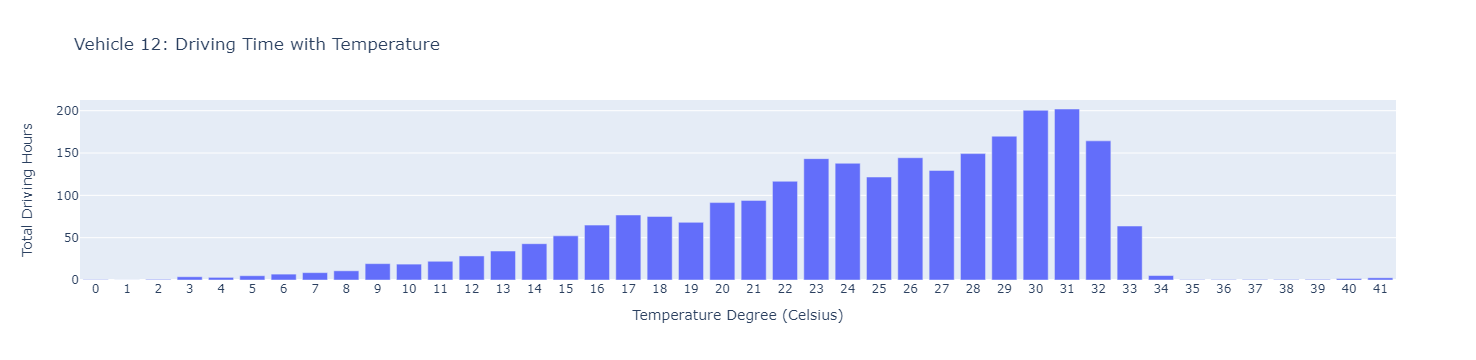

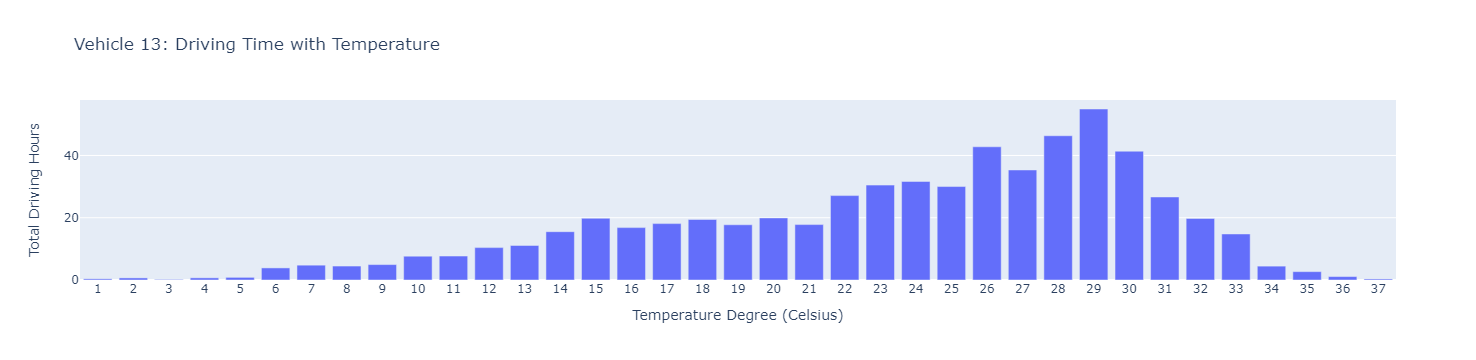

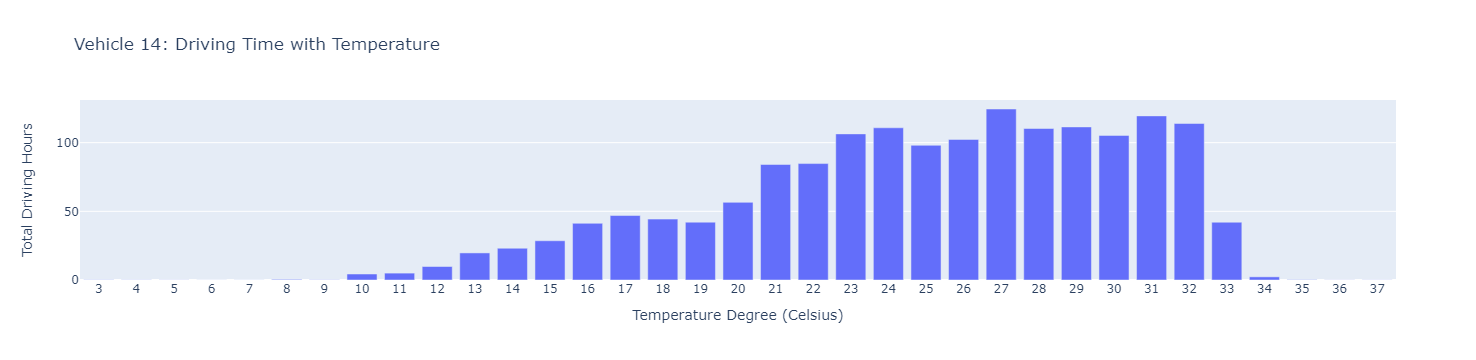

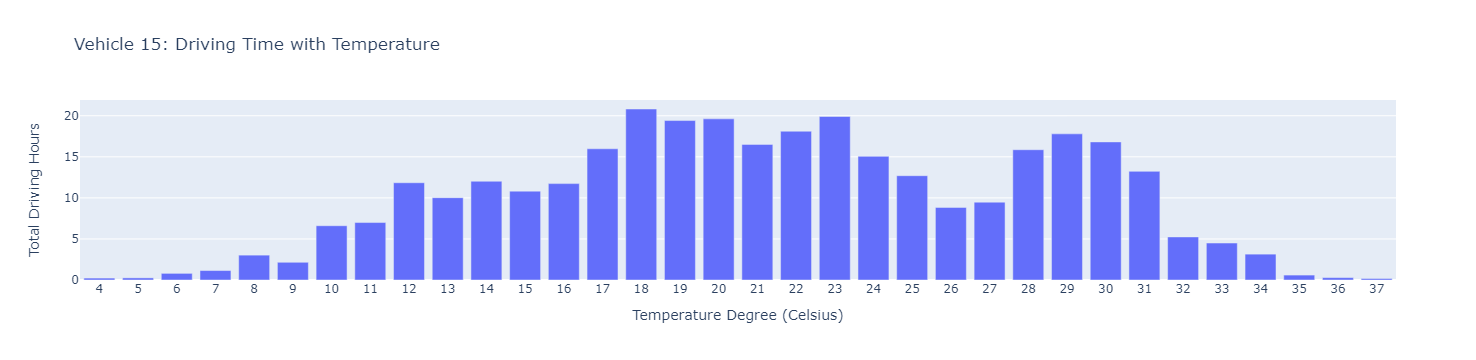

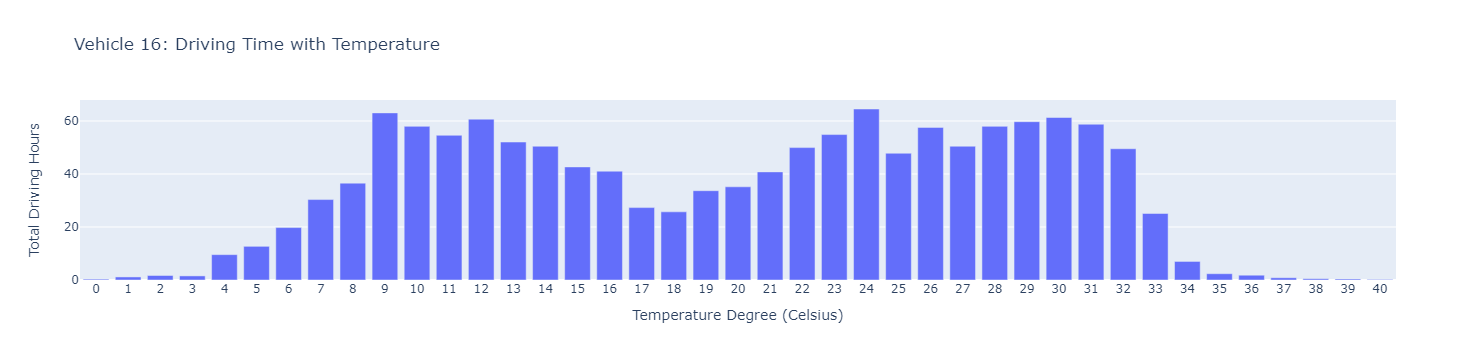

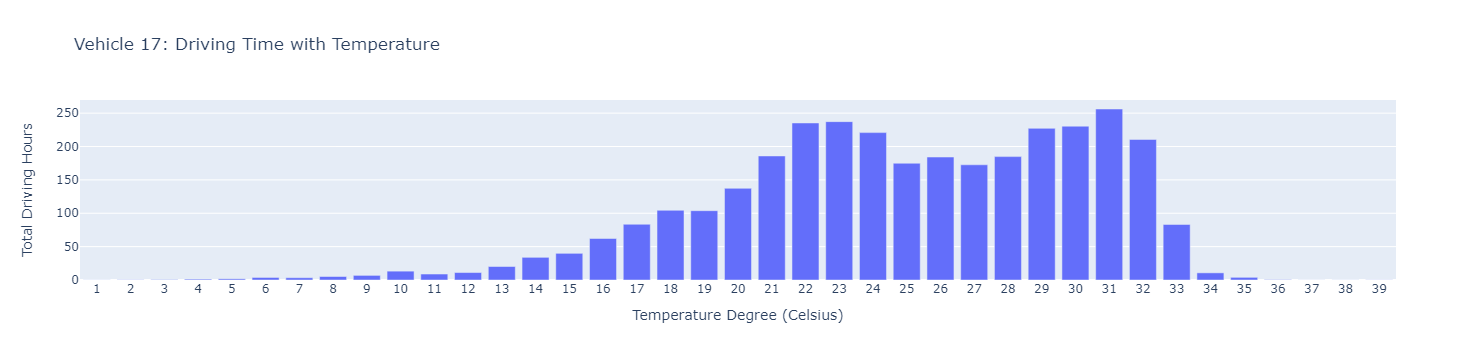

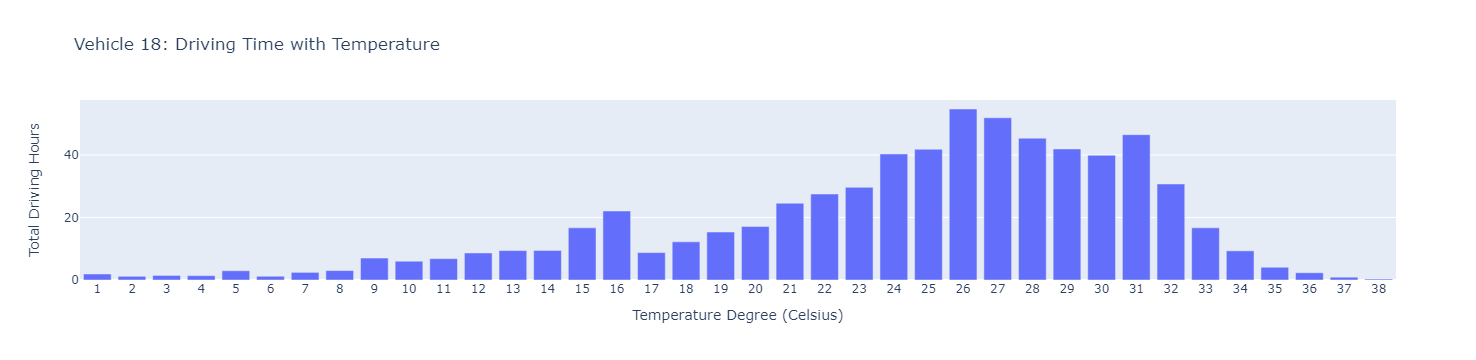

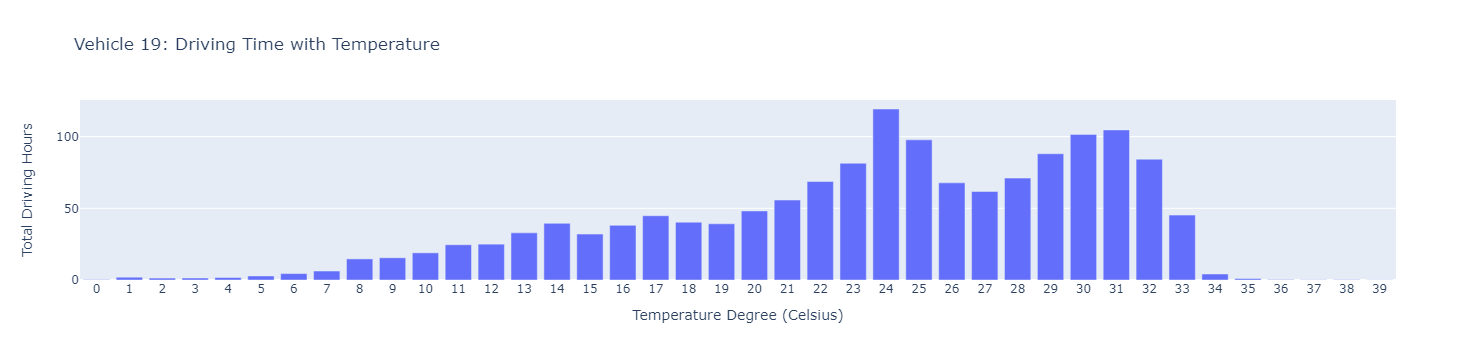

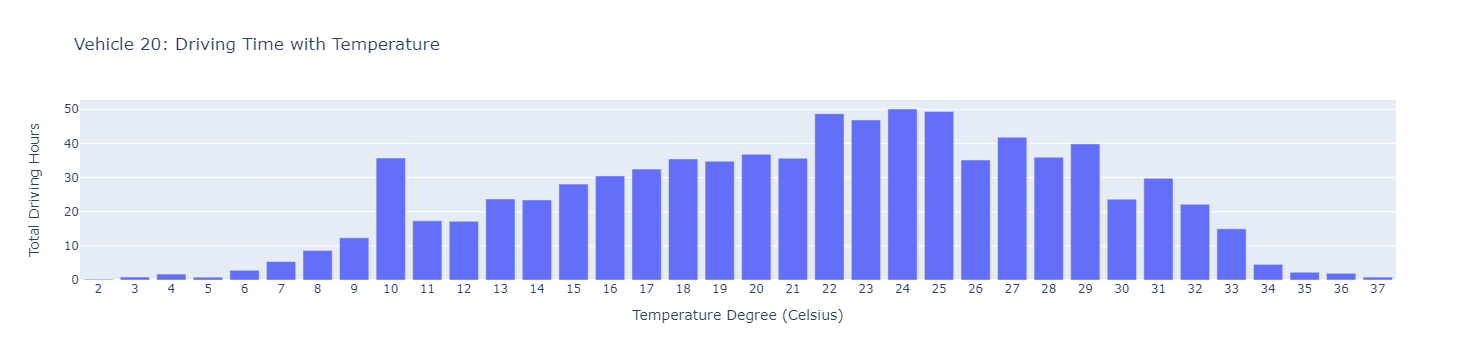

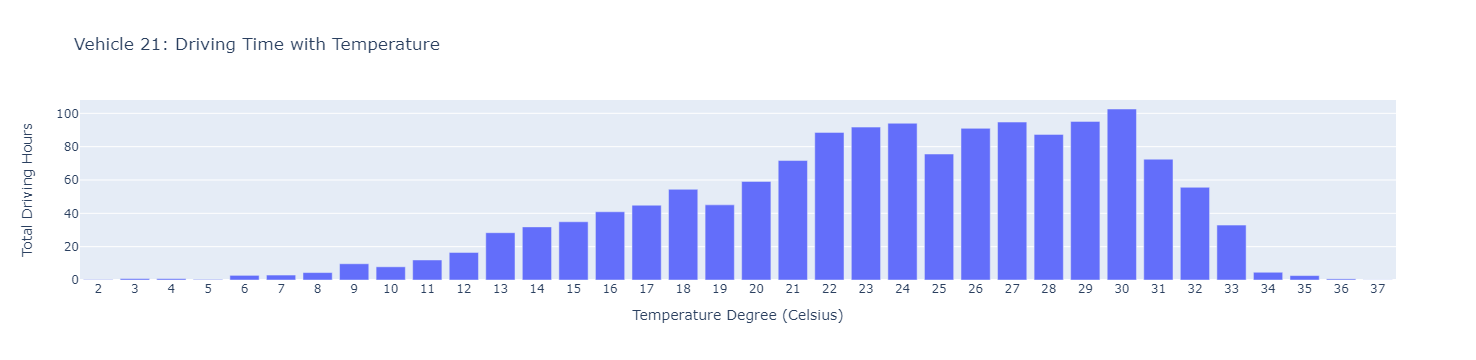

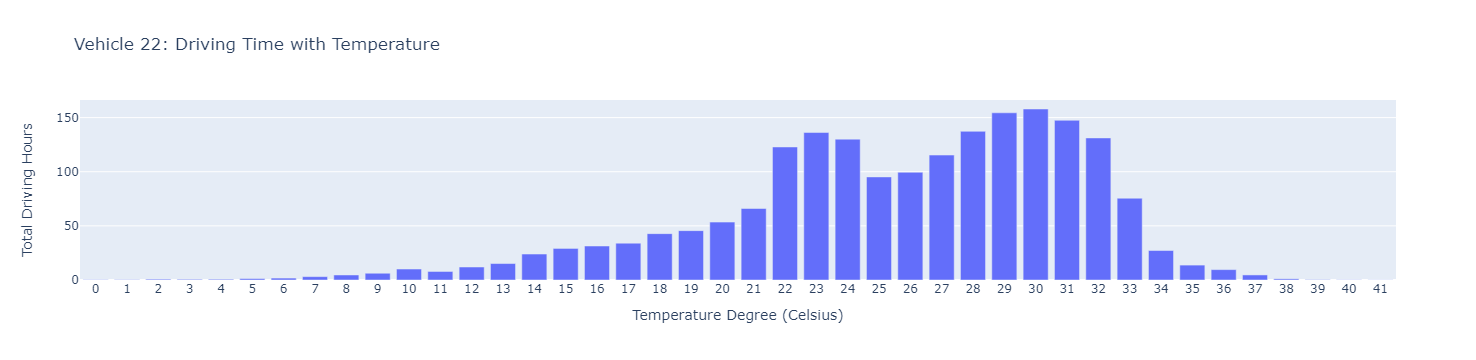

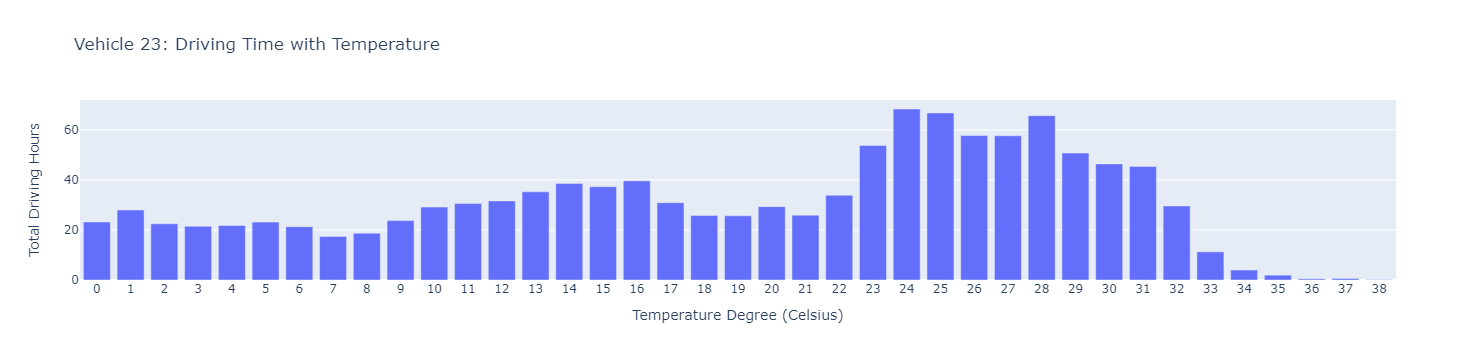

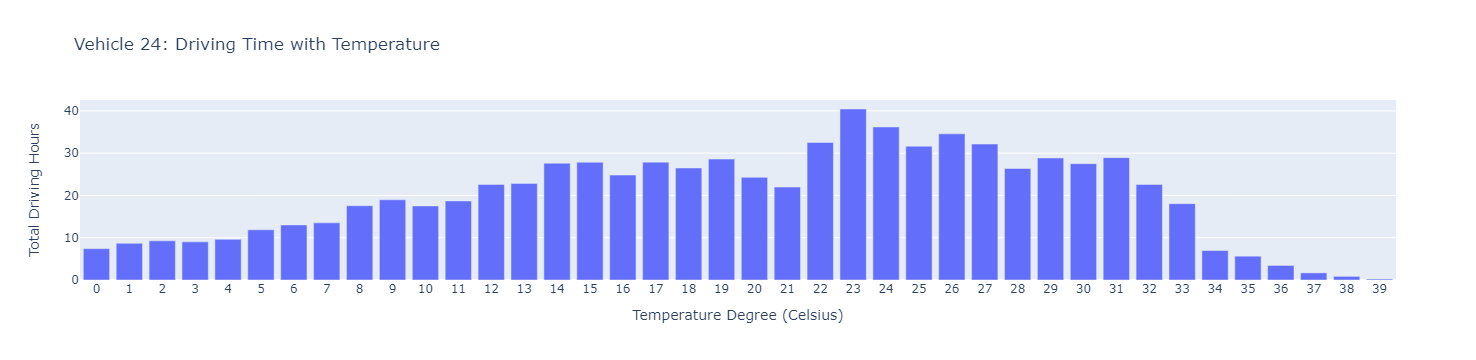

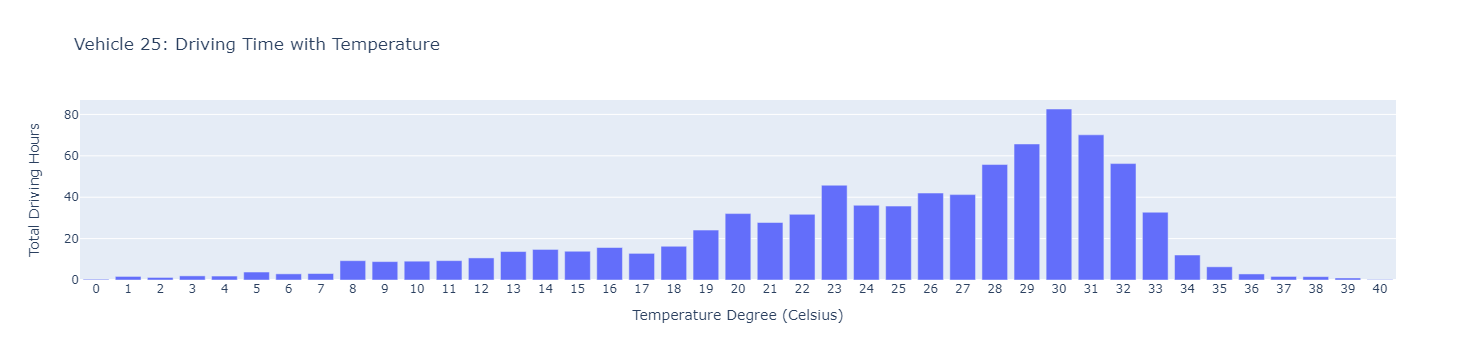

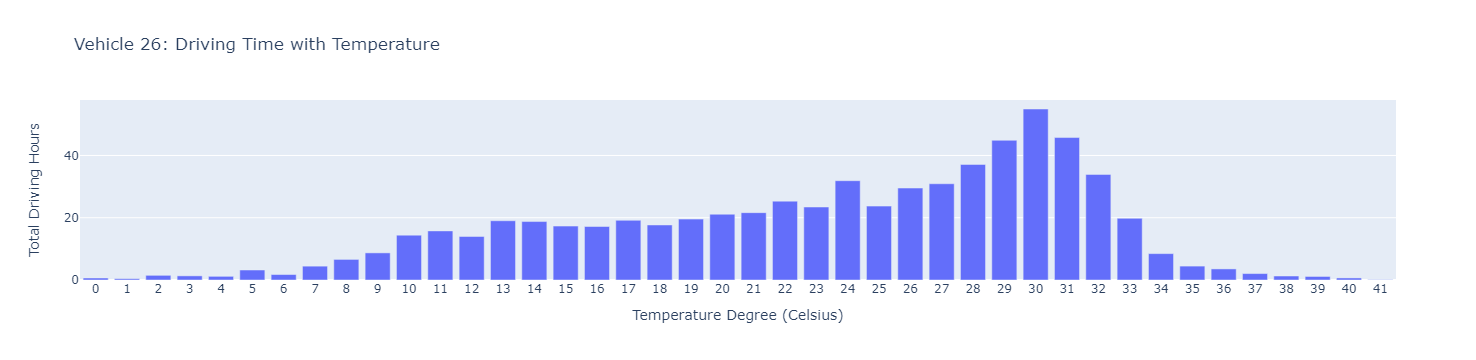

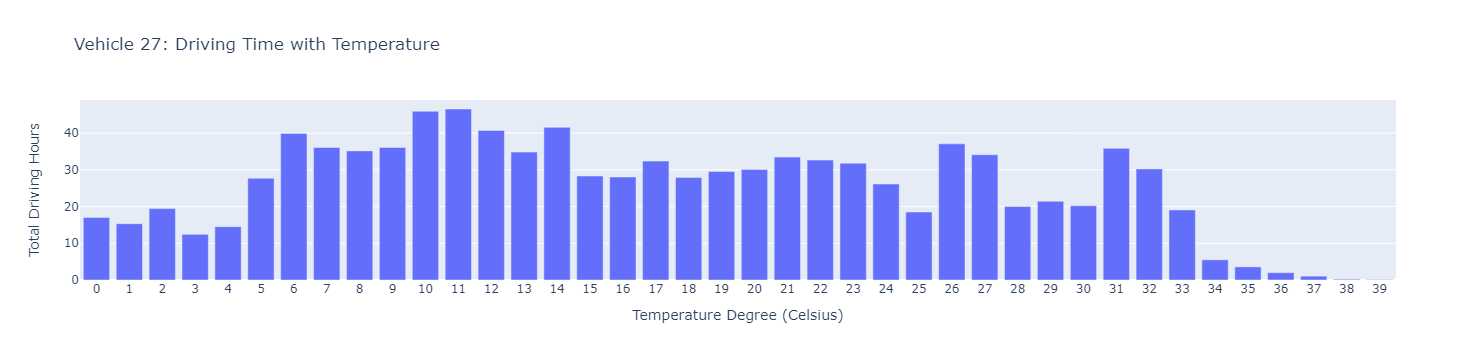

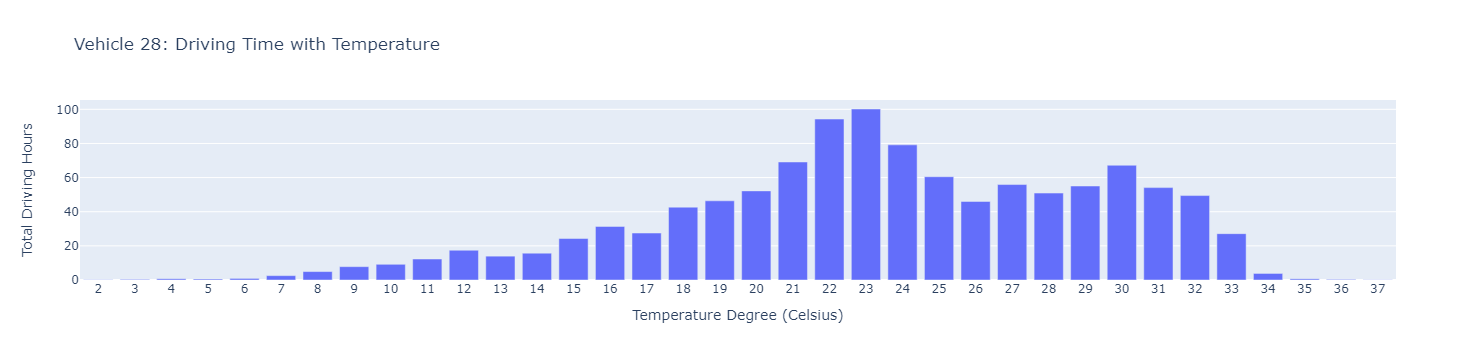

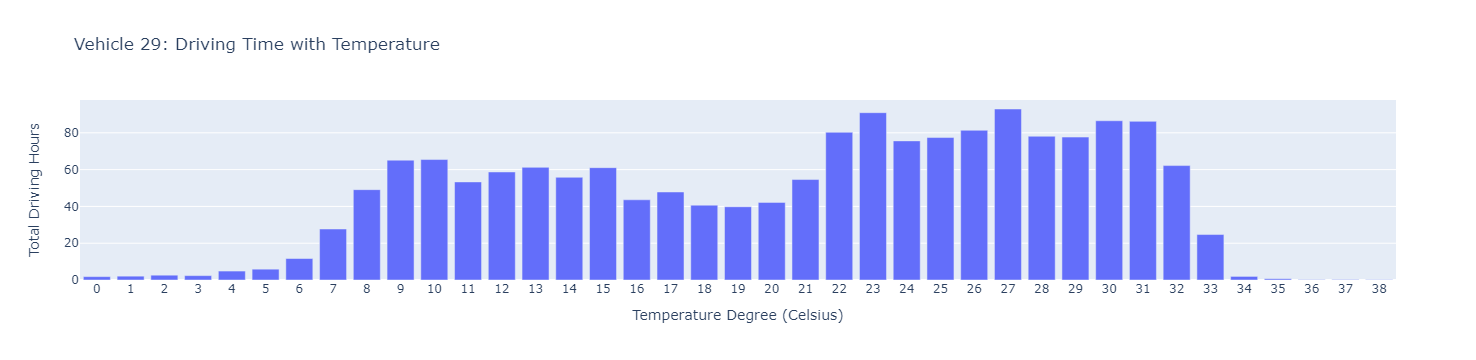

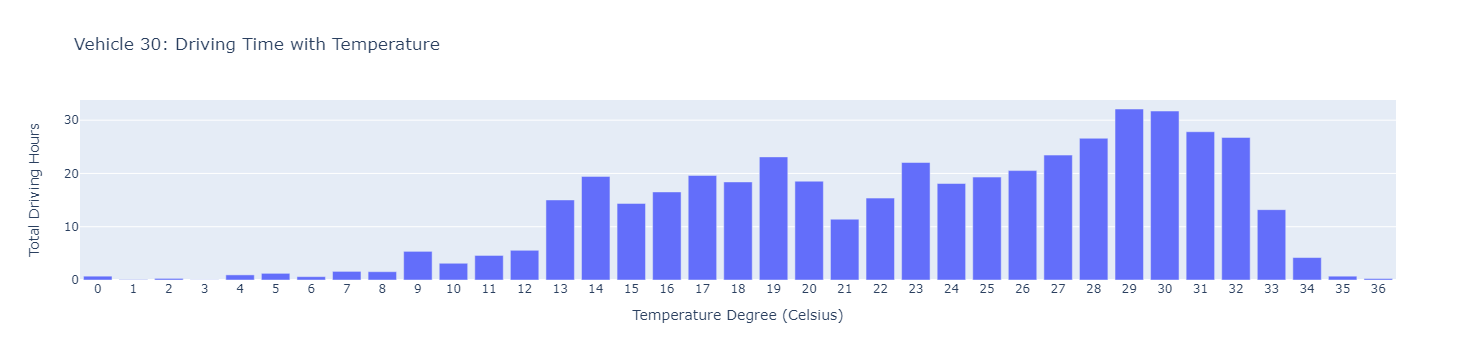

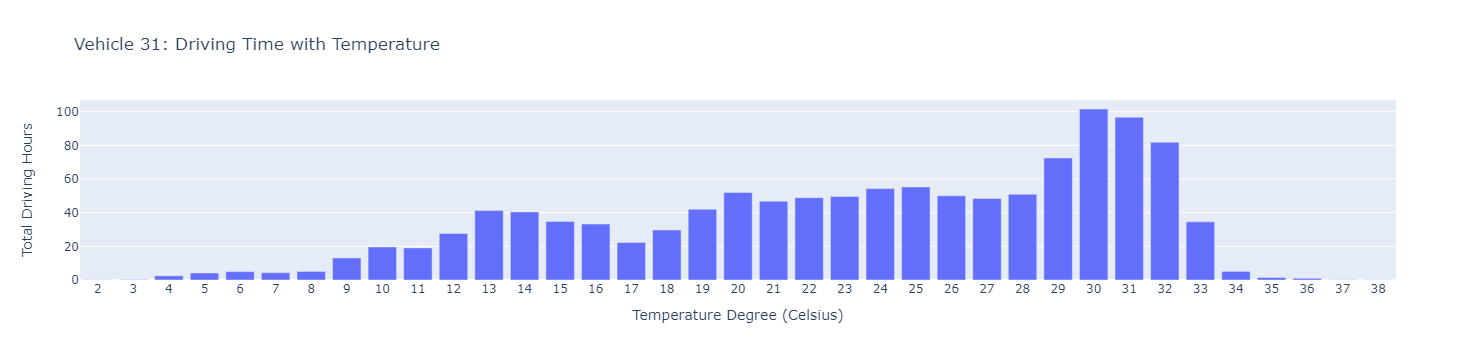

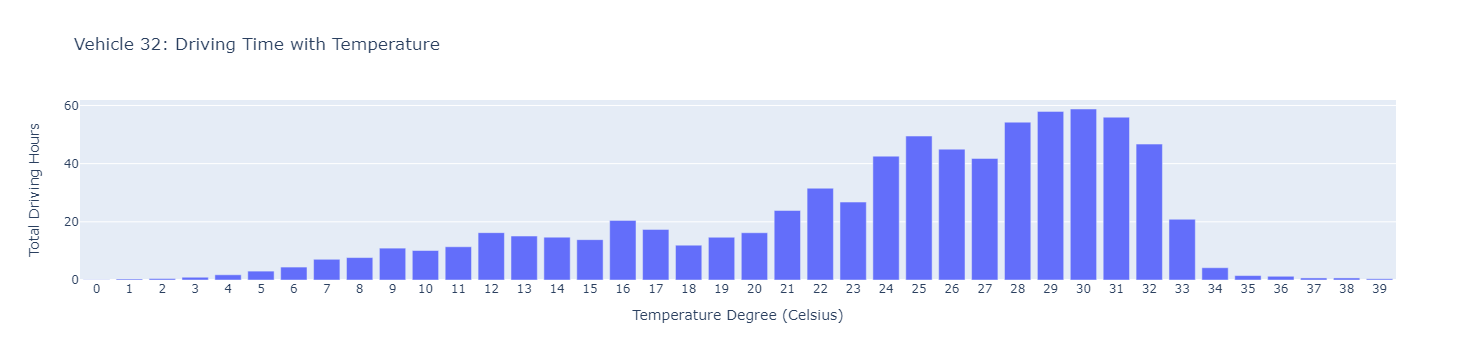

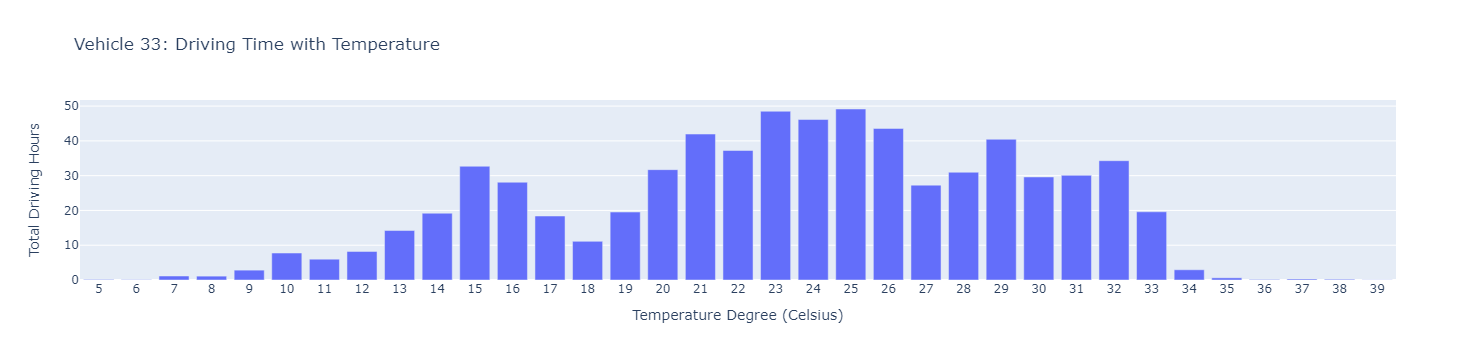

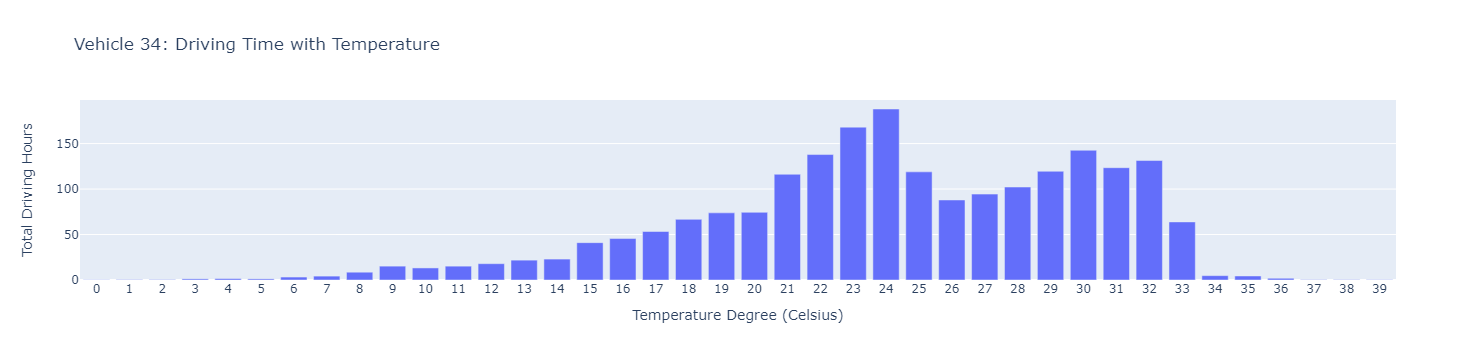

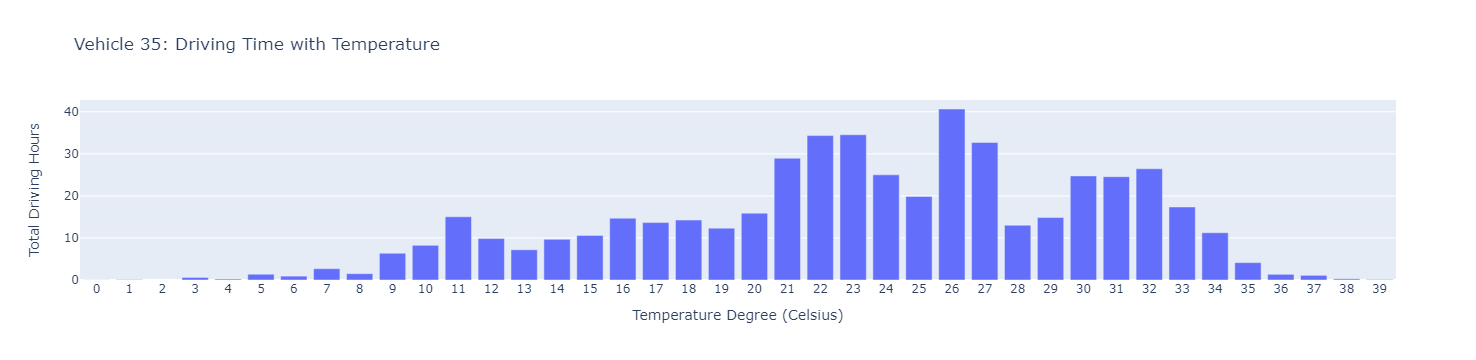

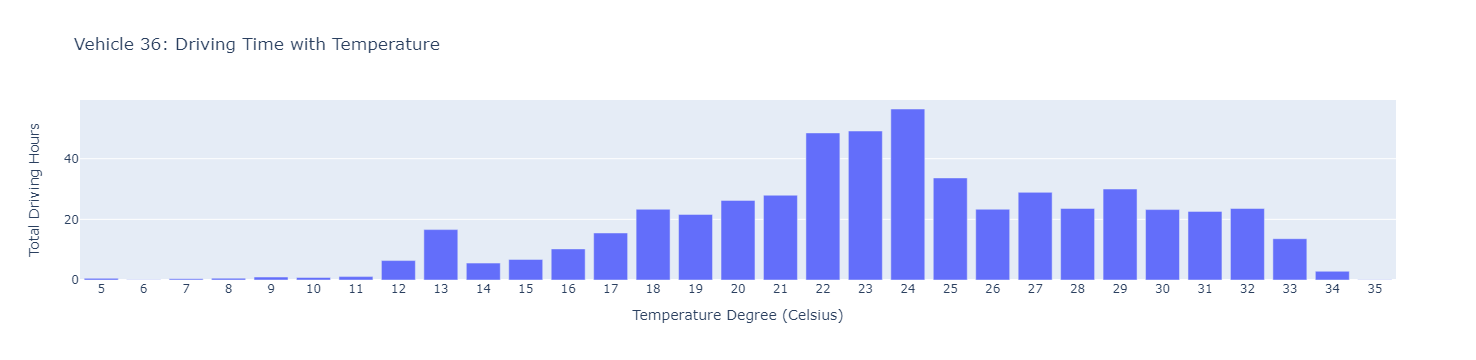

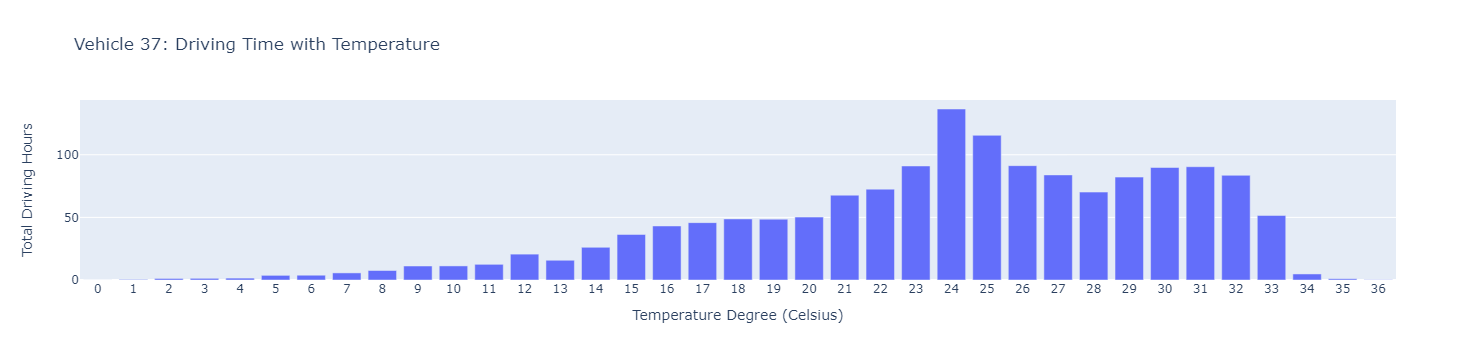

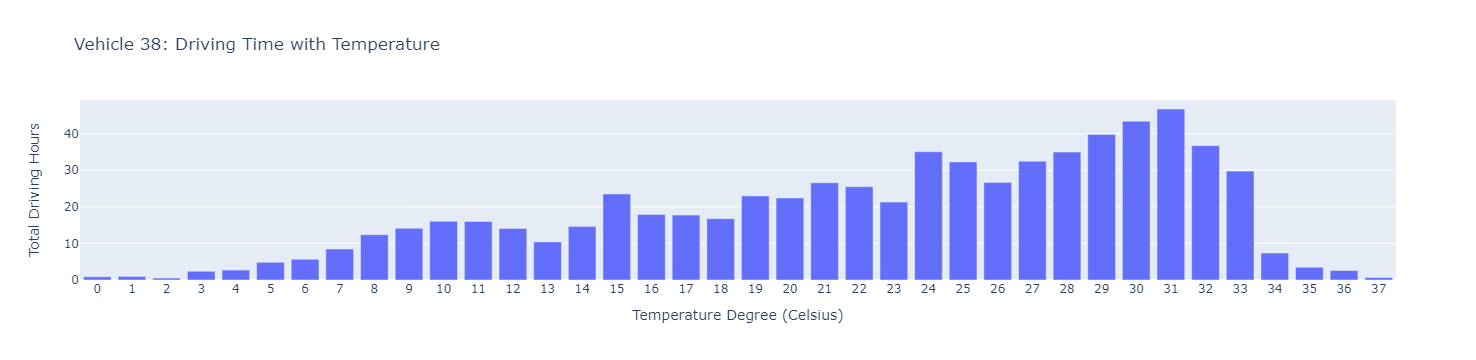

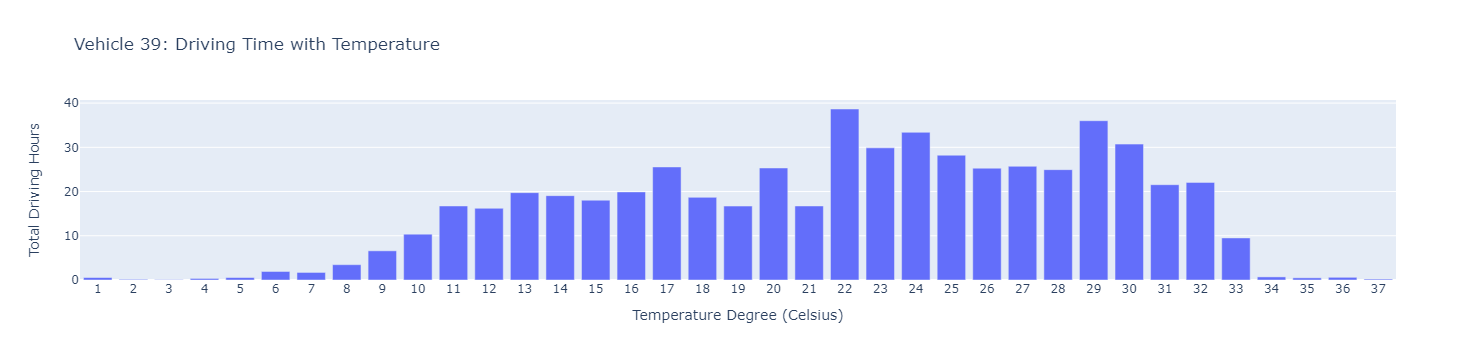

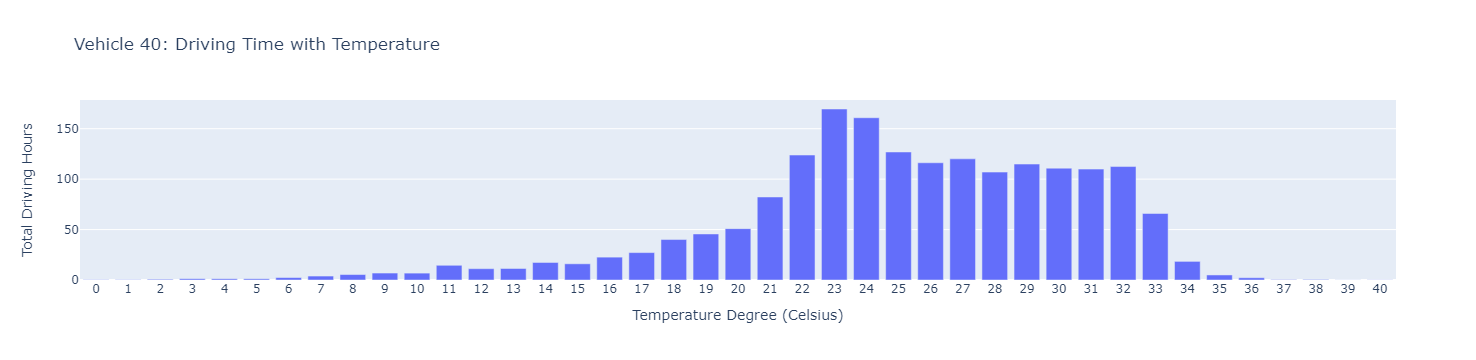

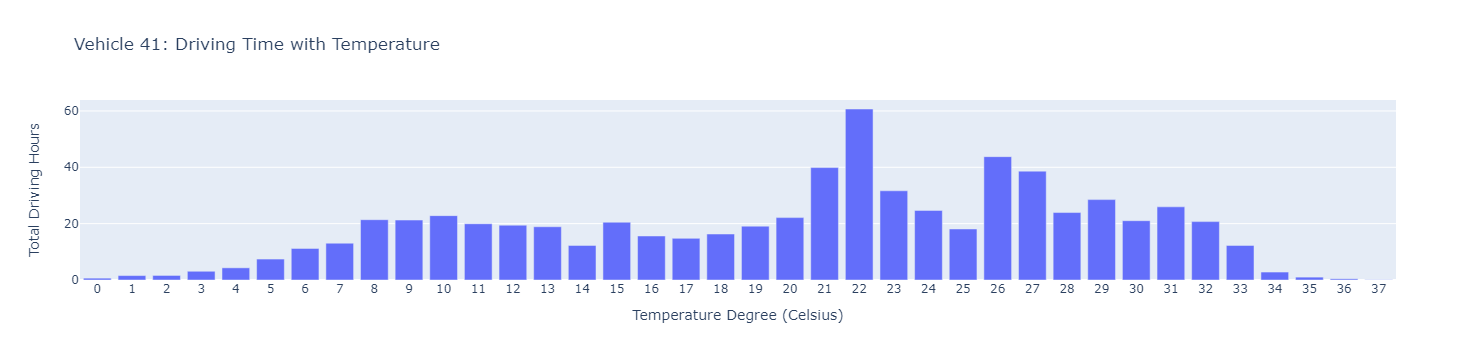

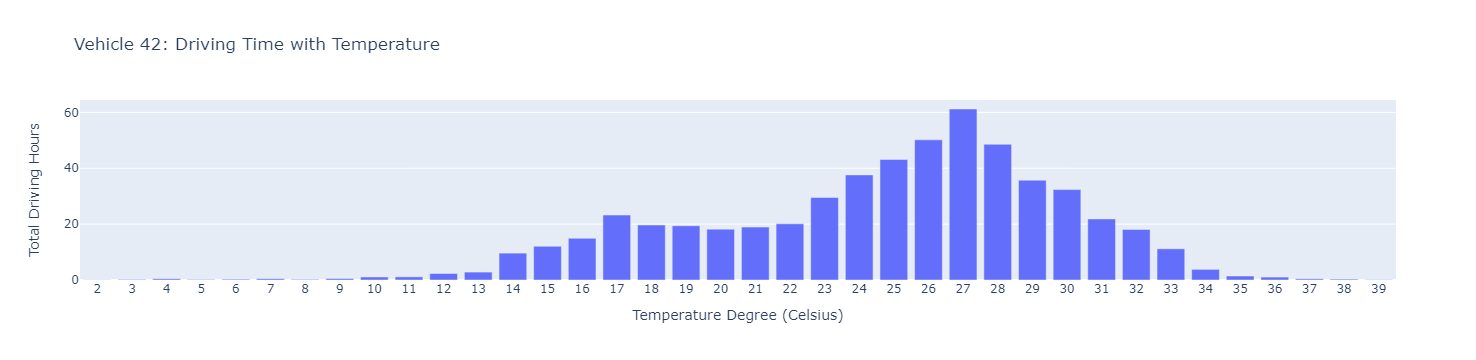

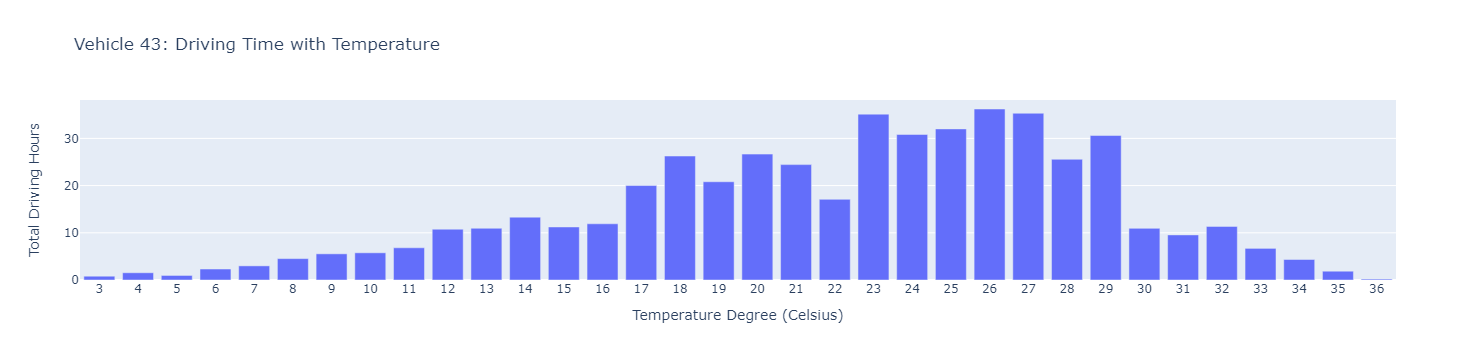

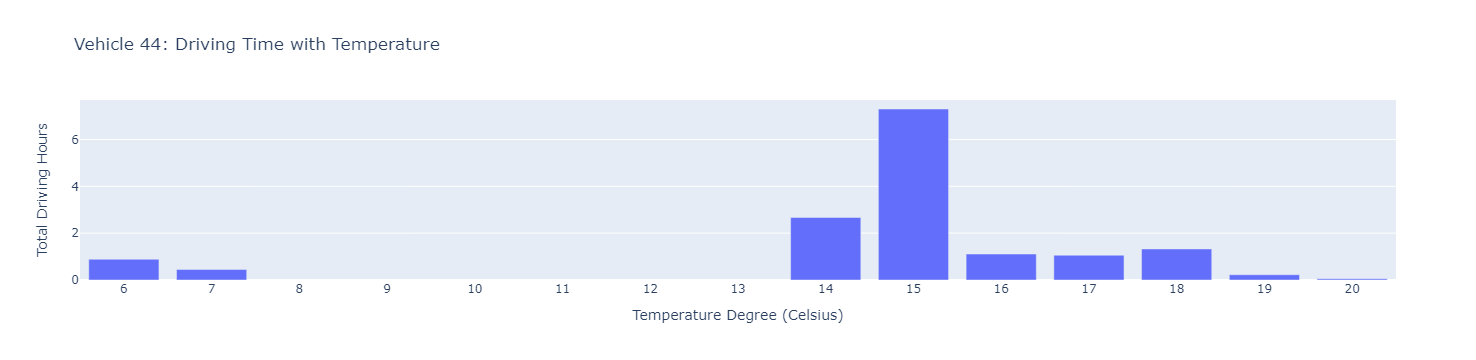

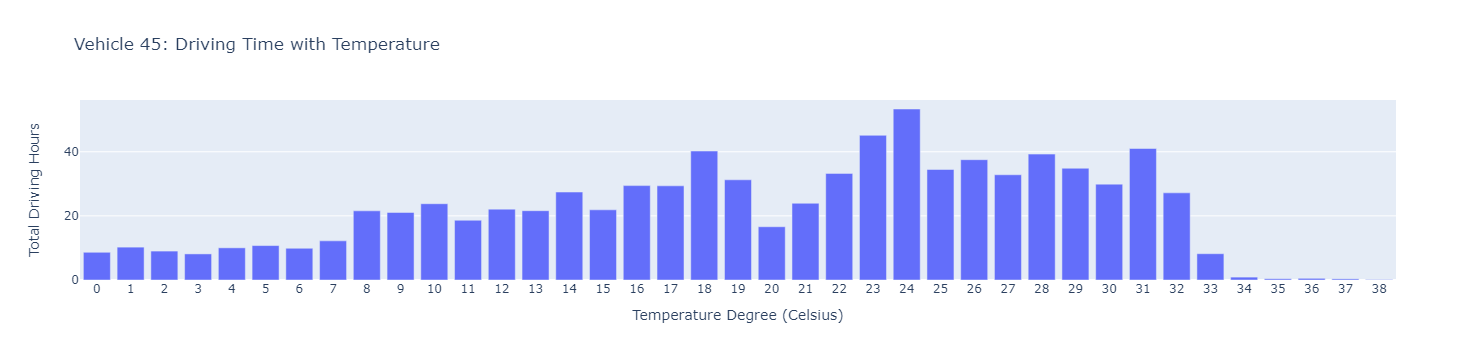

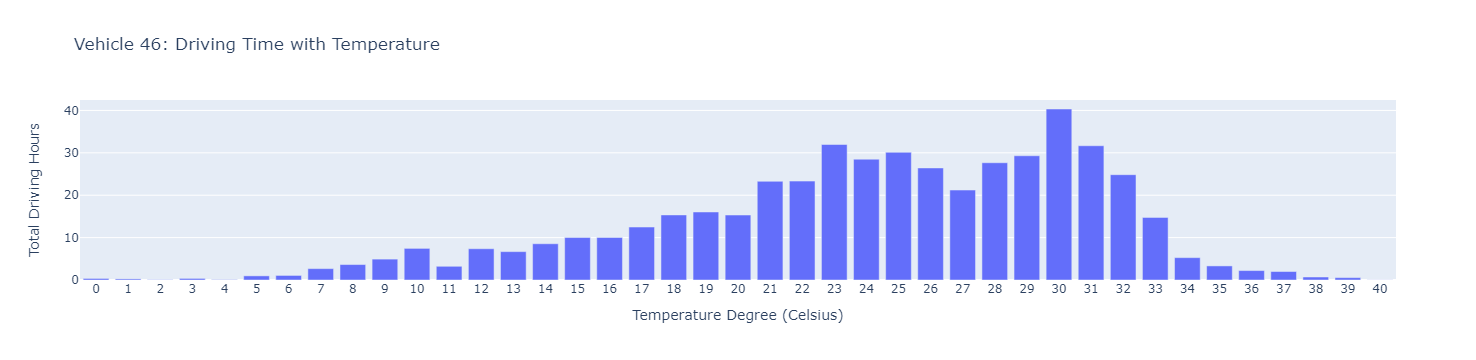

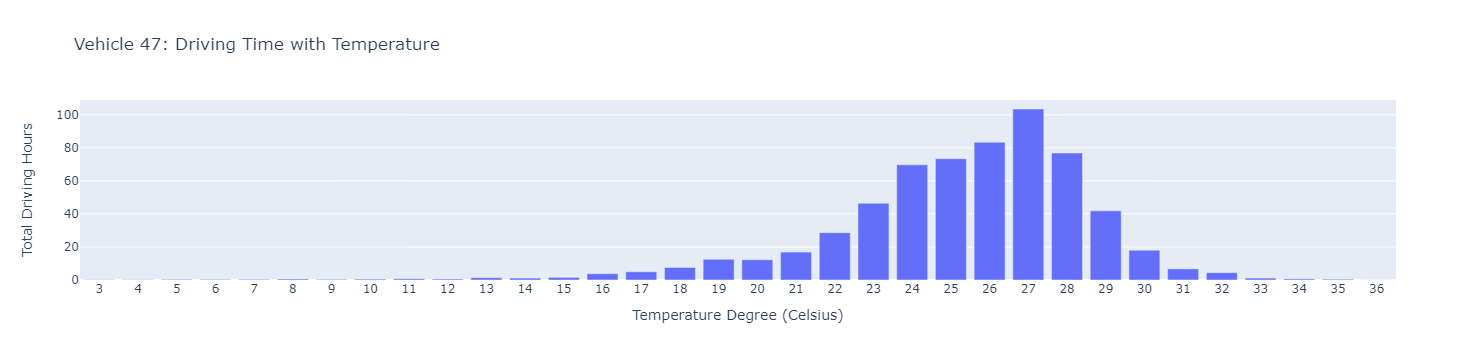

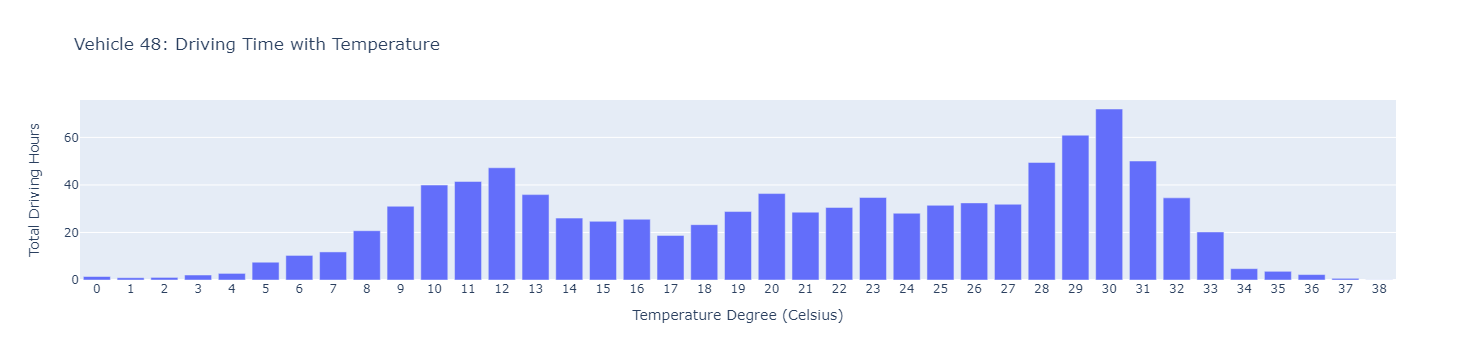

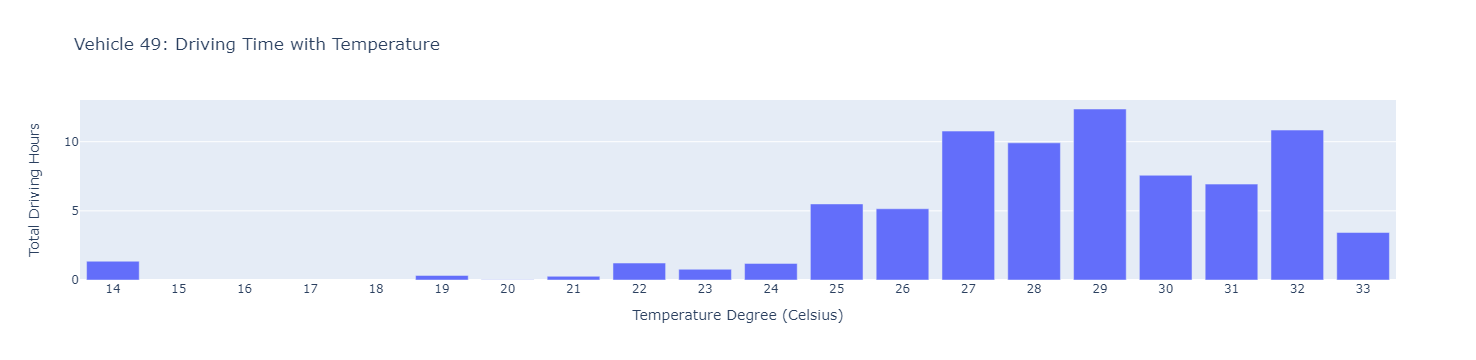

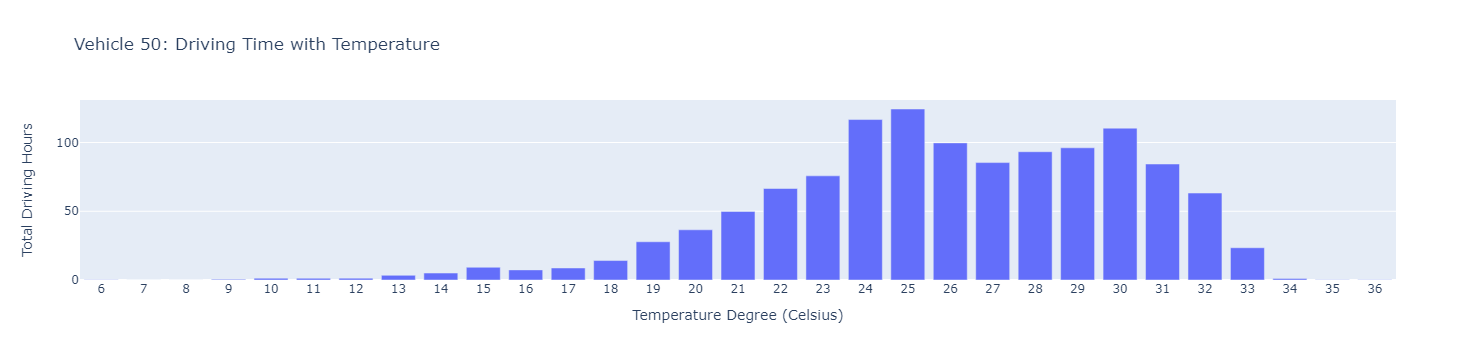

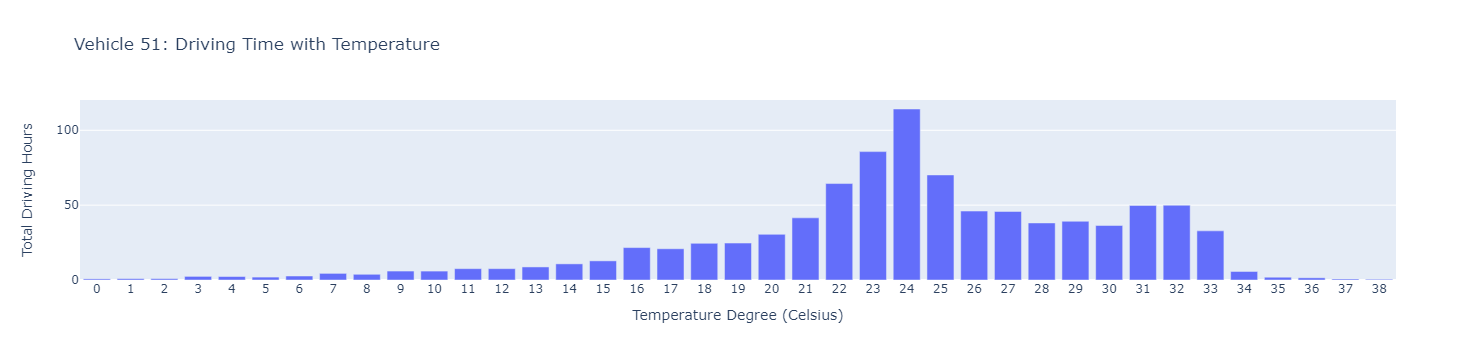

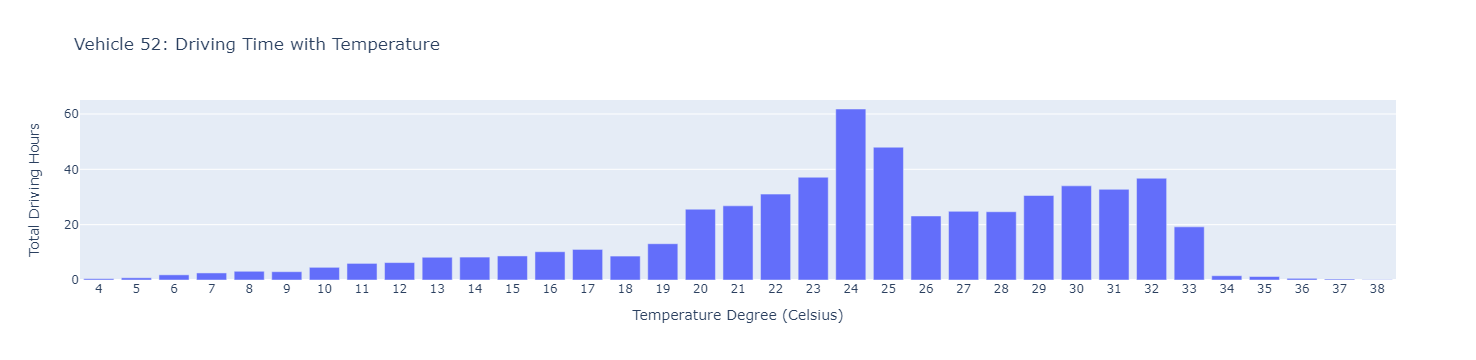

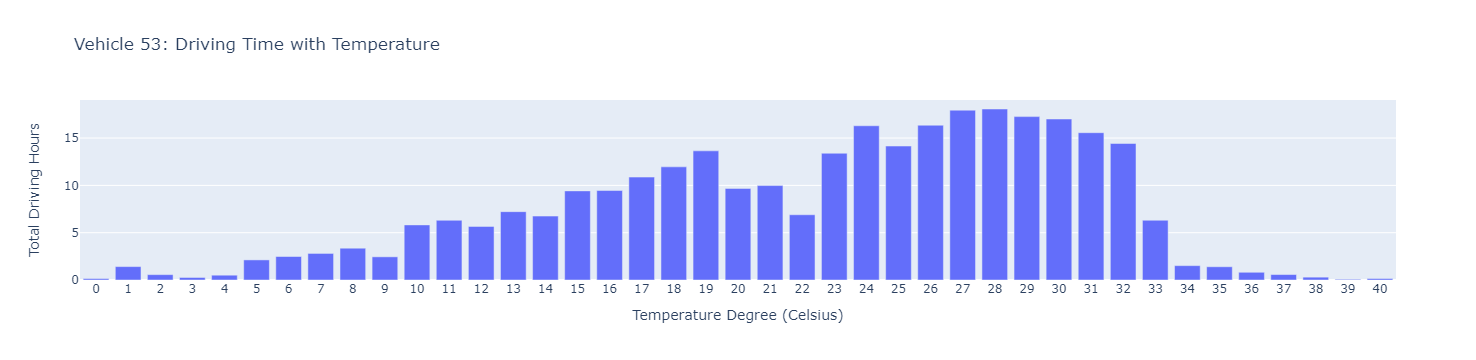

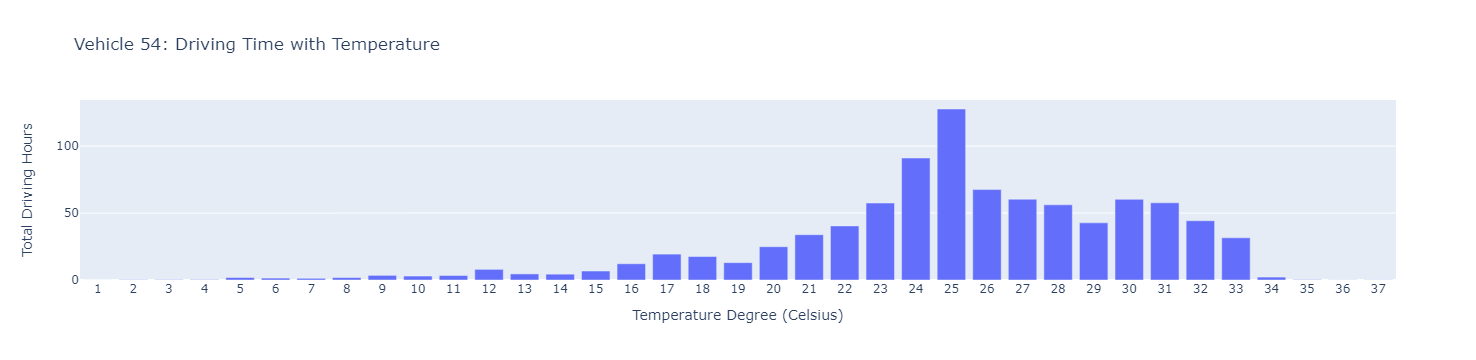

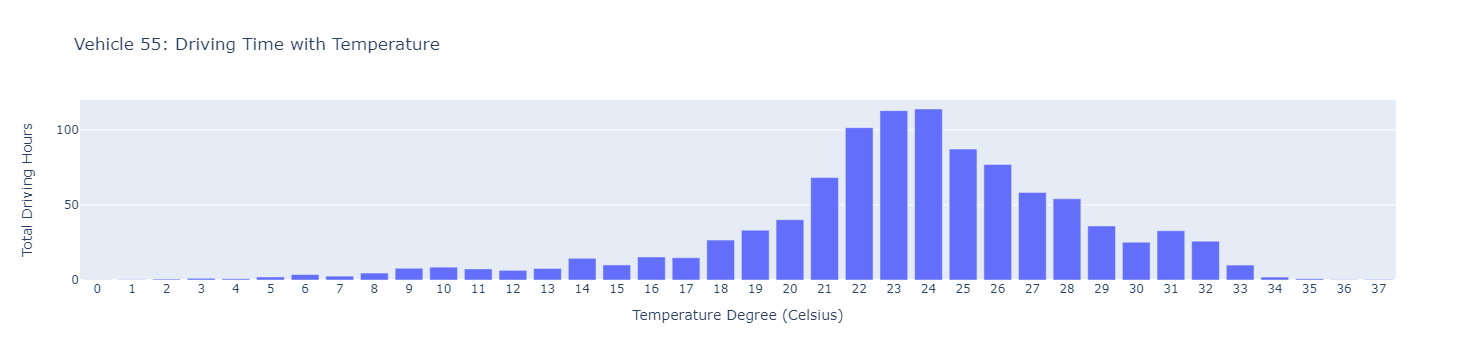

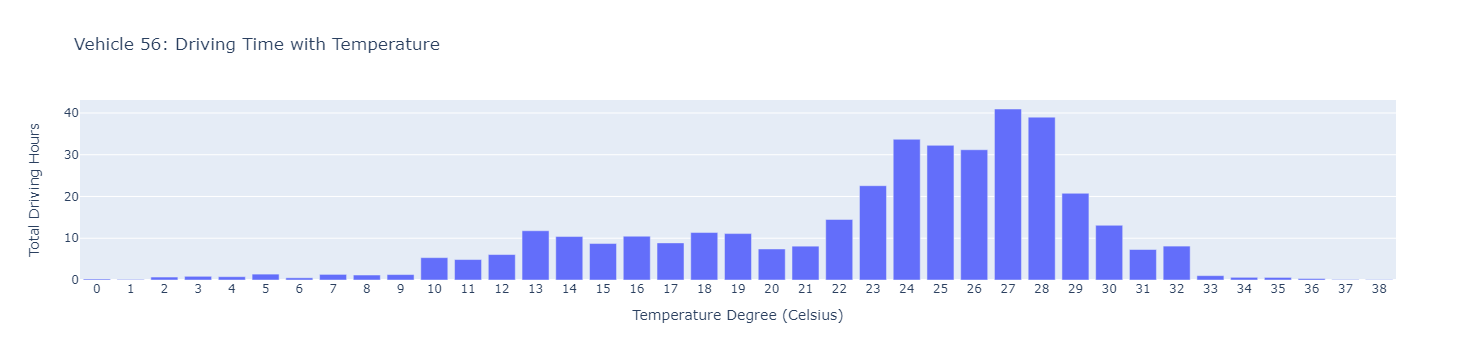

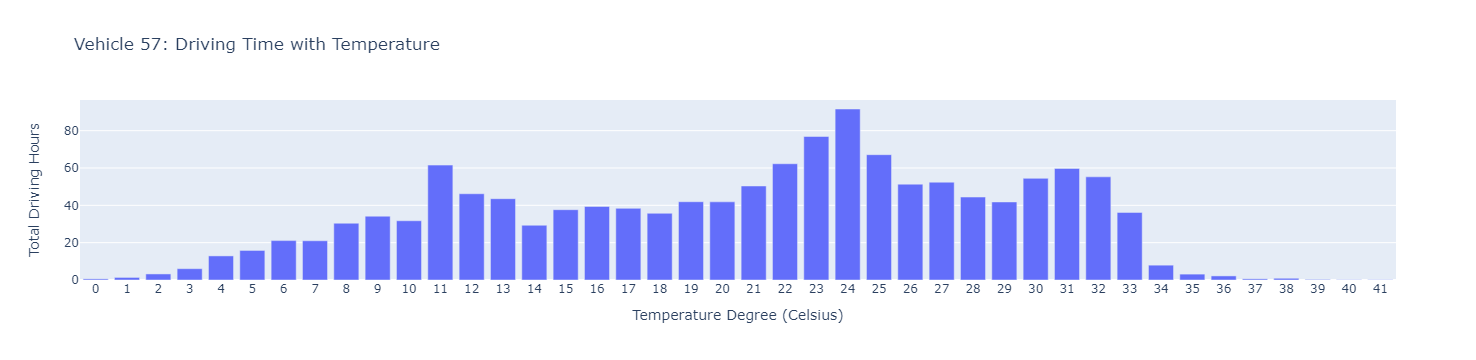

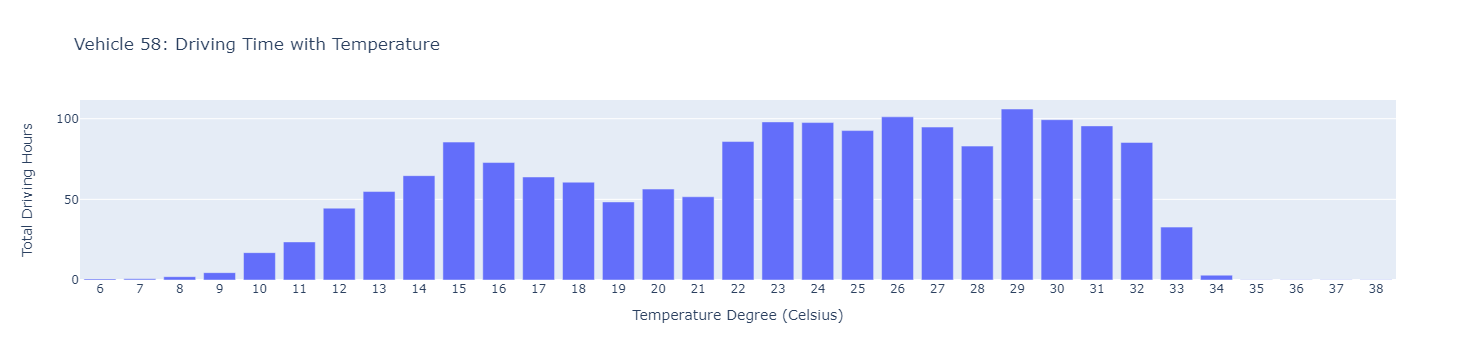

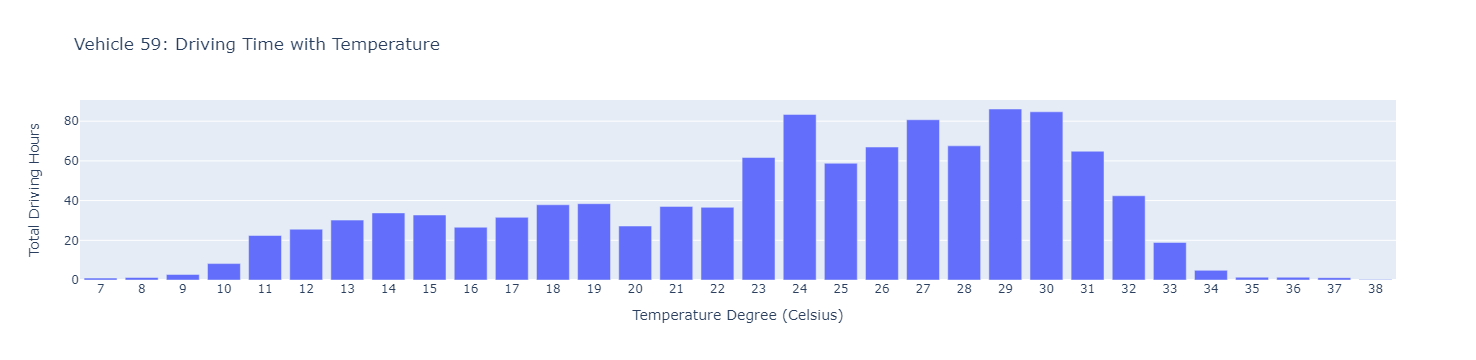

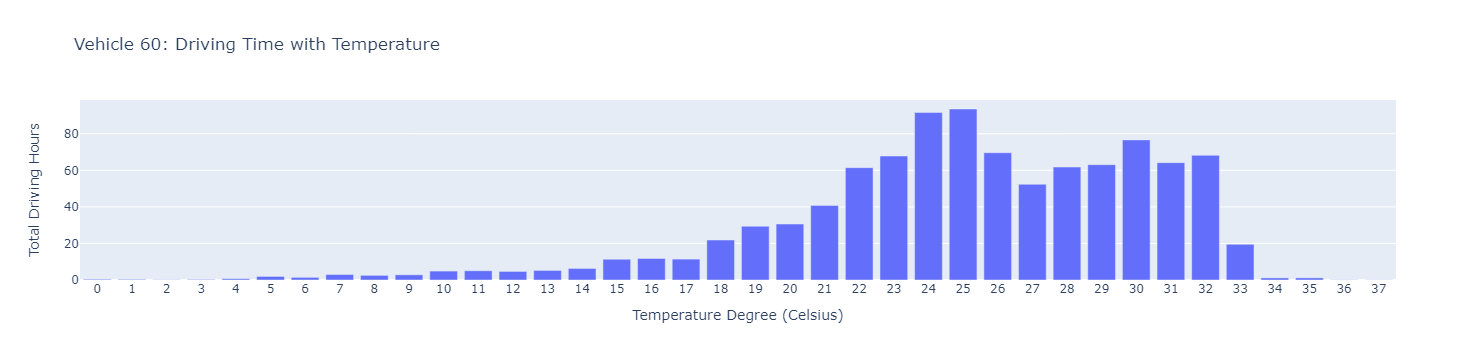

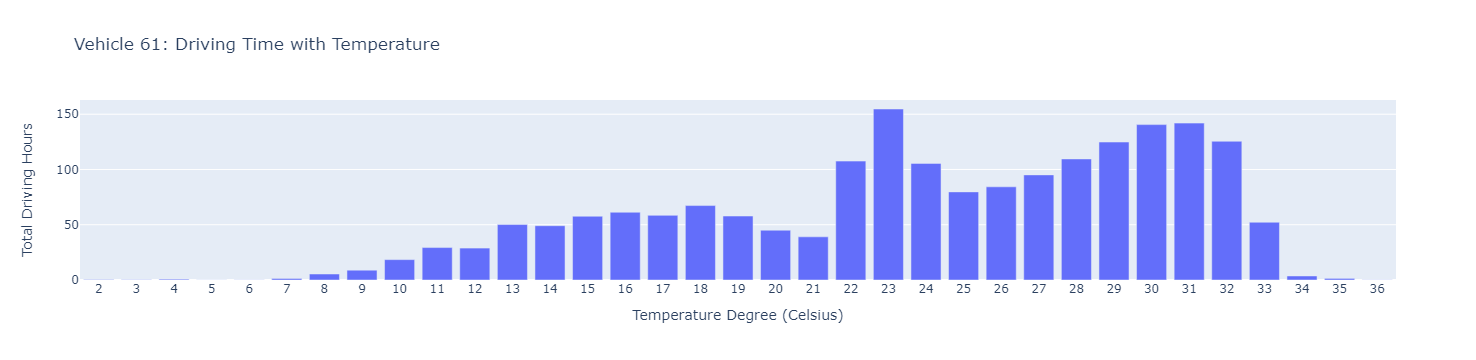

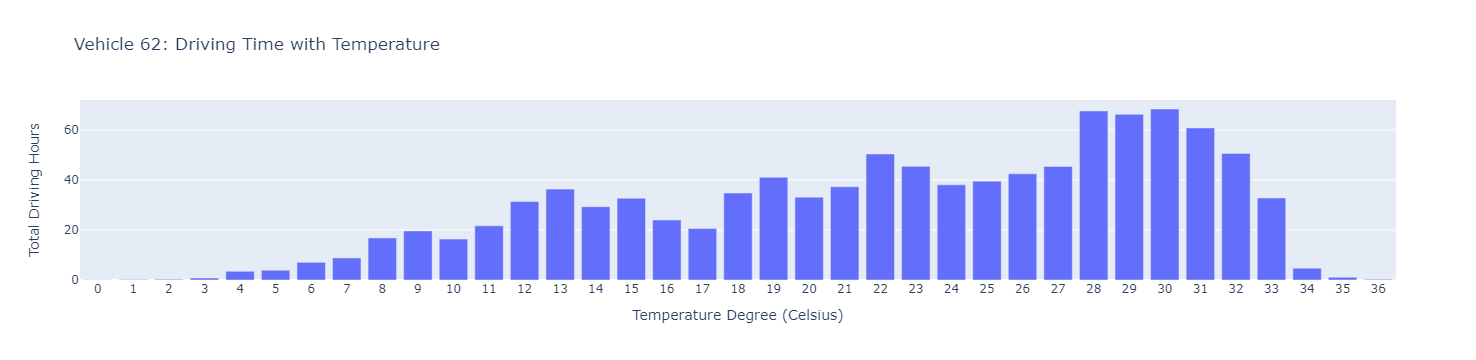

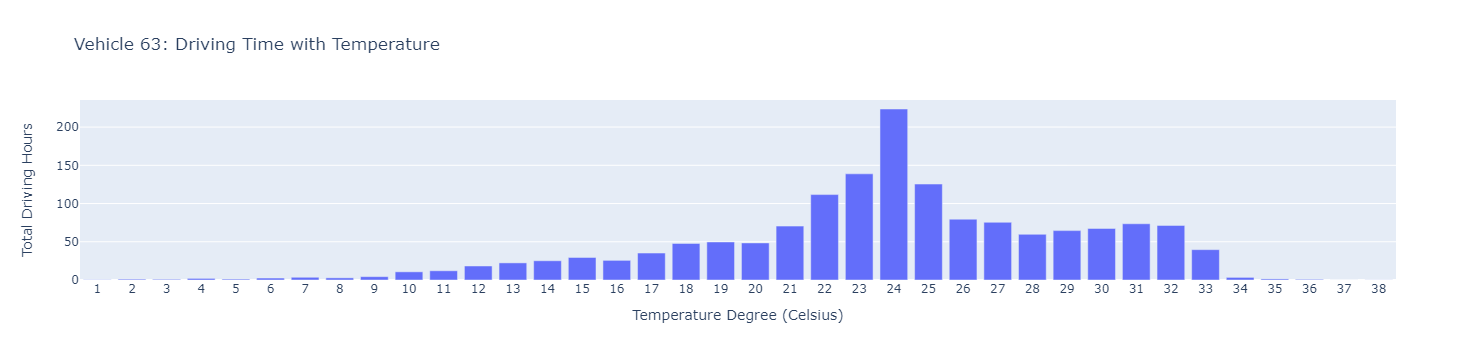

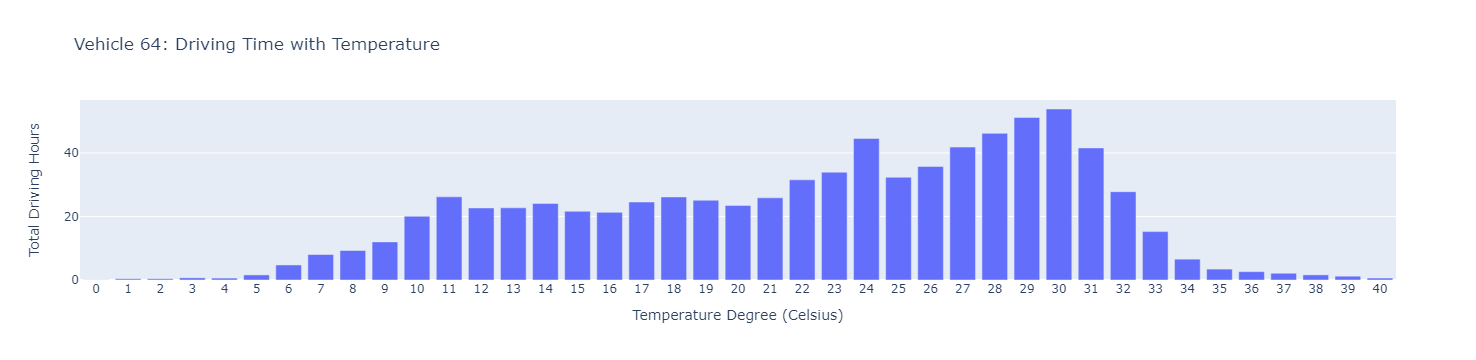

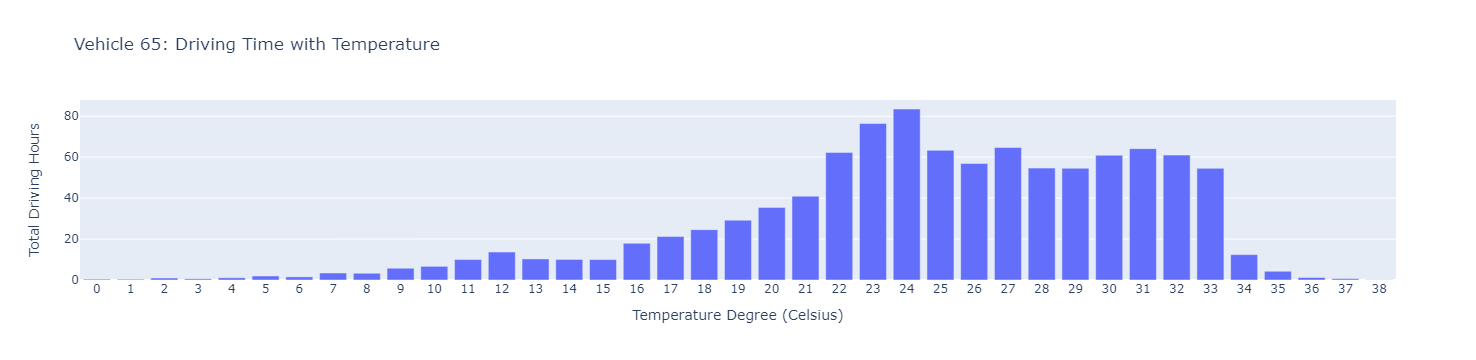

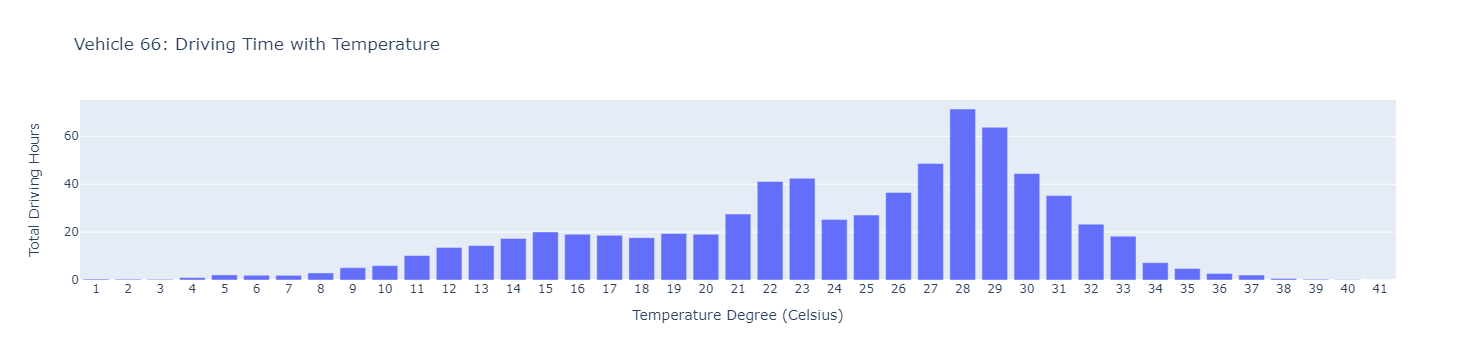

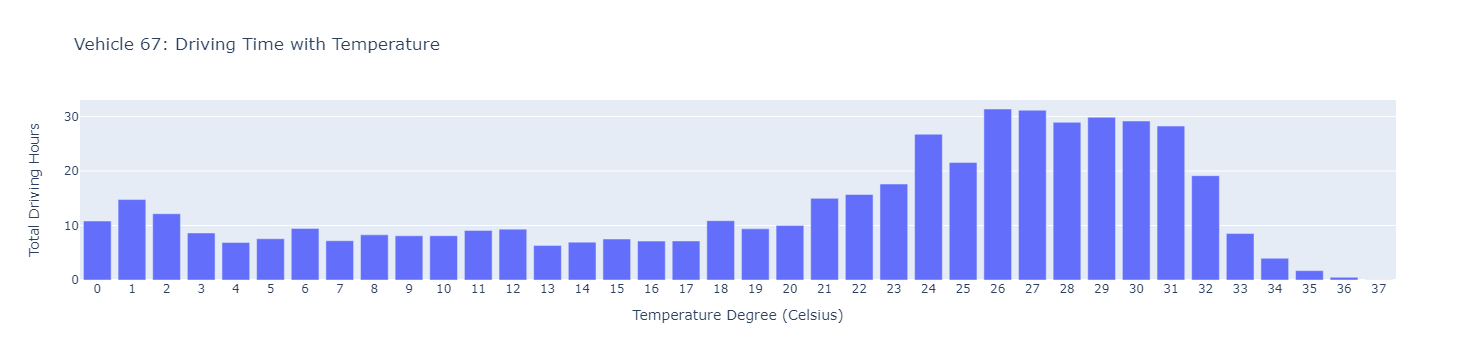

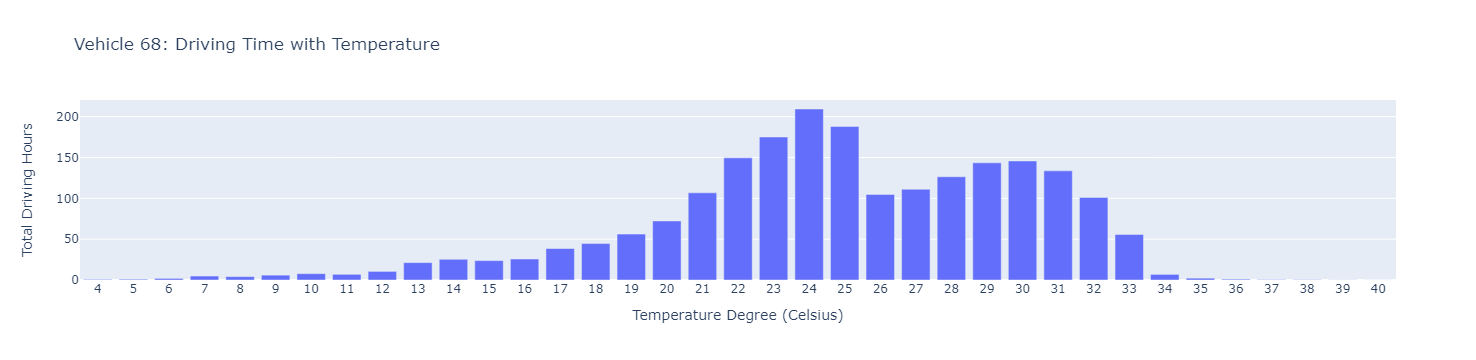

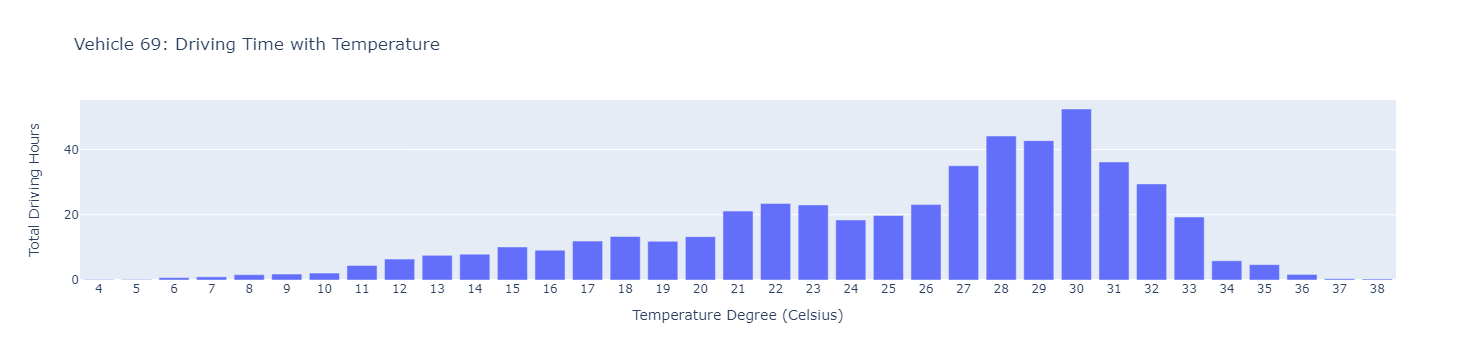

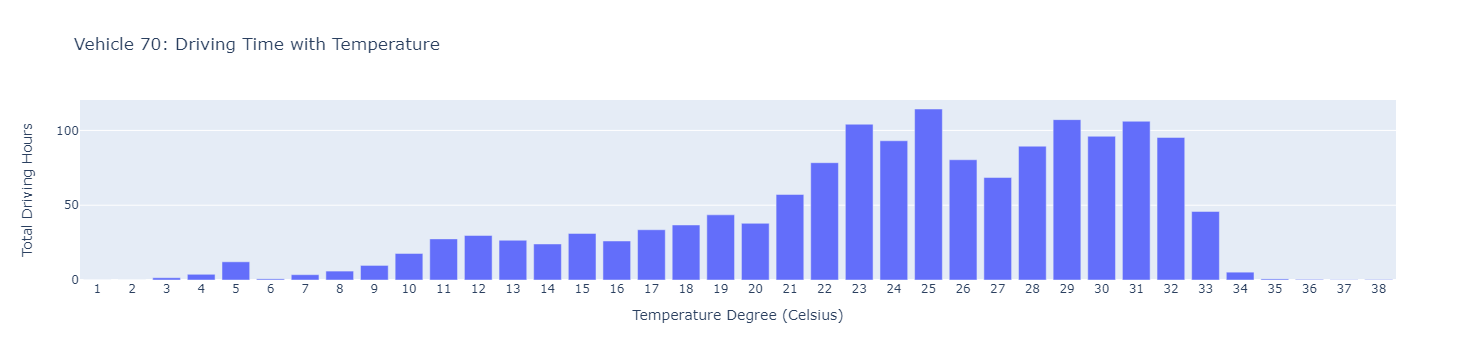

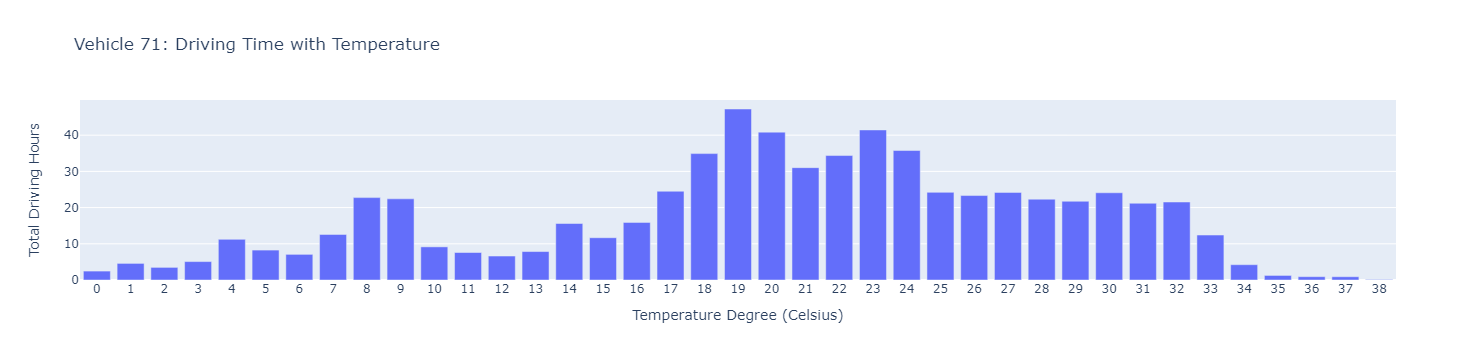

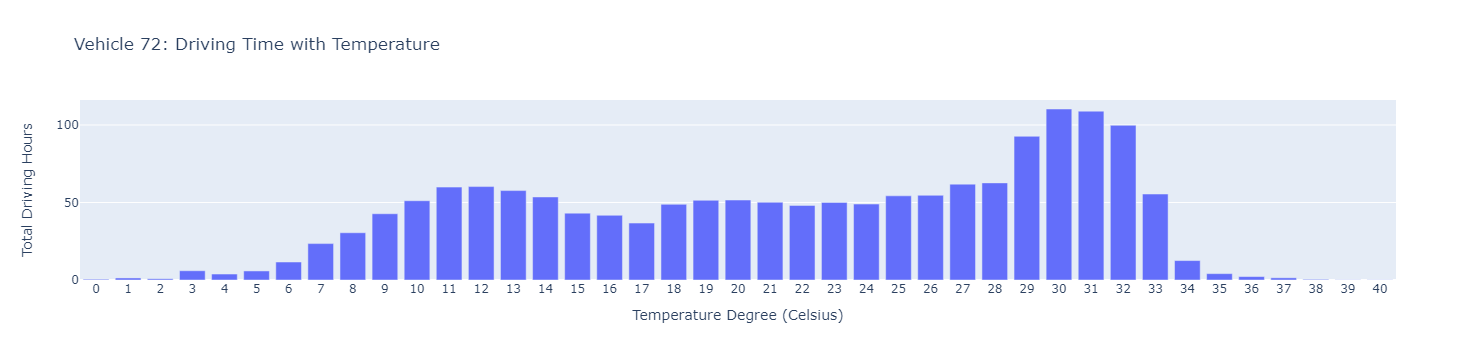

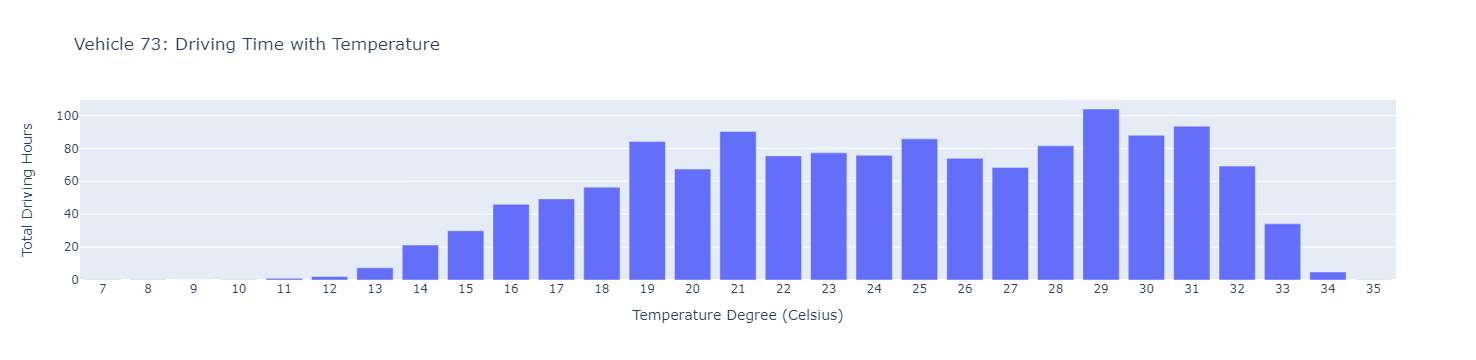

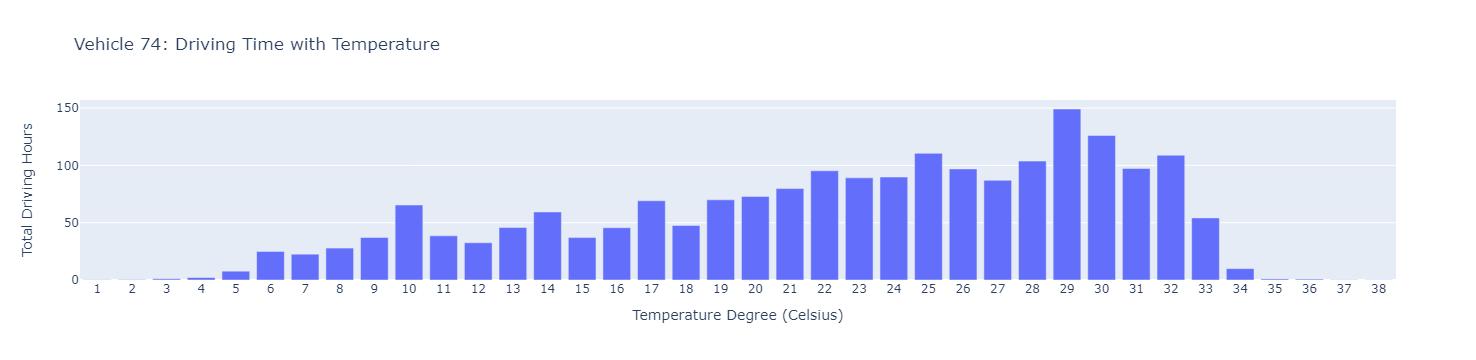

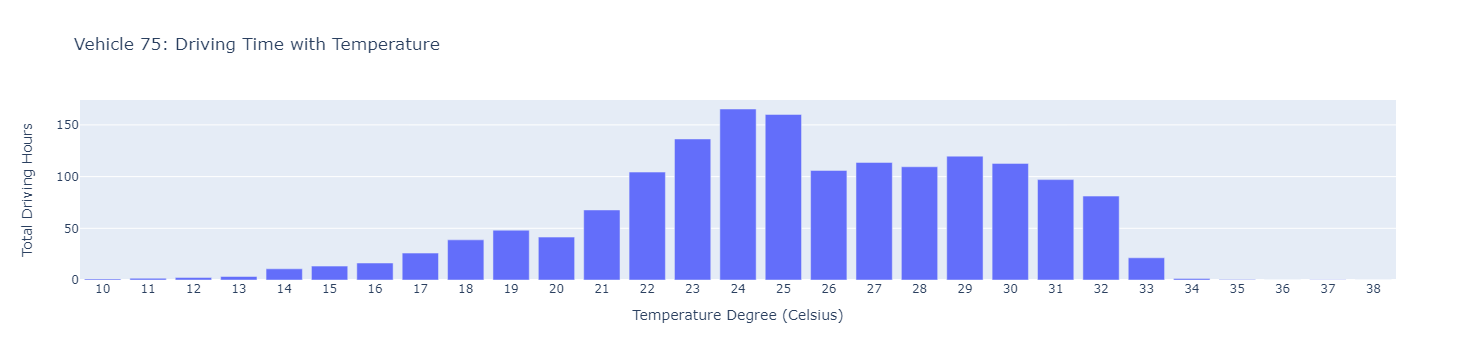

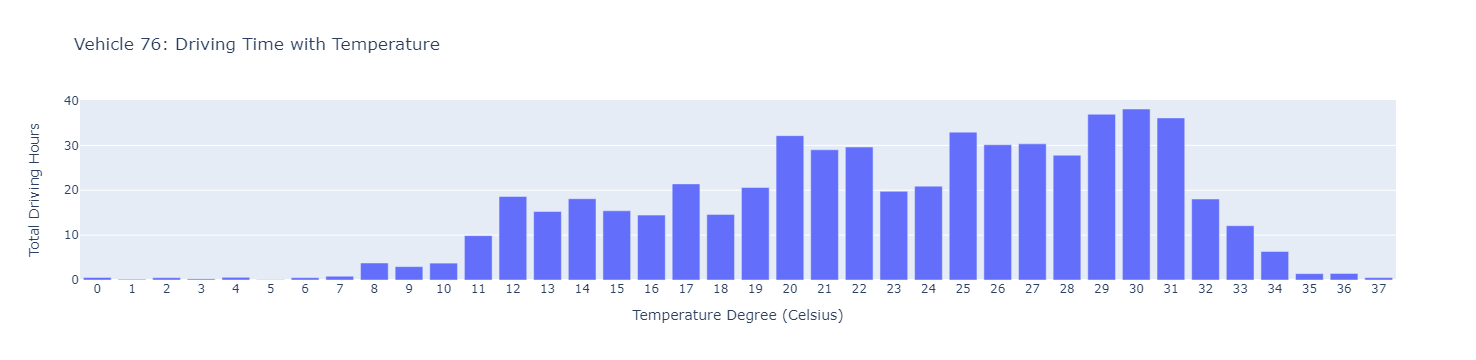

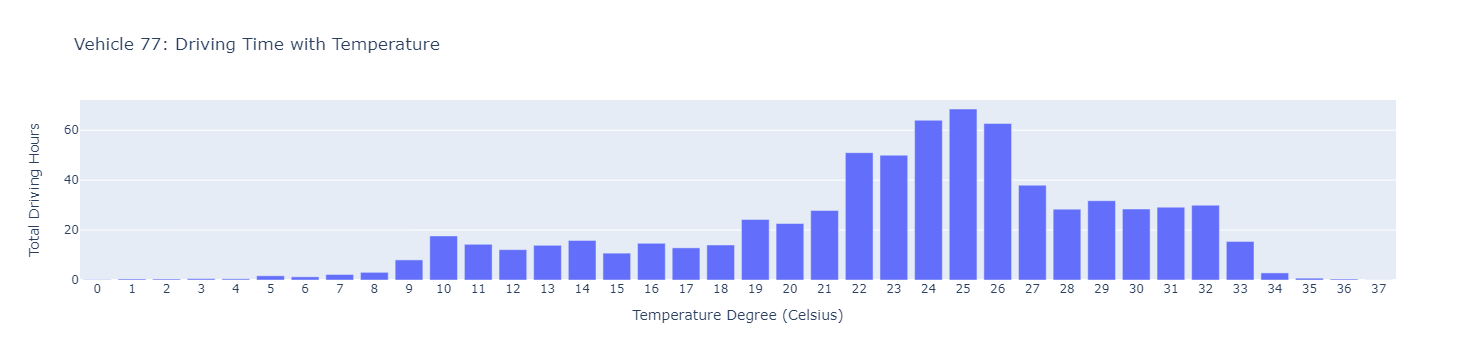

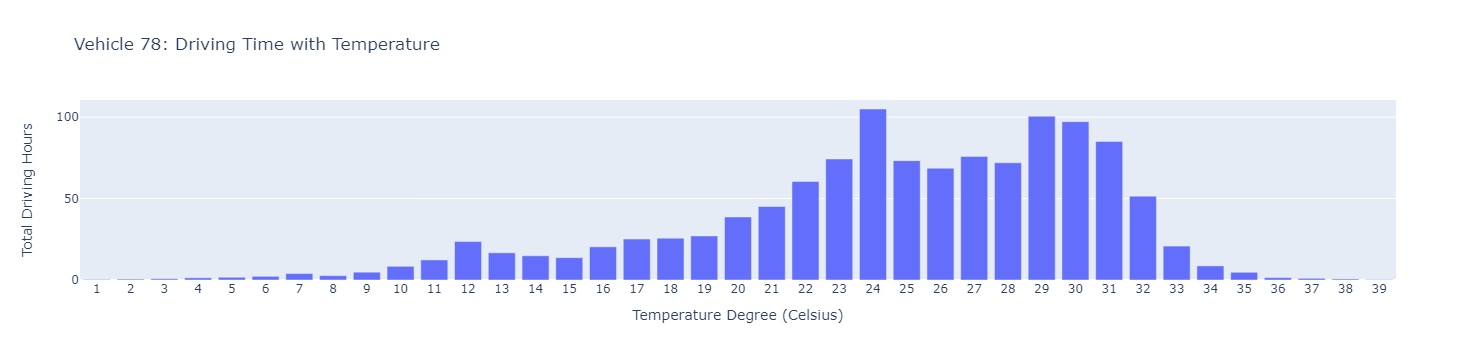

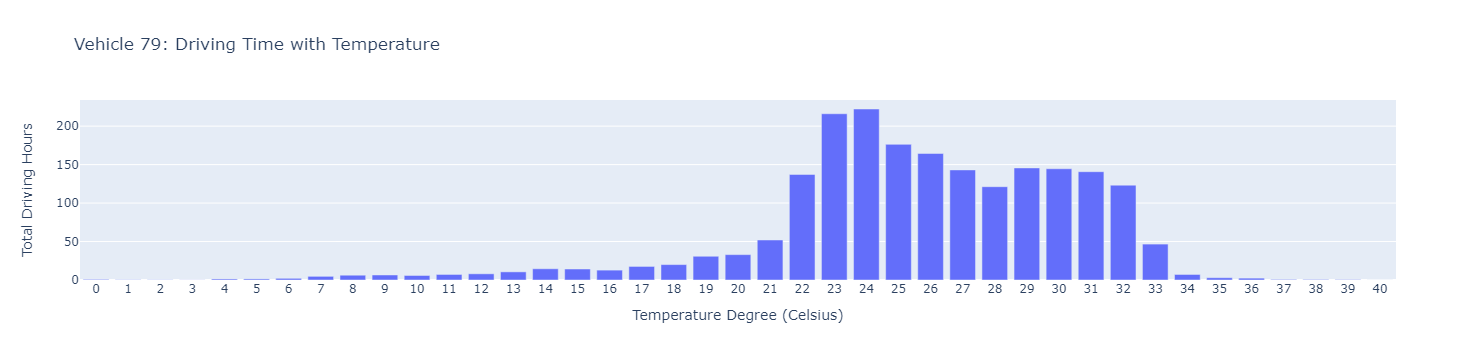

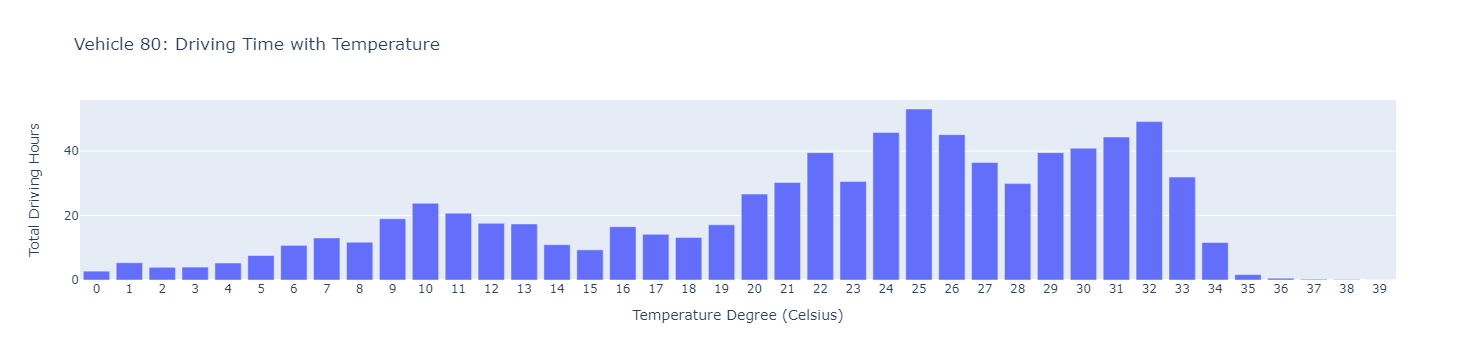

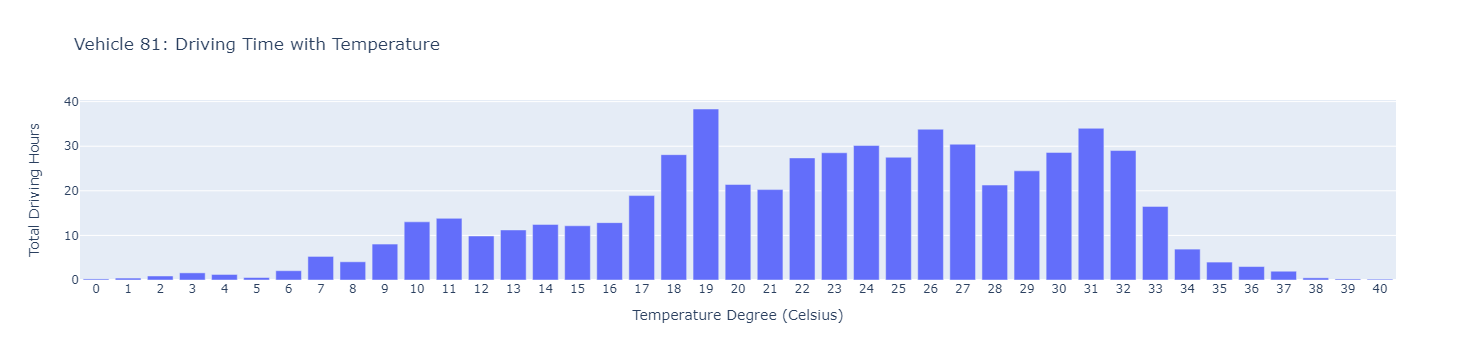

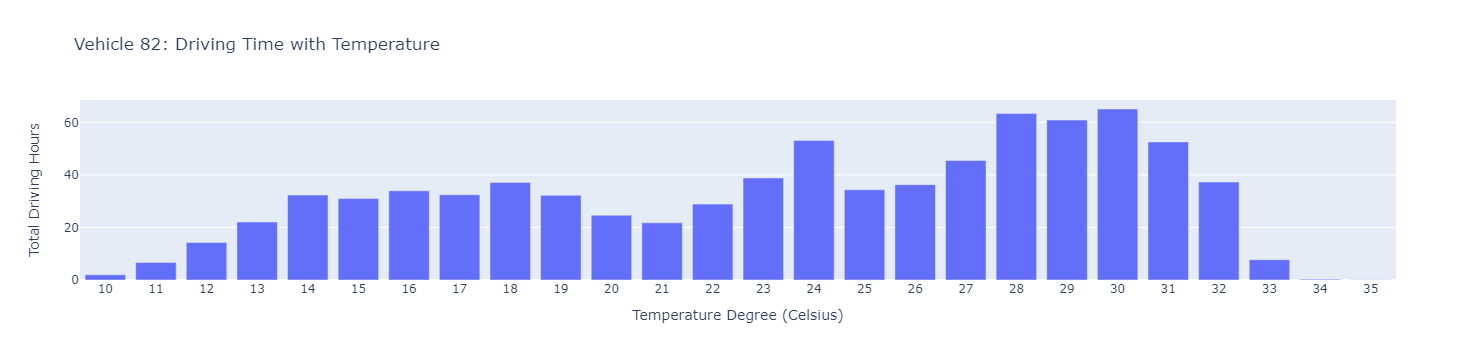

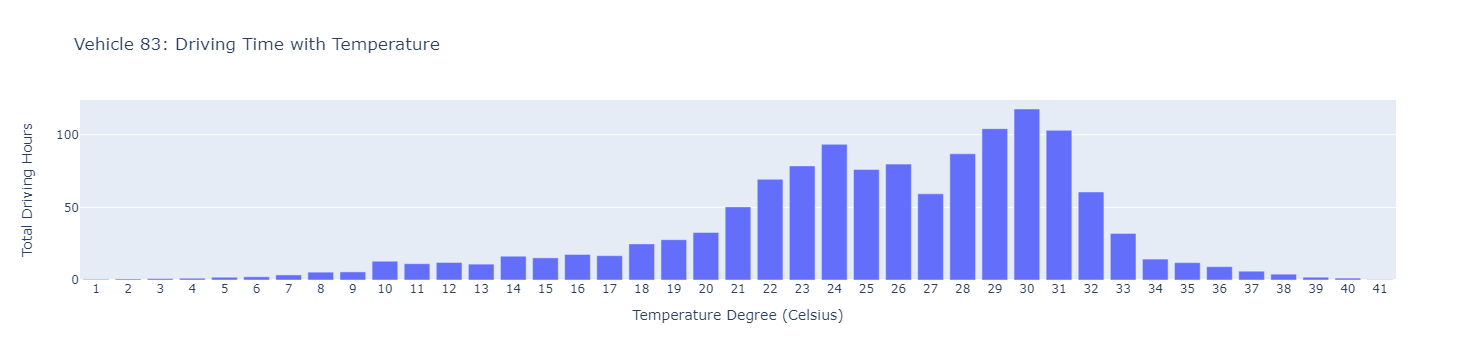

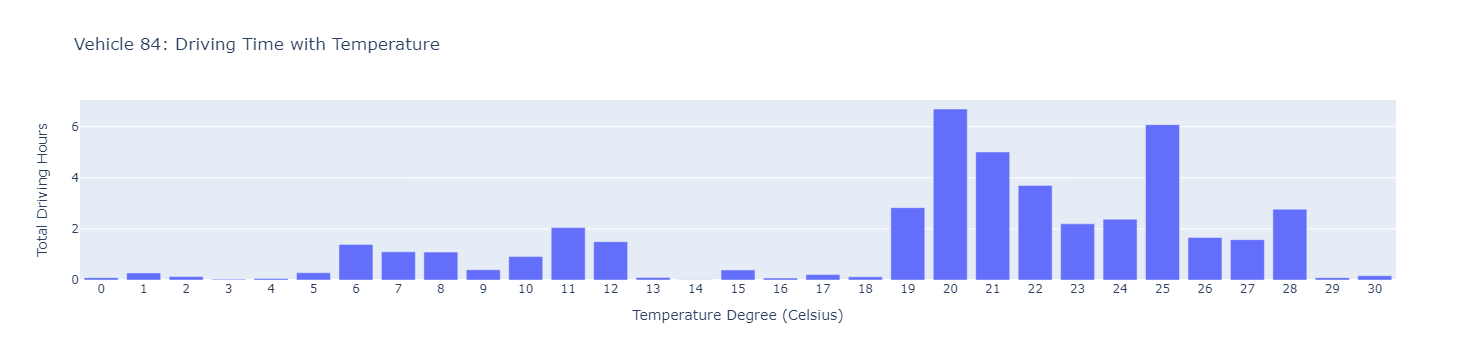

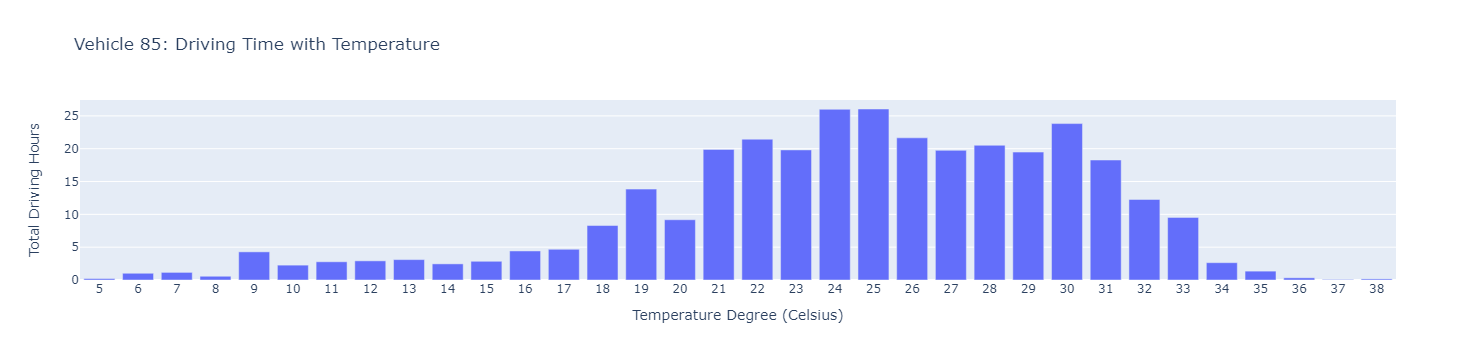

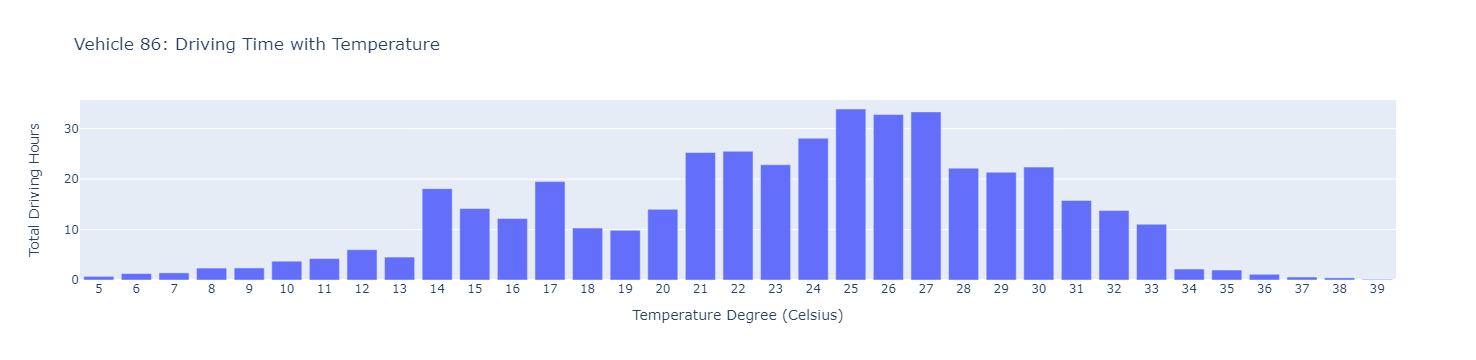

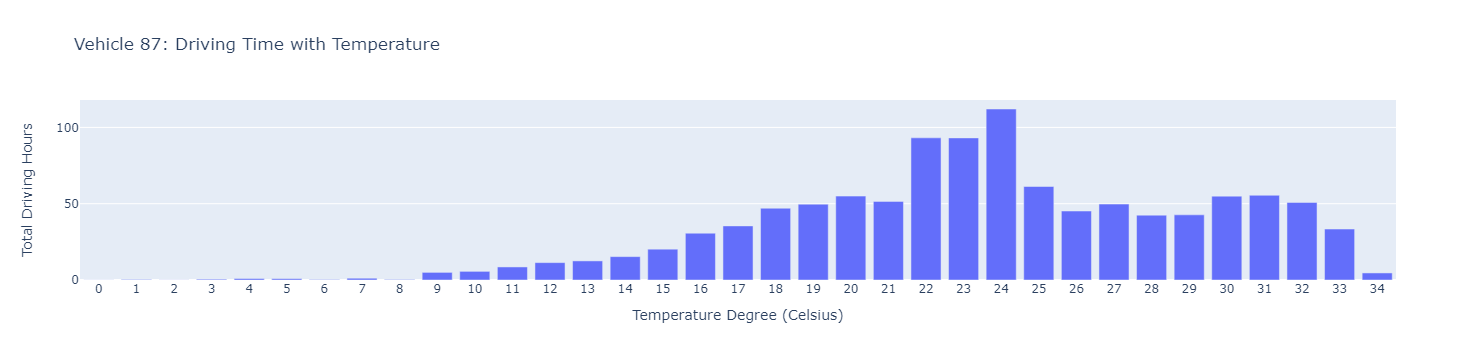

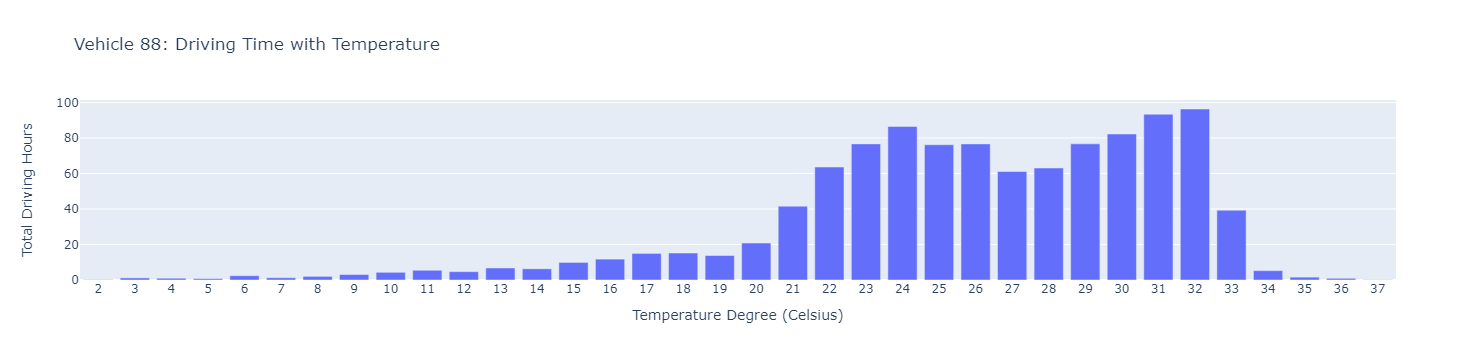

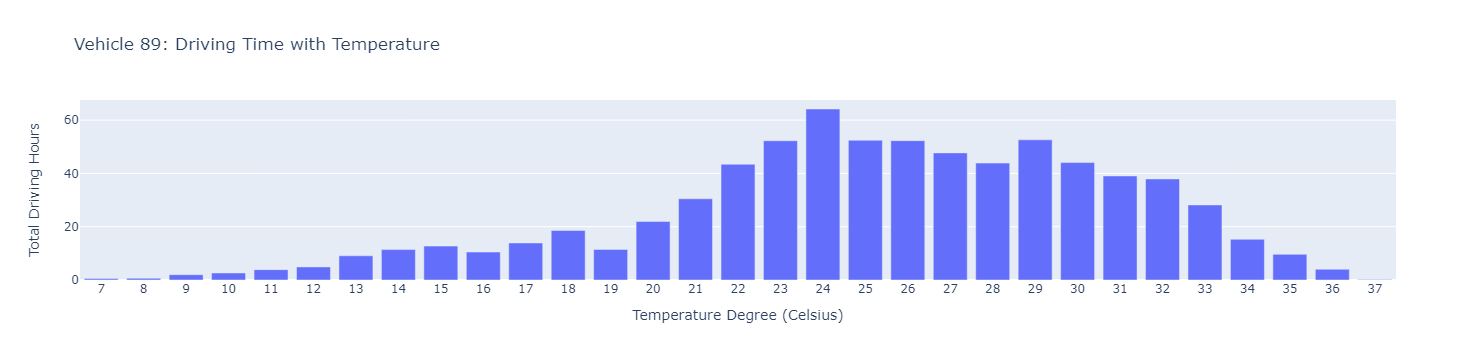

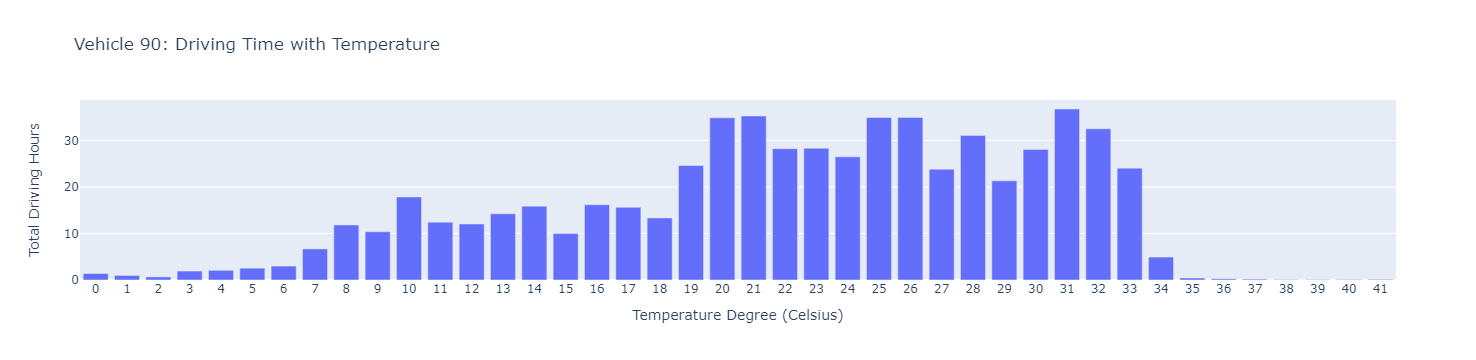

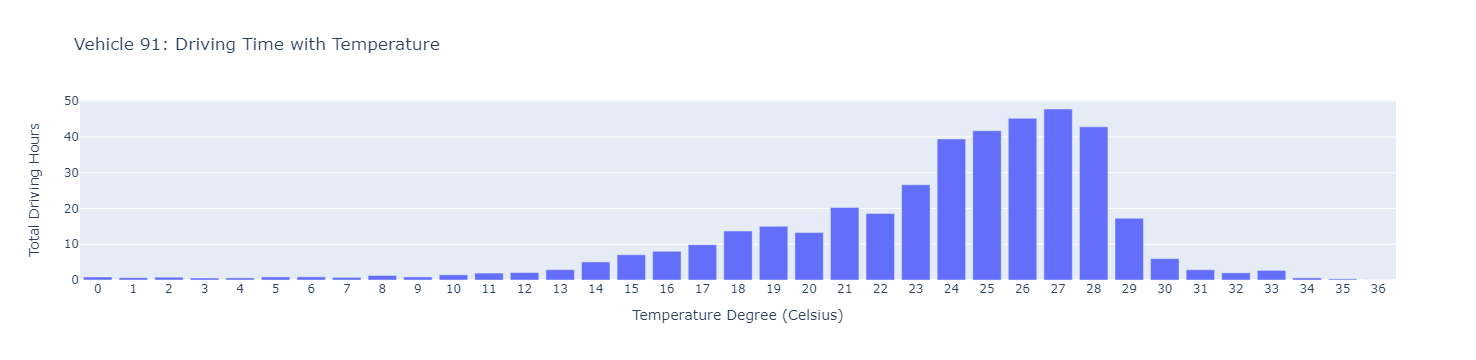

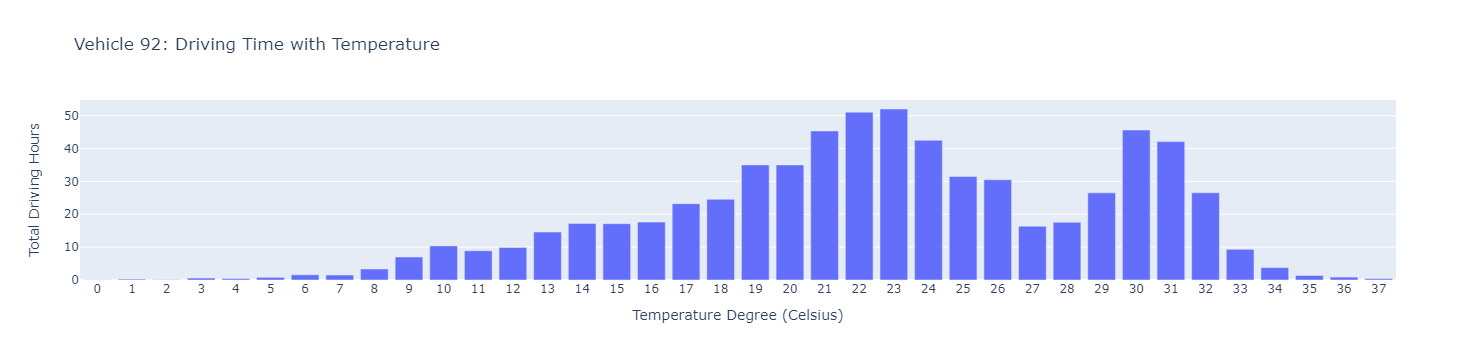

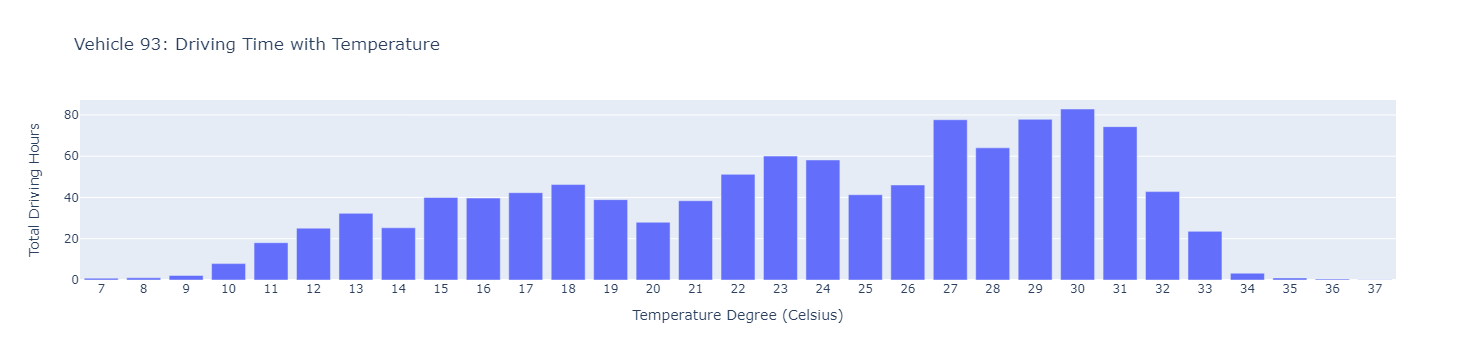

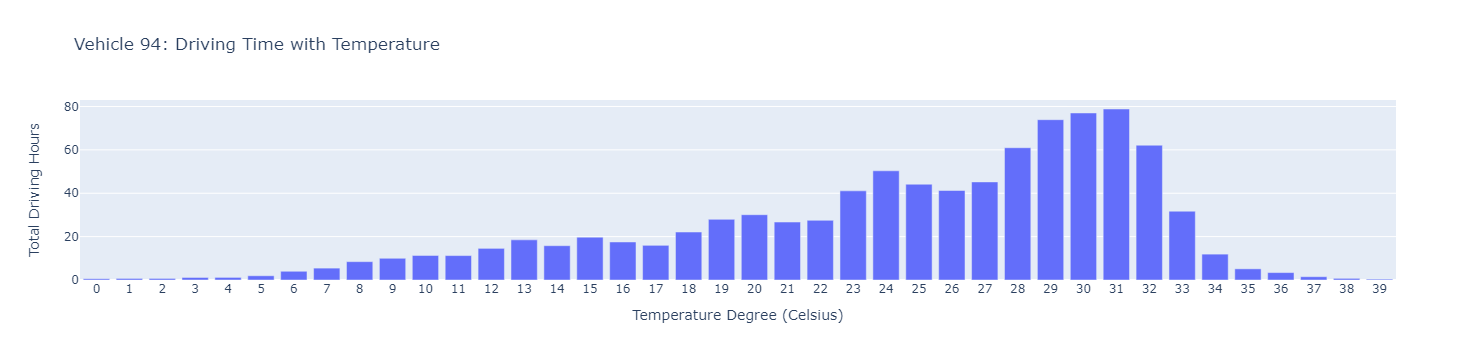

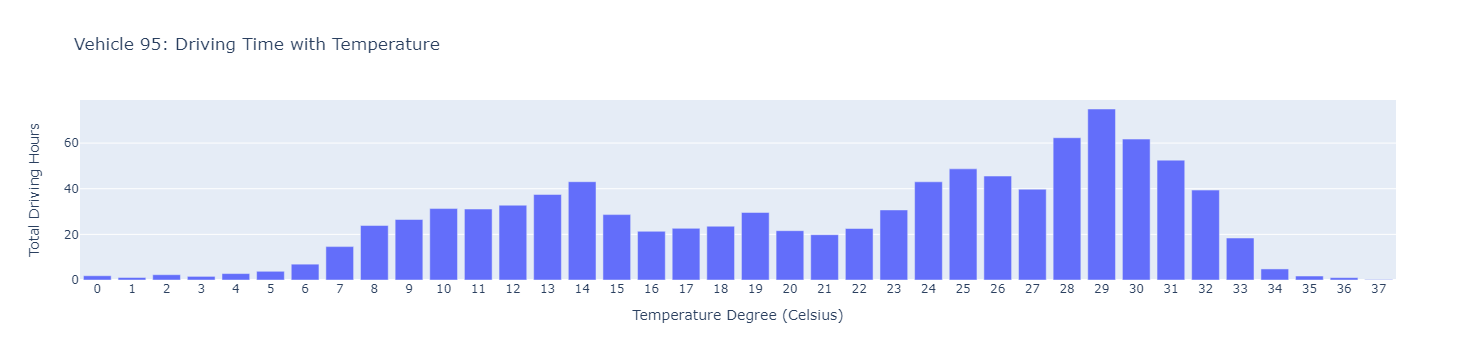

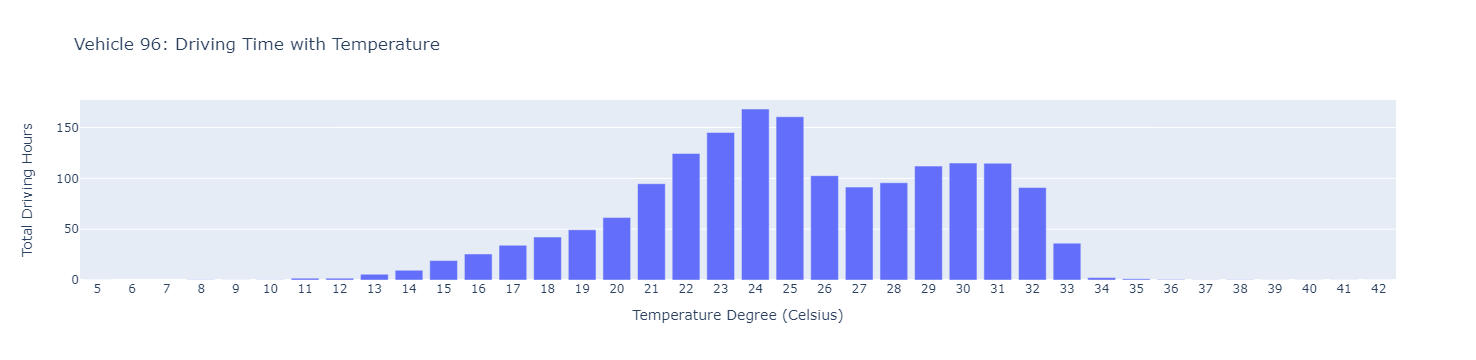

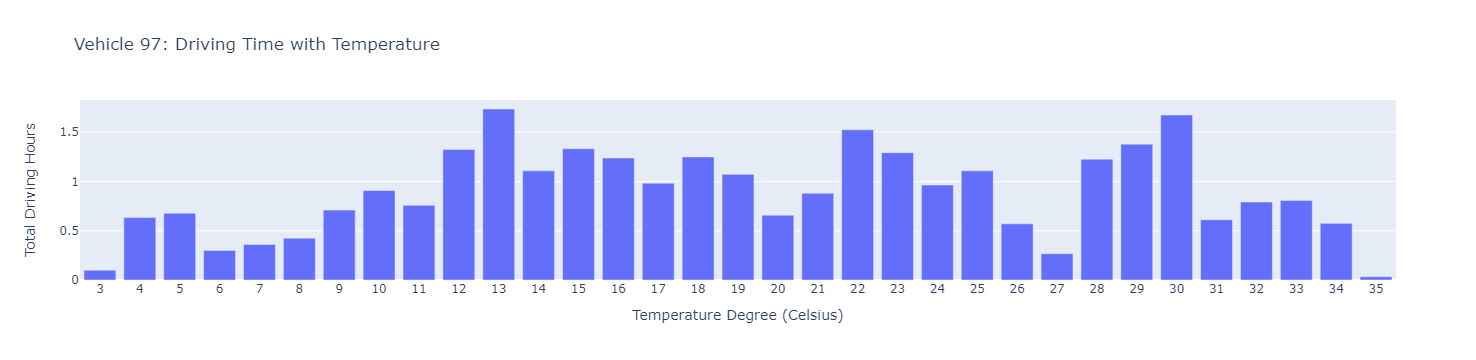

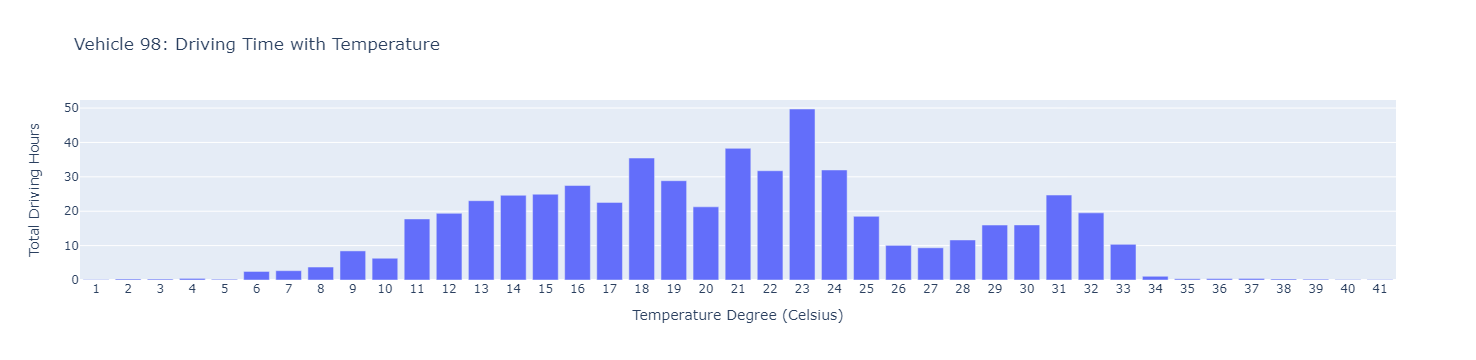

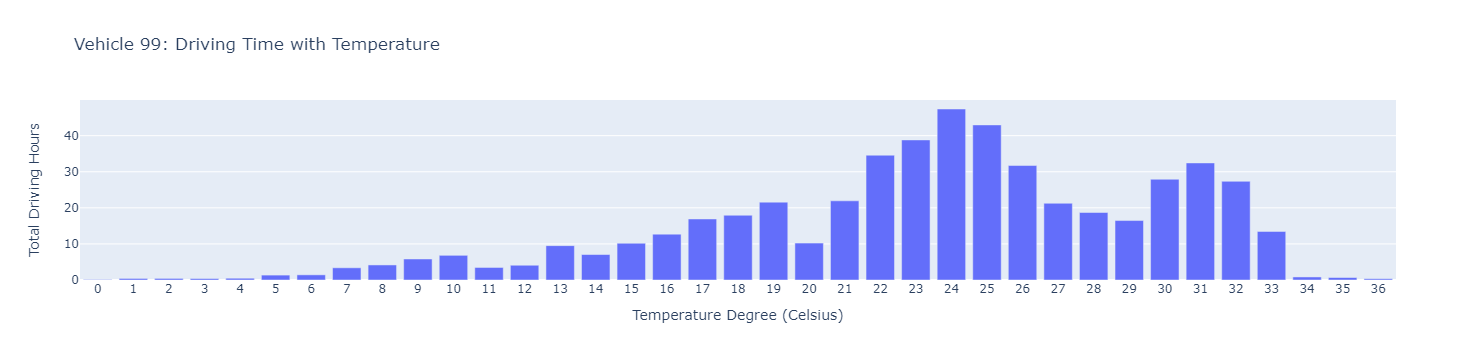

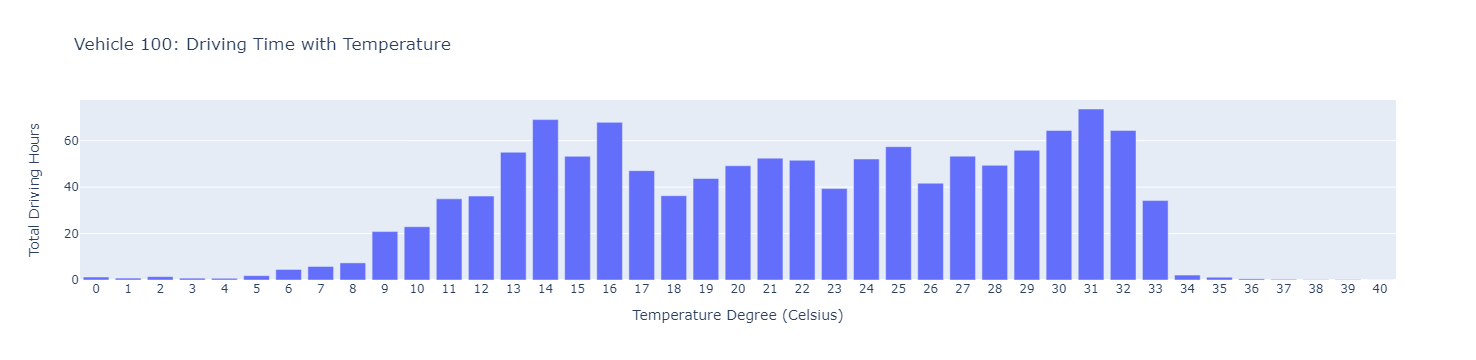

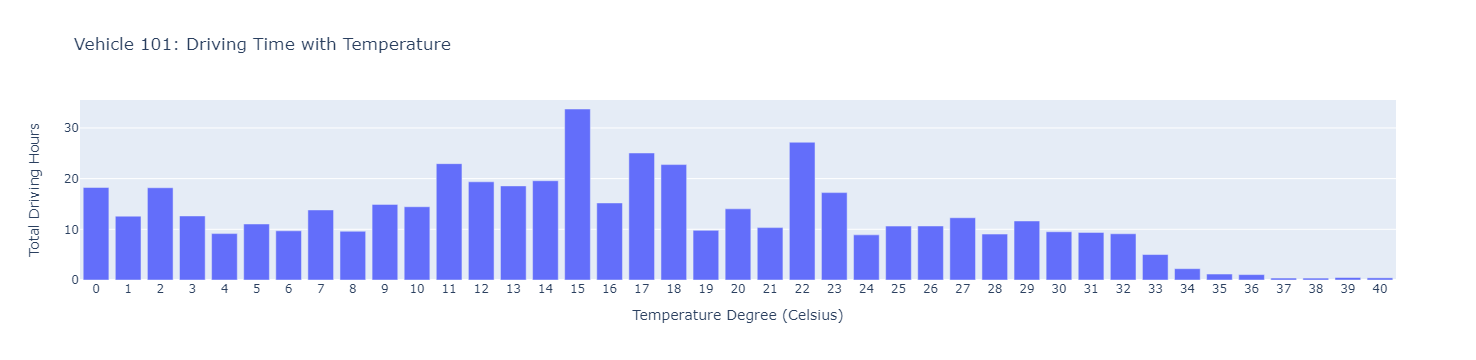

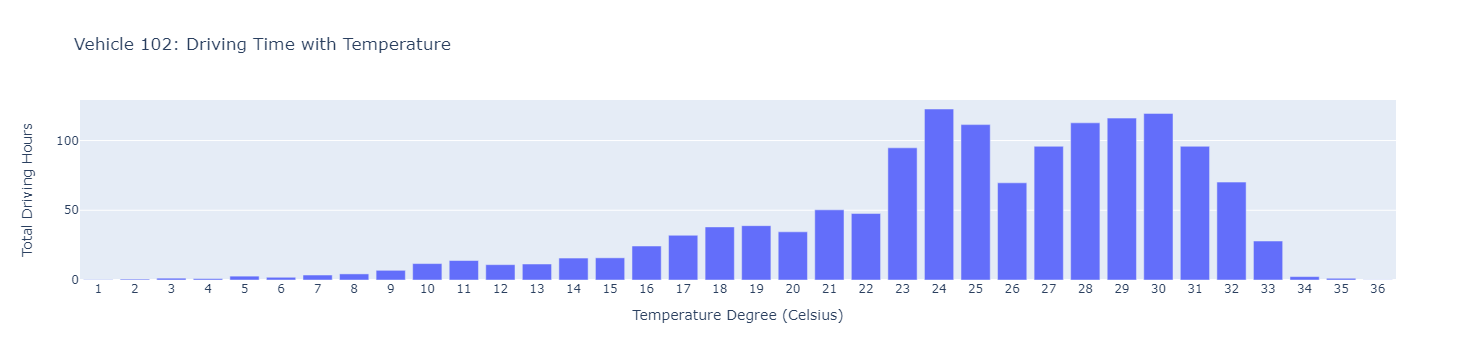

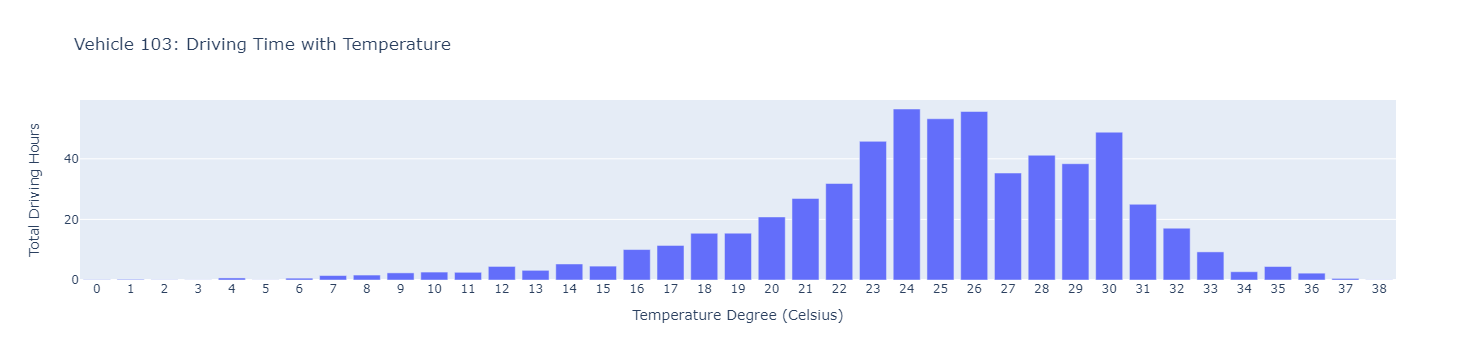

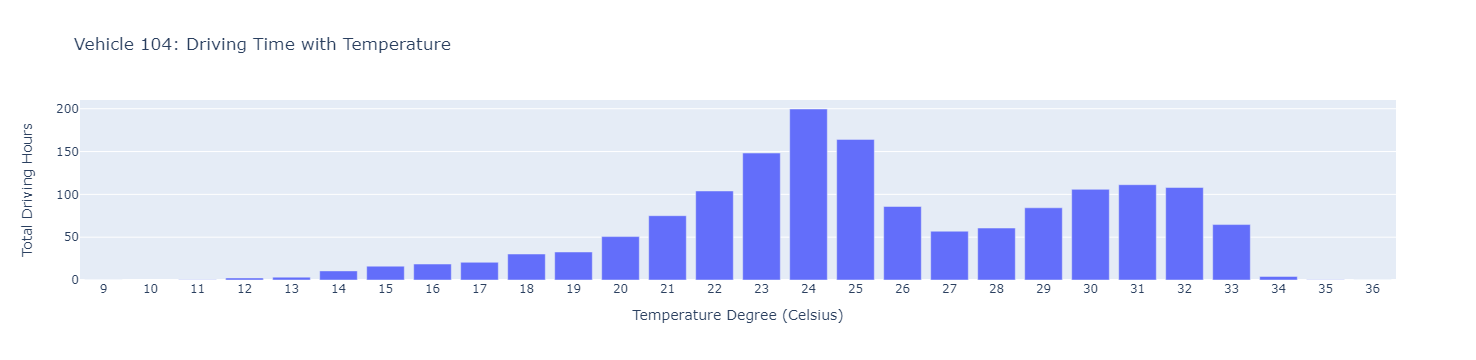

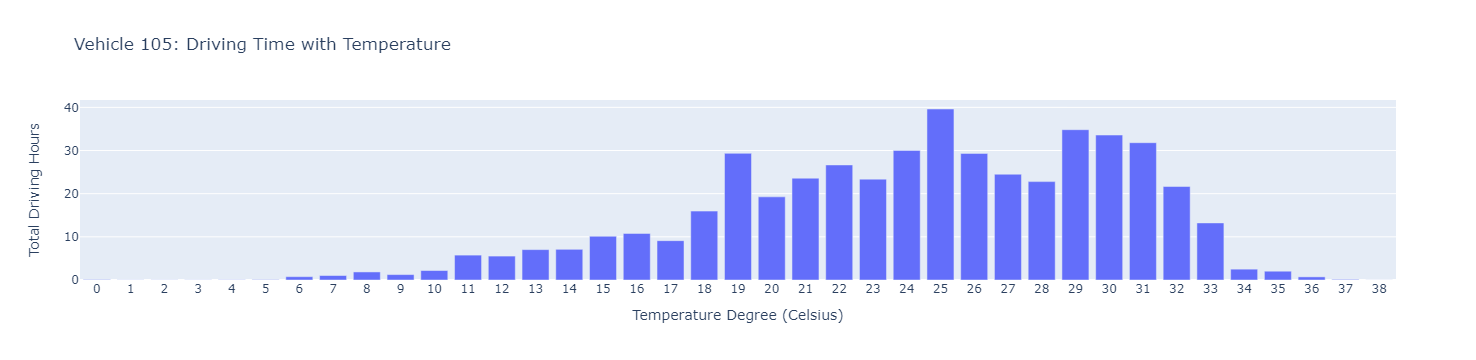

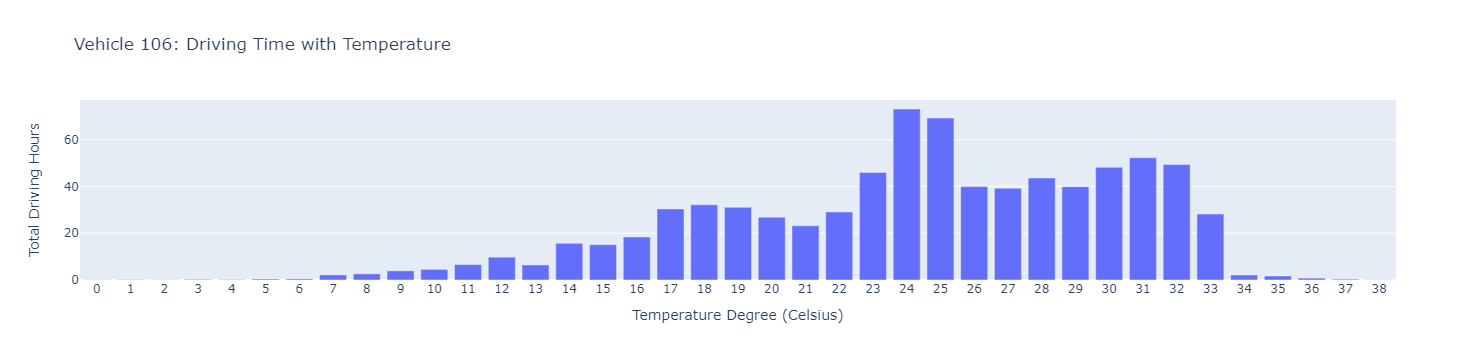

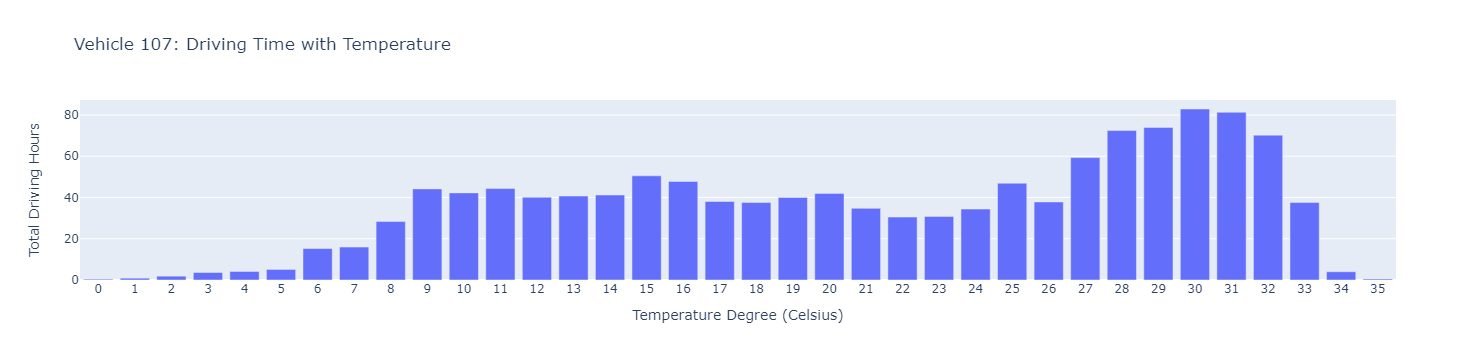

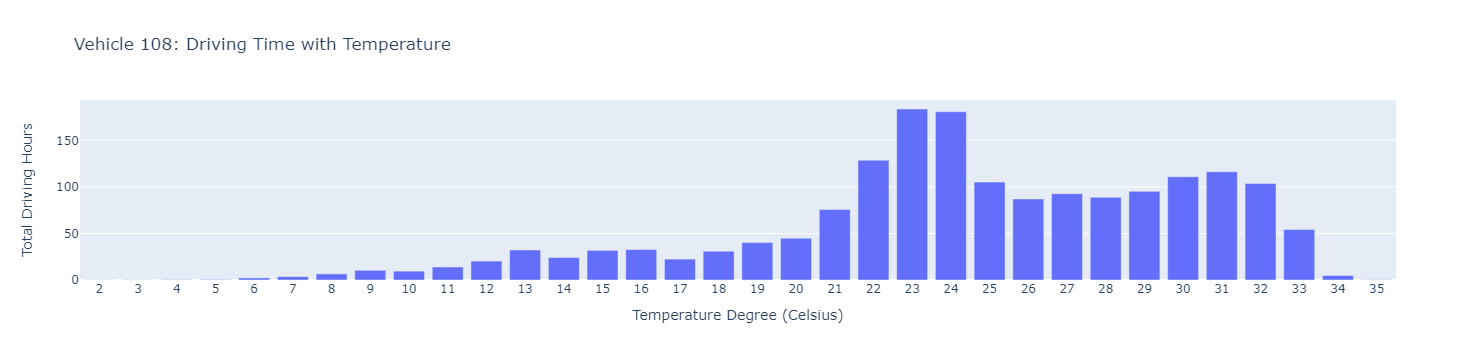

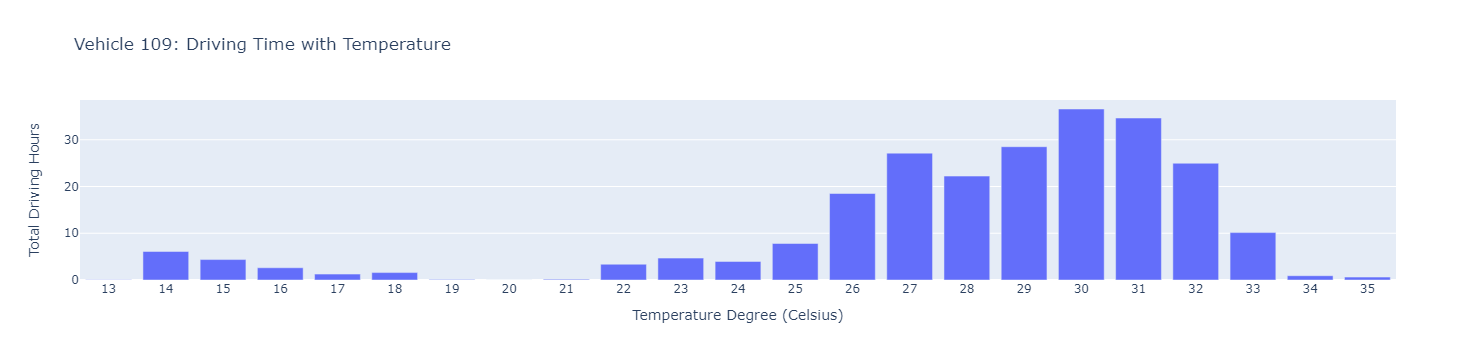

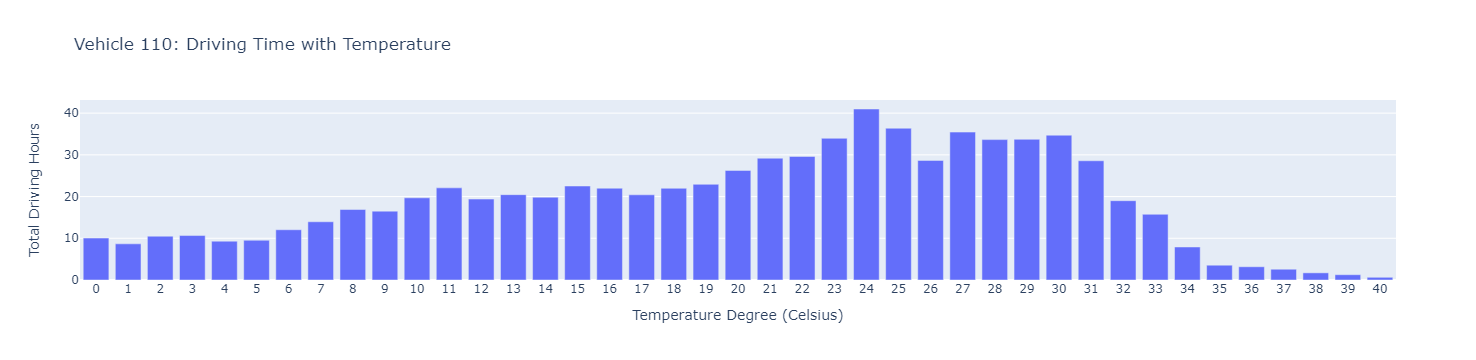

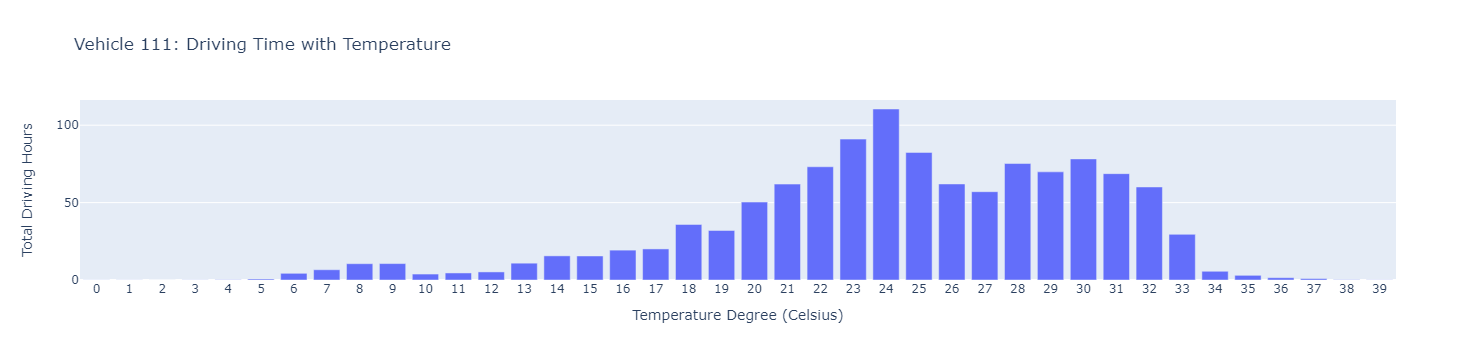

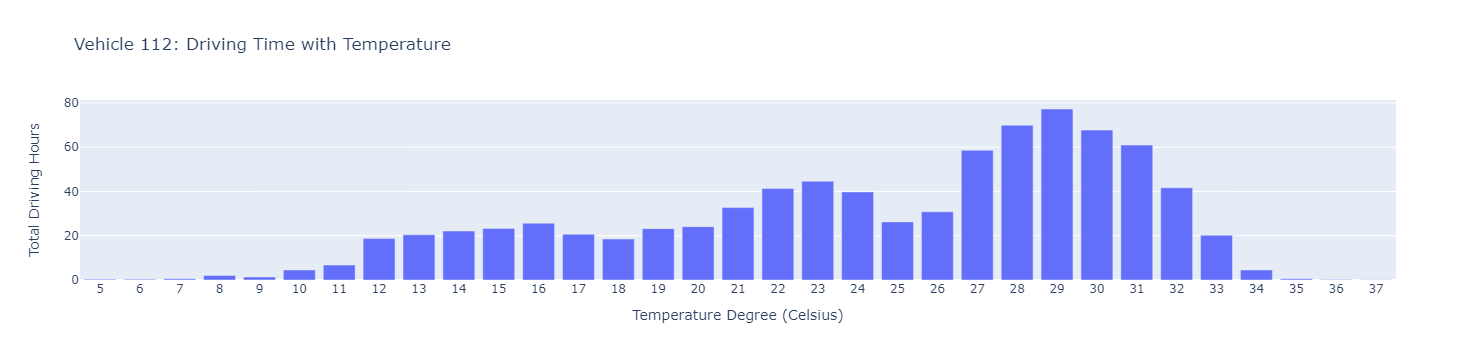

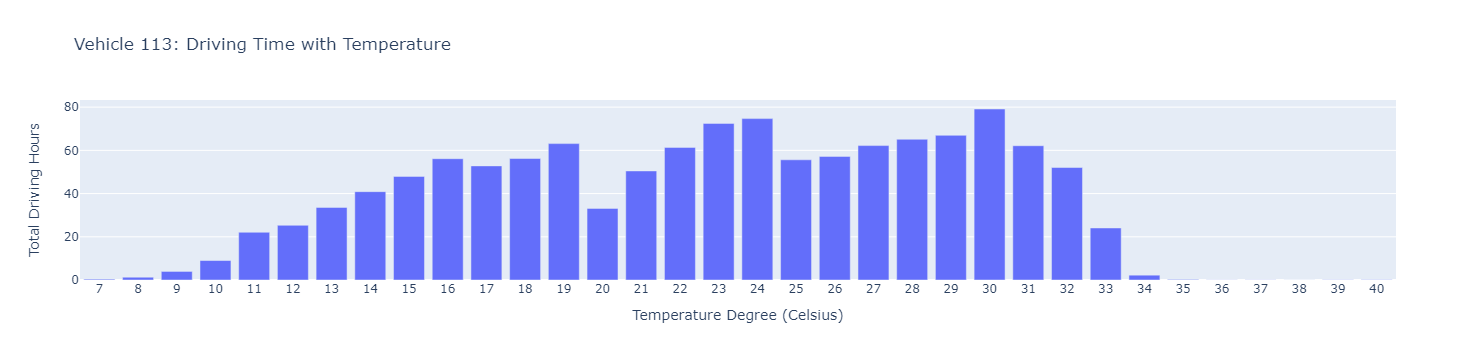

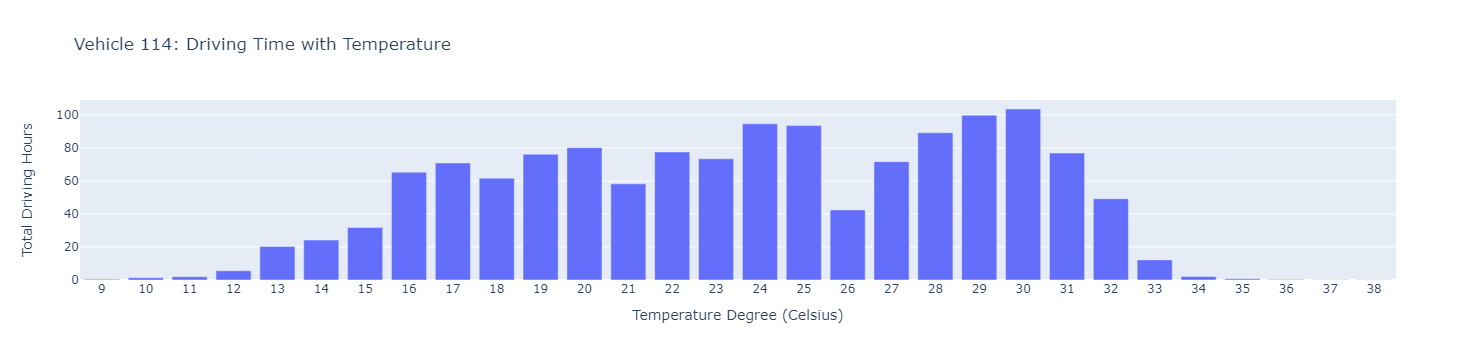

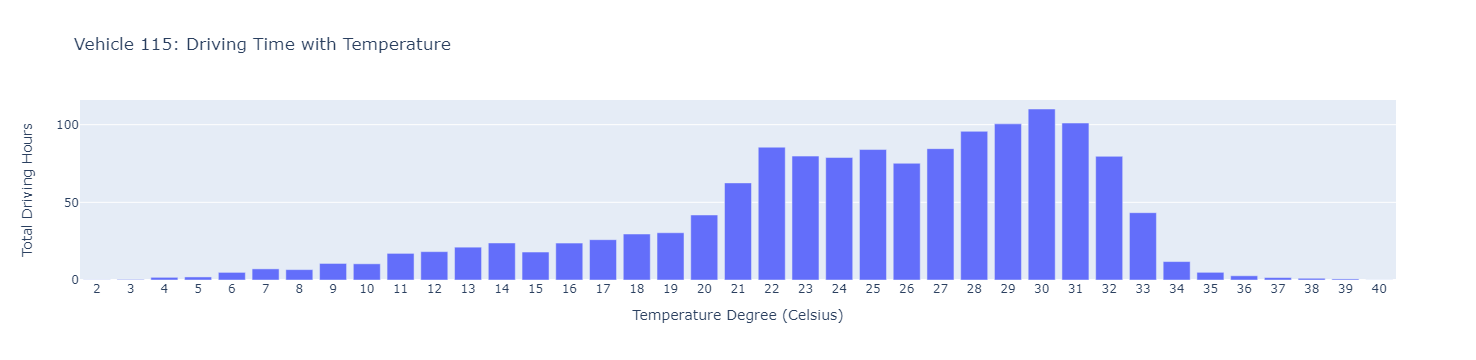

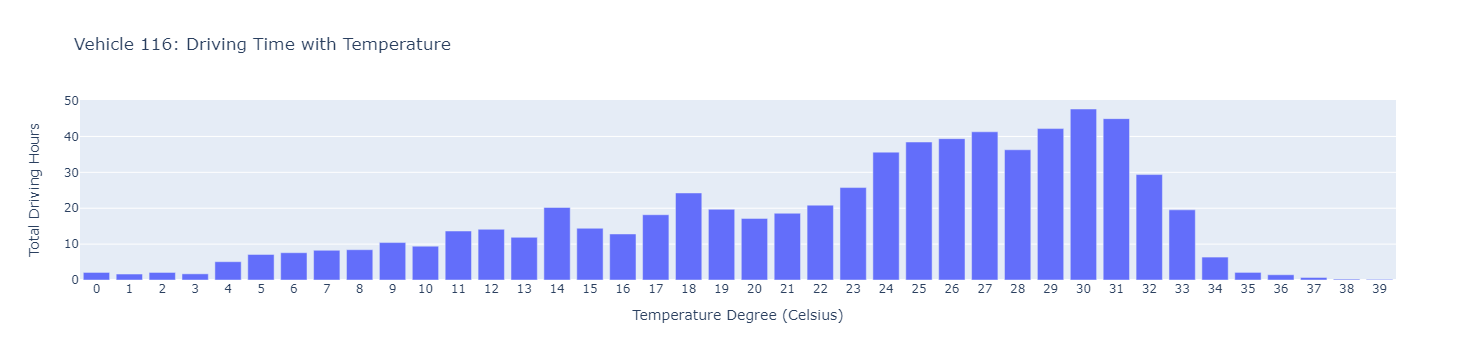

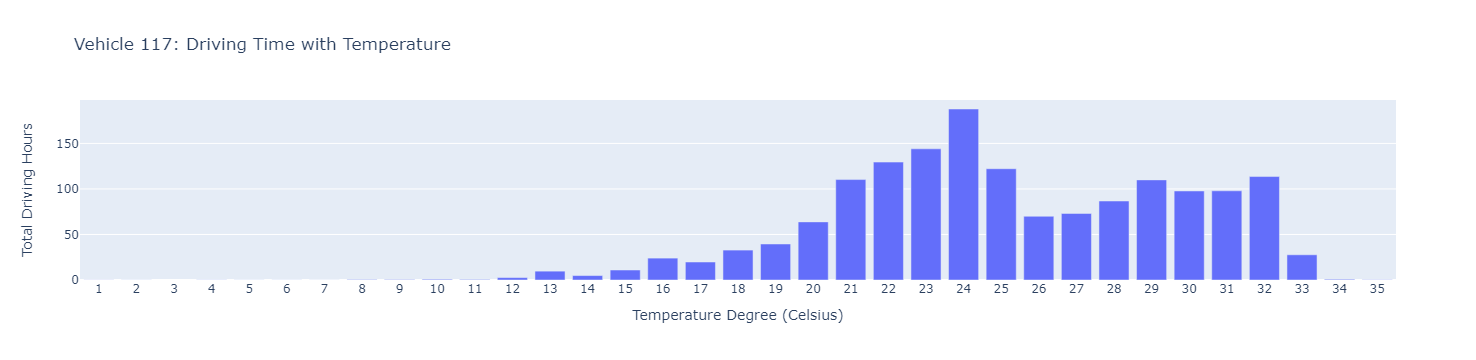

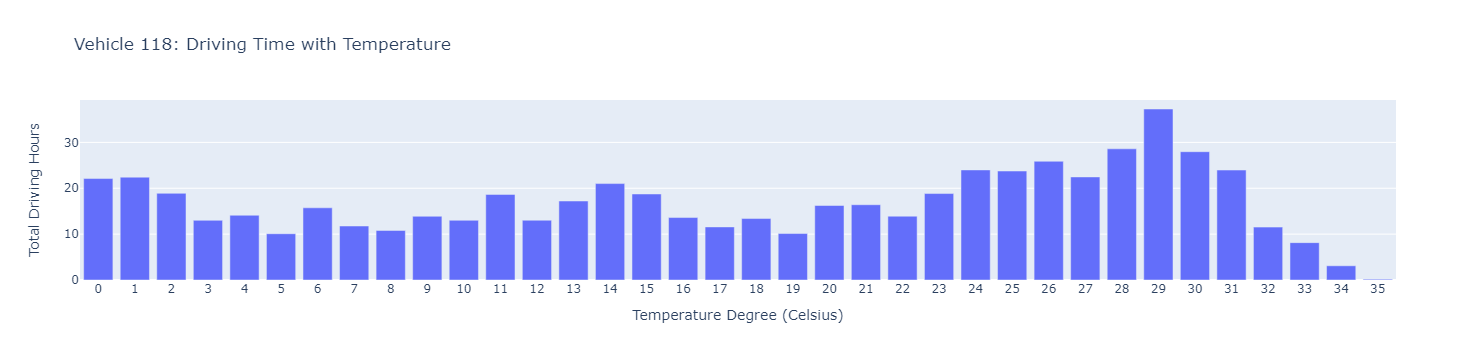

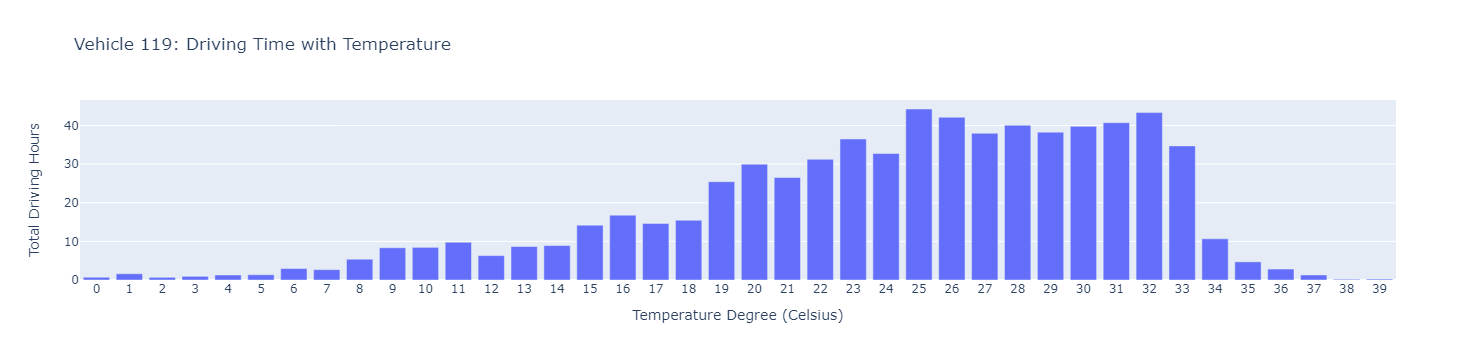

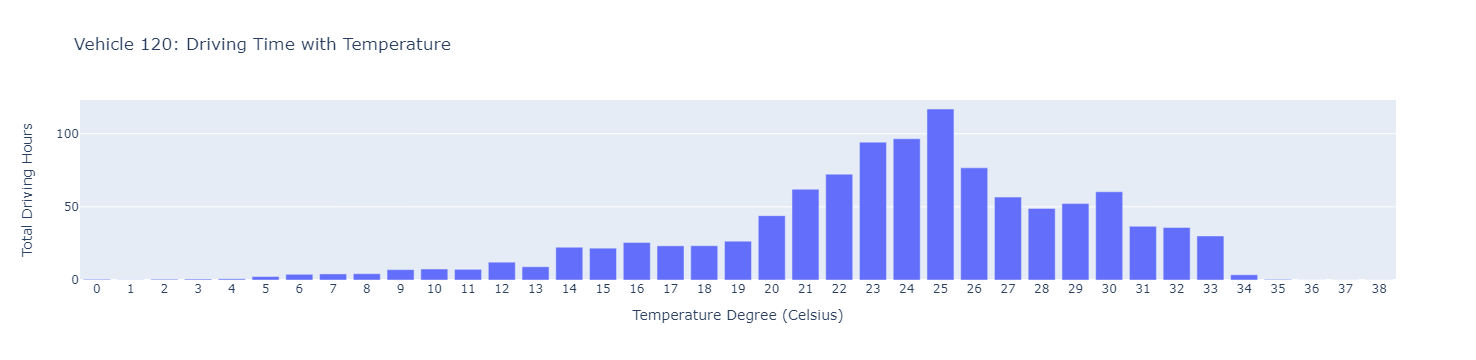

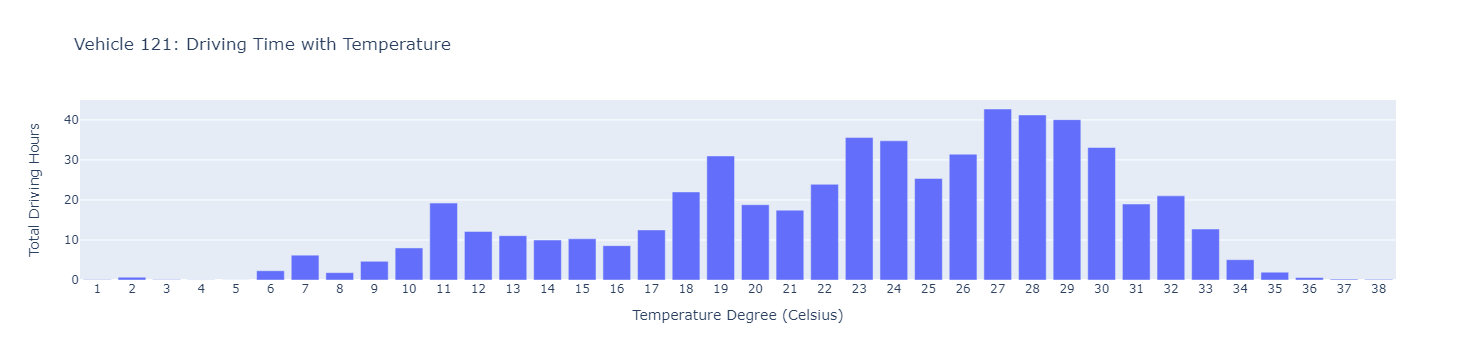

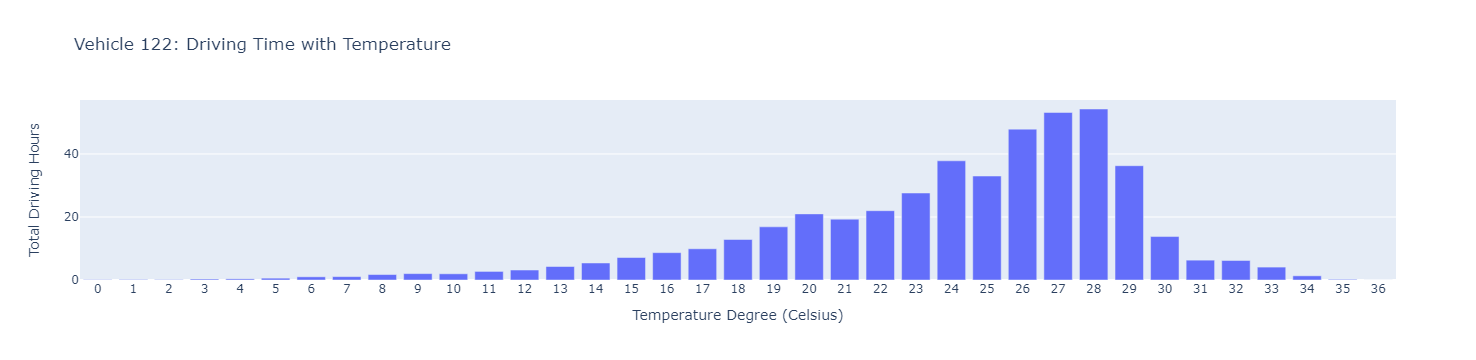

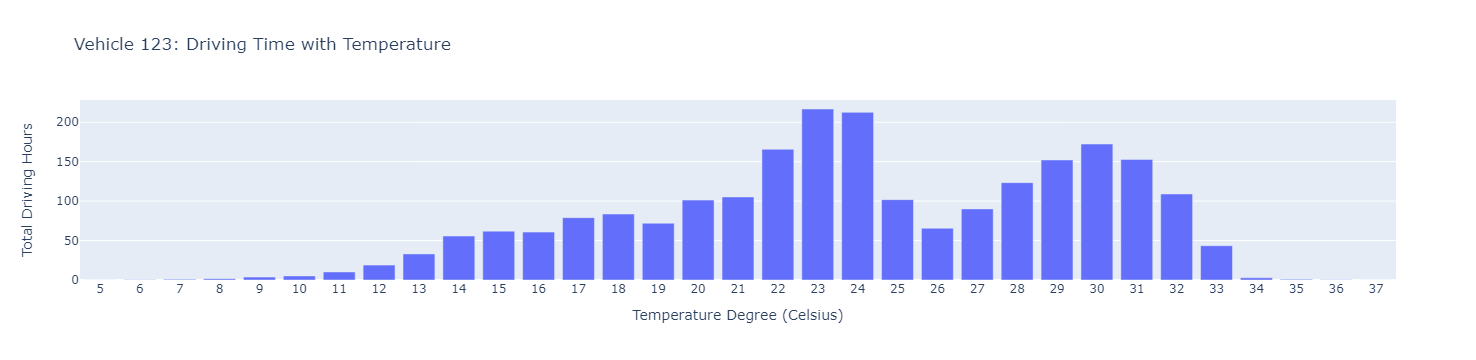

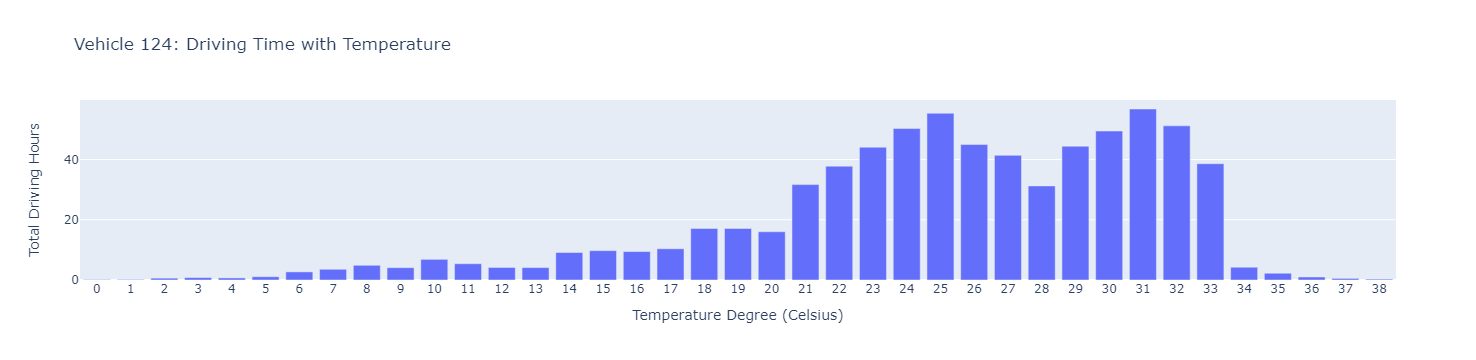

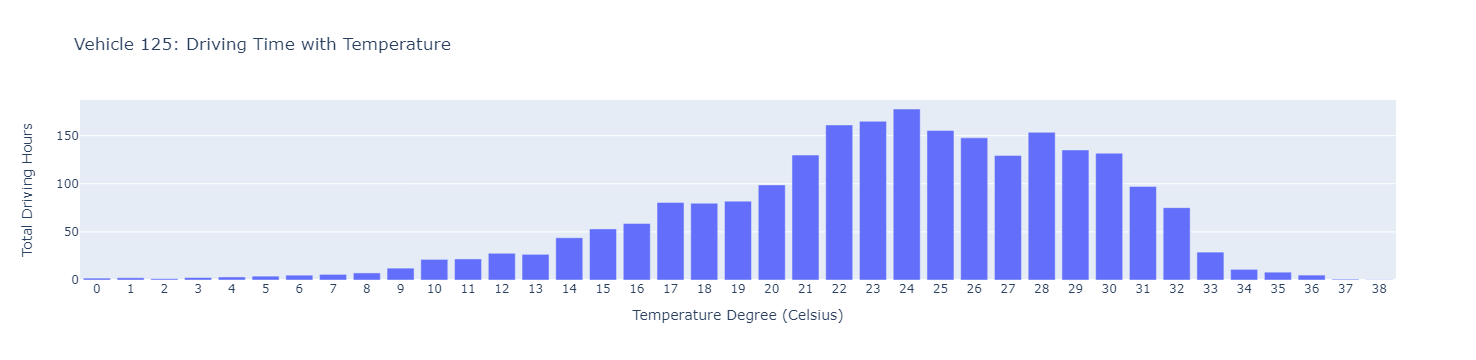

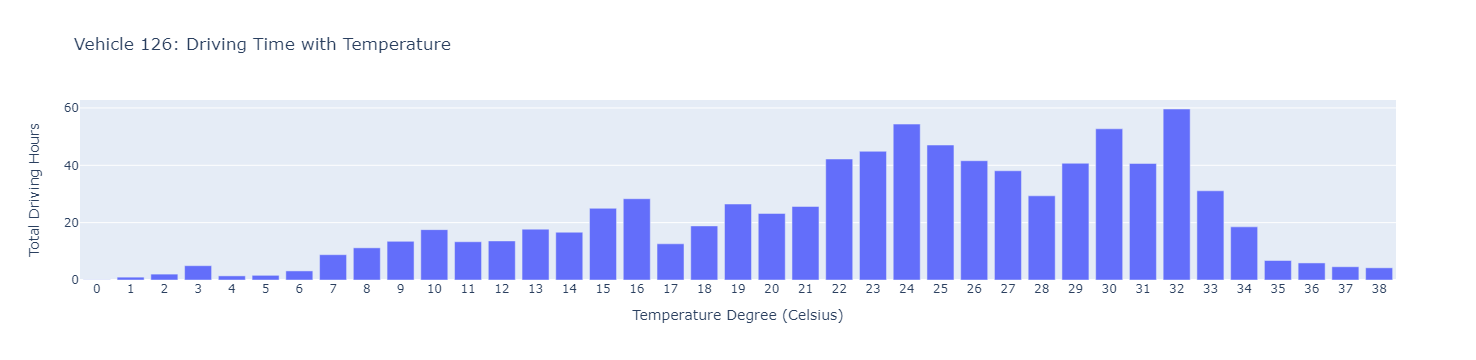

In [12]:
# plot showing in this block
df_temp_list = []
for i, r in vin_list.iterrows():
    vin = r[0]
    df_temp = readTempDataframe(str(vin))
    temp_group = plotTimeTemp(df_temp, i)
    df_temp_list.append(temp_group)

In [64]:
df_concat  = pd.DataFrame(pd.concat(df_temp_list))
df_concat = df_concat.reset_index()
df_concat_sum = df_concat.groupby('Average Temp')['driving_time'].mean()
df_concat_std = df_concat.groupby('Average Temp')['driving_time'].std()
df_concat_sum, df_concat_std

(Average Temp
 0      2.459784
 1      2.216588
 2      2.075065
 3      2.125601
 4      2.547009
 5      3.221571
 6      4.516020
 7      5.739000
 8      7.628350
 9     10.134745
 10    12.367945
 11    14.027274
 12    15.704740
 13    17.859102
 14    20.590737
 15    22.821691
 16    24.361171
 17    25.728413
 18    28.701850
 19    31.701927
 20    34.532734
 21    43.040309
 22    56.630933
 23    66.275148
 24    73.846658
 25    63.884436
 26    55.568358
 27    55.180106
 28    56.845589
 29    62.570862
 30    64.994206
 31    61.282773
 32    51.546573
 33    26.057327
 34     5.137511
 35     2.195298
 36     1.295660
 37     0.725392
 38     0.494113
 39     0.378022
 40     0.312789
 41     0.385361
 42     0.214028
 Name: driving_time, dtype: float64,
 Average Temp
 0      5.210141
 1      4.880102
 2      4.407327
 3      3.479129
 4      3.702150
 5      4.482674
 6      5.992170
 7      6.688496
 8      9.000128
 9     11.510273
 10    12.766825
 11    12.846861


In [36]:
neg = pd.DataFrame(data = [[0,1,2,3,4.5,-1,-2],[1,1,1,1,1,1,1]])
neg = neg.T
neg = neg.astype(int)
group = neg.groupby(0)[1].sum()
group.index

Int64Index([-2, -1, 0, 1, 2, 3, 4], dtype='int64', name=0)

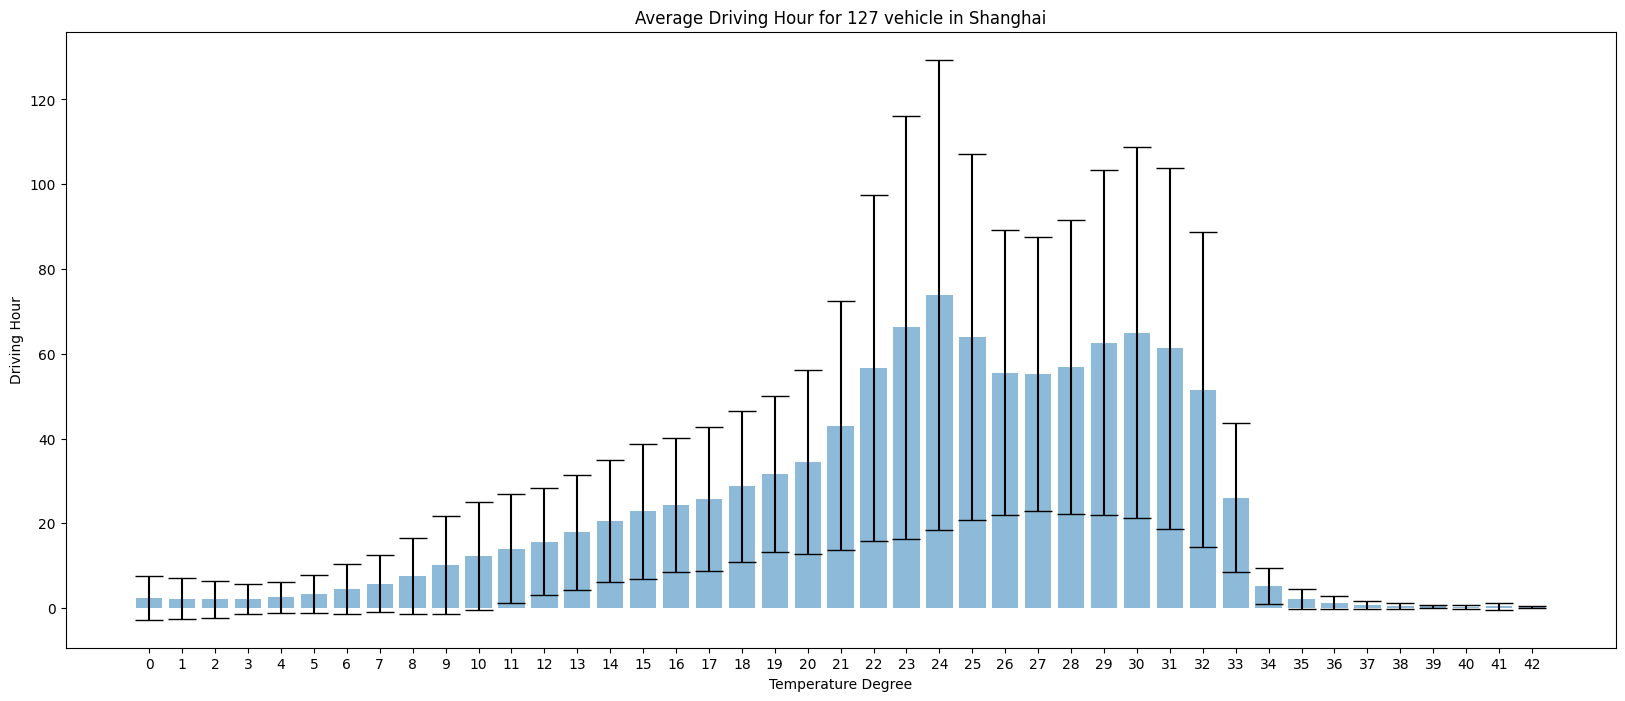

In [70]:
fig, ax = plt.subplots(figsize = (20,8))
ax.bar(df_concat_sum.index, df_concat_sum.values, yerr=df_concat_std.values, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(df_concat_sum.index)
plt.title('Average Driving Hour for 127 vehicle in Shanghai')
plt.xlabel('Temperature Degree')
plt.ylabel('Driving Hour')
plt.show()

In [ ]:
go.Bar(
    name='Control',
    x=['Trial 1', 'Trial 2', 'Trial 3'], y=[3, 6, 4],
    error_y=dict(type='data', array=[1, 0.5, 1.5]

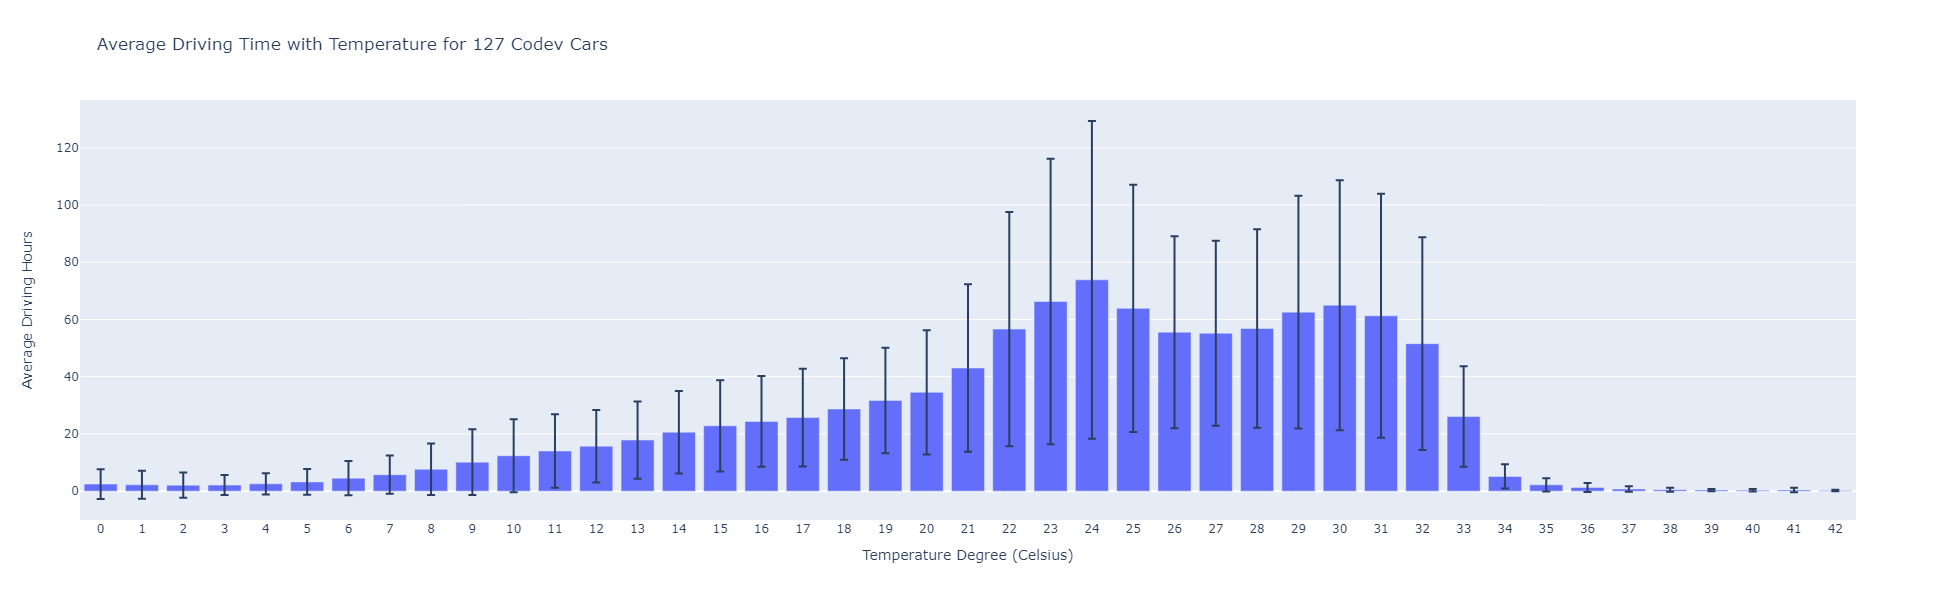

In [79]:
fig = go.Figure(data=[go.Bar(x=df_concat_sum.index,
                             y=df_concat_sum.values,
                             error_y=dict(type='data', array=df_concat_std.values))])
fig.update_layout(title='Average Driving Time with Temperature for 127 Codev Cars',
                  xaxis=dict(tickmode='linear',
                             tick0=1,
                             dtick=1,
                             title='Temperature Degree (Celsius)'),
                  yaxis=dict(title='Average Driving Hours'),
                  height=600)
fig.show()
